# Data Description
* **TransactionDT**: Timedelta from a given reference datetime (not an actual timestamp)
* **TransactionAMT**: Transaction payment amount in USD
* **ProductCD**: Product code, the product for each transaction
* **card1 - card6**: Payment card information, such as card type, card category, issue bank, country, etc.
* **addr**: Address
* **dist**: Distance
* **P_ and R_emaildomain**: Purchaser and recipient email domain
* **C1-C14**: Counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* **D1-D15**: Timedelta, such as days between previous transaction, etc.
* **M1-M9**: mMatch, such as names on card and address, etc.
* **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.

* **Categorical Features**: ProductCD, card1 - card6, addr1, addr2, P_emaildomain, R_emaildomain, M1 - M9

## Identity Table
* Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions. They're collected by Vesta’s fraud protection system and digital security partners. (The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement)

* **Transaction id**: Id related to the transaction
* **DeviceType**: Type of device used for the transaction
* **DeviceInfo** : More information about device used
* **id 1–38**: network connection information,browser information etc (id 12–38 are categorical information)

* Categorical Features: DeviceType, DeviceInfo, id_12 - id_38

## Business Approach

* Big data approach.
    * Huge amount data.
    * It is important to be able to detect fraud quickly.
    * Efficient Resource Utilization
    * Cost Savings
    * Scalability
    * Stability and Reliability
    * Compatibility
    * Energy Efficiency

## Importing Libraries

In [147]:
import gc
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import plotly.express as px
from matplotlib import pyplot as plt

from sklearn import metrics
from collections import Counter
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import AdaBoostClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Activation, Input, Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping


import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

import sys
sys.path.append(parent_dir)

import BalanceDataset as balance
import MachineLearningModels as ml_models
import DeepLearningModels as dl_models


pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns',700)
pd.set_option('display.float_format', lambda x: '%.3f' % x)


import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
import shap

## Reduce Memory Usage
* If the column is of integer type, it checks if its values can fit within a smaller integer data type (e.g., int8, int16, int32, int64) without loss of information. If so, it downcasts the column to the smallest possible integer data type that can accommodate the range of values.

In [3]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Memory usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Loading Data

In [4]:
train_transaction = pd.read_csv("train_transaction.csv")
train_identity = pd.read_csv("train_identity.csv")

test_transaction = pd.read_csv("test_transaction.csv")
test_identity = pd.read_csv("test_identity.csv")

In [5]:
# Fix Column Name 
fix_col_name = {testIdCol:trainIdCol for testIdCol, trainIdCol in zip(test_identity.columns, train_identity.columns)}
test_identity.rename(columns=fix_col_name, inplace=True)

In [6]:
# Reduce Memory
train_transaction = reduce_mem_usage(train_transaction)
train_identity = reduce_mem_usage(train_identity)

test_transaction = reduce_mem_usage(test_transaction)
test_identity = reduce_mem_usage(test_identity)   

Memory usage decreased to 916.30 Mb (48.4% reduction)
Memory usage decreased to 31.91 Mb (29.3% reduction)
Memory usage decreased to 785.71 Mb (48.3% reduction)
Memory usage decreased to 31.40 Mb (29.3% reduction)


In [7]:
# Merge (transaction - identity)
train = train_transaction.merge(train_identity, on='TransactionID', how='left')
test = test_transaction.merge(test_identity, on='TransactionID', how='left')

In [8]:
# Merge (X_train - X_test)
train_test = pd.concat([train, test], ignore_index=True)

In [9]:
print(f'train dataset has {train.shape[0]} rows and {train.shape[1]} columns.')
print(f'test dataset has {test.shape[0]} rows and {test.shape[1]} columns.')

train dataset has 590540 rows and 434 columns.
test dataset has 506691 rows and 433 columns.


In [10]:
train_test = train_test.copy()
train = train.copy()
test = test.copy()

# Exploratory Data Analysis (EDA)

In [11]:
train.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400          68.500         W  13926   
1        2987001        0          86401          29.000         W   2755   
2        2987002        0          86469          59.000         W   4663   
3        2987003        0          86499          50.000         W  18132   
4        2987004        0          86506          50.000         H   4497   

    card2   card3       card4   card5   card6   addr1  addr2   dist1  dist2  \
0     NaN 150.000    discover 142.000  credit 315.000 87.000  19.000    NaN   
1 404.000 150.000  mastercard 102.000  credit 325.000 87.000     NaN    NaN   
2 490.000 150.000        visa 166.000   debit 330.000 87.000 287.000    NaN   
3 567.000 150.000  mastercard 117.000   debit 476.000 87.000     NaN    NaN   
4 514.000 150.000  mastercard 102.000  credit 420.000 87.000     NaN    NaN   

  P_emaildomain R_emaildomain    C1    C2    C3    C4    C5    C6    C7    C8  \
0           NaN           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000   
1     gmail.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000   
2   outlook.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000   
3     yahoo.com           NaN 2.000 5.000 0.000 0.000 0.000 4.000 0.000 0.000   
4     gmail.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000   

     C9   C10   C11   C12    C13   C14      D1      D2     D3     D4    D5  \
0 1.000 0.000 2.000 0.000  1.000 1.000  14.000     NaN 13.000    NaN   NaN   
1 0.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN  0.000   NaN   
2 1.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN  0.000   NaN   
3 1.000 0.000 1.000 0.000 25.000 1.000 112.000 112.000  0.000 94.000 0.000   
4 0.000 1.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN    NaN   NaN   

   D6  D7  D8  D9    D10     D11  D12  D13  D14     D15   M1   M2   M3   M4  \
0 NaN NaN NaN NaN 13.000  13.000  NaN  NaN  NaN   0.000    T    T    T   M2   
1 NaN NaN NaN NaN  0.000     NaN  NaN  NaN  NaN   0.000  NaN  NaN  NaN   M0   
2 NaN NaN NaN NaN  0.000 315.000  NaN  NaN  NaN 315.000    T    T    T   M0   
3 NaN NaN NaN NaN 84.000     NaN  NaN  NaN  NaN 111.000  NaN  NaN  NaN   M0   
4 NaN NaN NaN NaN    NaN     NaN  NaN  NaN  NaN     NaN  NaN  NaN  NaN  NaN   

    M5   M6   M7   M8   M9    V1    V2    V3    V4    V5    V6    V7    V8  \
0    F    T  NaN  NaN  NaN 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
1    T    T  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
2    F    F    F    F    F 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000   
3    T    F  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
4  NaN  NaN  NaN  NaN  NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

     V9   V10   V11   V12   V13   V14   V15   V16   V17   V18   V19   V20  \
0 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
1   NaN   NaN   NaN 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
2 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
3   NaN   NaN   NaN 1.000 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V21   V22   V23   V24   V25   V26   V27   V28   V29   V30   V31   V32  \
0 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
2 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
3 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V33   V34   V35   V36   V37   V38   V39   V40   V41   V42   V43   V44  \
0 0.000 0.000   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000   
2 0.000 

In [12]:
train.shape

(590540, 434)

In [13]:
train.dtypes

TransactionID       int32
isFraud              int8
TransactionDT       int32
TransactionAmt    float32
ProductCD          object
card1               int16
card2             float32
card3             float32
card4              object
card5             float32
card6              object
addr1             float32
addr2             float32
dist1             float32
dist2             float32
P_emaildomain      object
R_emaildomain      object
C1                float32
C2                float32
C3                float32
C4                float32
C5                float32
C6                float32
C7                float32
C8                float32
C9                float32
C10               float32
C11               float32
C12               float32
C13               float32
C14               float32
D1                float32
D2                float32
D3                float32
D4                float32
D5                float32
D6                float32
D7                float32
D8          

## Missing Values

In [14]:
def missing_values_table(df, na_name=False):
    na_columns = df.columns[df.isnull().sum() > 0]
    n_miss = df[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (df[na_columns].isnull().sum() / df.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.DataFrame({'n_miss': n_miss, 'ratio': np.round(ratio, 1)})
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [15]:
missing_values_table(train, na_name=False)

               n_miss  ratio
id_24          585793 99.200
id_25          585408 99.100
id_07          585385 99.100
id_08          585385 99.100
id_21          585381 99.100
id_26          585377 99.100
id_27          585371 99.100
id_23          585371 99.100
id_22          585371 99.100
dist2          552913 93.600
D7             551623 93.400
id_18          545427 92.400
D13            528588 89.500
D14            528353 89.500
D12            525823 89.000
id_03          524216 88.800
id_04          524216 88.800
D6             517353 87.600
id_33          517251 87.600
id_10          515614 87.300
id_09          515614 87.300
D8             515614 87.300
D9             515614 87.300
id_30          512975 86.900
id_32          512954 86.900
id_34          512735 86.800
id_14          510496 86.400
V155           508595 86.100
V138           508595 86.100
V156           508595 86.100
V157           508595 86.100
V158           508595 86.100
V154           508595 86.100
V153          

## Exploring Target

In [16]:
def show_graphs(df):
    fraud_counts = df['isFraud'].value_counts()

    # pie chart
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 5))

    ax1.pie(fraud_counts, labels=['Non-fraudulent', 'Fraudulent'], colors=['lightblue', 'lightcoral'], autopct='%1.1f%%')
    ax1.set_title('Transaction Class Distribution')

    # bar plot
    ax2.bar(['Non-fraudulent', 'Fraudulent'], fraud_counts.values, color=['lightblue', 'lightcoral'])
    ax2.set_xlabel('Transaction Class')
    ax2.set_ylabel('Number of Transactions')
    ax2.set_title('Credit Card Fraud Detection')
    for i in ax2.containers:
        ax2.bar_label(i,)

    plt.show()

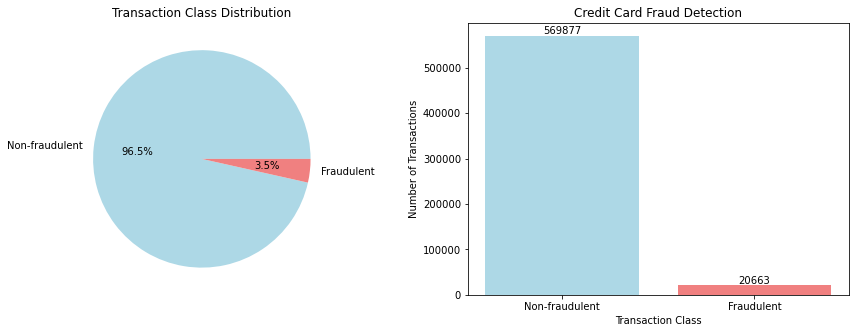

In [17]:
show_graphs(train)

In [18]:
train_non_fraudulent = train[train['isFraud']==0]
train_fraudulent = train[train['isFraud']==1]

In [19]:
train_non_fraudulent_count = train_non_fraudulent["isFraud"].value_counts()
train_fraudulent_count = train_fraudulent["isFraud"].value_counts()

In [20]:
print(f"Normal transaction count = {train_non_fraudulent_count[0]} (% {train_non_fraudulent_count[0]/len(train)*100})")
print(f"Fraudulent transaction count = {train_fraudulent_count[1]} (% {train_fraudulent_count[1]/len(train)*100})")

Normal transaction count = 569877 (% 96.50099908558268)
Fraudulent transaction count = 20663 (% 3.4990009144173126)


In [21]:
train_non_fraudulent

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
0             2987000        0          86400          68.500         W   
1             2987001        0          86401          29.000         W   
2             2987002        0          86469          59.000         W   
3             2987003        0          86499          50.000         W   
4             2987004        0          86506          50.000         H   
...               ...      ...            ...             ...       ...   
590535        3577535        0       15811047          49.000         W   
590536        3577536        0       15811049          39.500         W   
590537        3577537        0       15811079          30.953         W   
590538        3577538        0       15811088         117.000         W   
590539        3577539        0       15811131         280.000         W   

        card1   card2   card3       card4   card5   card6   addr1  addr2  \
0       13926     NaN 150.000    discover 142.000  credit 315.000 87.000   
1        2755 404.000 150.000  mastercard 102.000  credit 325.000 87.000   
2        4663 490.000 150.000        visa 166.000   debit 330.000 87.000   
3       18132 567.000 150.000  mastercard 117.000   debit 476.000 87.000   
4        4497 514.000 150.000  mastercard 102.000  credit 420.000 87.000   
...       ...     ...     ...         ...     ...     ...     ...    ...   
590535   6550     NaN 150.000        visa 226.000   debit 272.000 87.000   
590536  10444 225.000 150.000  mastercard 224.000   debit 204.000 87.000   
590537  12037 595.000 150.000  mastercard 224.000   debit 231.000 87.000   
590538   7826 481.000 150.000  mastercard 224.000   debit 387.000 87.000   
590539  15066 170.000 150.000  mastercard 102.000  credit 299.000 87.000   

         dist1  dist2 P_emaildomain R_emaildomain    C1    C2    C3    C4  \
0       19.000    NaN           NaN           NaN 1.000 1.000 0.000 0.000   
1          NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
2      287.000    NaN   outlook.com           NaN 1.000 1.000 0.000 0.000   
3          NaN    NaN     yahoo.com           NaN 2.000 5.000 0.000 0.000   
4          NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
...        ...    ...           ...           ...   ...   ...   ...   ...   
590535  48.000    NaN           NaN           NaN 2.000 1.000 0.000 0.000   
590536     NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
590537     NaN    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000   
590538   3.000    NaN       aol.com           NaN 1.000 1.000 0.000 0.000   
590539     NaN    NaN     gmail.com           NaN 2.000 1.000 0.000 0.000   

          C5    C6    C7    C8    C9   C10   C11   C12    C13   C14      D1  \
0      0.000 1.000 0.000 0.000 1.000 0.000 2.000 0.000  1.000 1.000  14.000   
1      0.000 1.000 0.000 0.000 0.000 0.000 1.000 0.000  1.000 1.000   0.000   
2      0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000   
3      0.000 4.000 0.000 0.000 1.000 0.000 1.000 0.000 25.000 1.000 112.000   
4      0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000  1.000 1.000   0.000   
...      ...   ...   ...   ...   ...   ...   ...   ...    ...   ...     ...   
590535 1.000 0.000 0.000 0.000 2.000 0.000 1.000 0.000  3.000 2.000  29.000   
590536 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000   
590537 1.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000   
590538 0.000 3.000 0.000 0.000 2.000 0.000 1.000 1.000  5.000 1.000  22.000   
590539 1.000 1.000 0.000 0.000 2.000 0.000 1.000 0.000  1.000 1.000   0.000   

            D2     D3     D4    D5  D6  D7  D8  D9    D10     D11  D12  D13  \
0          NaN 13.000    NaN   NaN NaN NaN NaN NaN 13.000  13.000  NaN  NaN   
1          NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000     NaN  NaN  NaN   
2          NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000 315.000  NaN  NaN   
3   

In [22]:
train_fraudulent

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  \
203           2987203        1          89760         445.000         W   
240           2987240        1          90193          37.094         C   
243           2987243        1          90246          37.094         C   
245           2987245        1          90295          37.094         C   
288           2987288        1          90986         155.500         C   
...               ...      ...            ...             ...       ...   
590361        3577361        1       15807368        1224.000         W   
590364        3577364        1       15807516          69.938         C   
590368        3577368        1       15807677         100.000         H   
590372        3577372        1       15807758         117.000         W   
590526        3577526        1       15810876         250.000         R   

        card1   card2   card3             card4   card5   card6   addr1  \
203     18268 583.000 150.000              visa 226.000  credit 251.000   
240     13413 103.000 185.000              visa 137.000  credit     NaN   
243     13413 103.000 185.000              visa 137.000  credit     NaN   
245     13413 103.000 185.000              visa 137.000  credit     NaN   
288     16578 545.000 185.000              visa 226.000  credit     NaN   
...       ...     ...     ...               ...     ...     ...     ...   
590361   3278 453.000 150.000              visa 226.000   debit 191.000   
590364   5812 408.000 185.000        mastercard 224.000   debit     NaN   
590368   6758 399.000 150.000  american express 146.000  credit 299.000   
590372  14037 111.000 150.000              visa 226.000  credit 272.000   
590526   1214 174.000 150.000              visa 226.000  credit 272.000   

        addr2  dist1  dist2 P_emaildomain R_emaildomain    C1    C2    C3  \
203    87.000    NaN    NaN       aol.com           NaN 2.000 2.000 0.000   
240       NaN    NaN    NaN   hotmail.com   hotmail.com 0.000 1.000 0.000   
243       NaN    NaN    NaN   hotmail.com   hotmail.com 1.000 1.000 0.000   
245       NaN    NaN    NaN   hotmail.com   hotmail.com 2.000 1.000 0.000   
288       NaN    NaN    NaN   outlook.com   outlook.com 1.000 1.000 0.000   
...       ...    ...    ...           ...           ...   ...   ...   ...   
590361 87.000 26.000    NaN     yahoo.com           NaN 3.000 1.000 0.000   
590364    NaN    NaN 24.000   hotmail.com   hotmail.com 1.000 3.000 0.000   
590368 87.000    NaN    NaN   hotmail.com   hotmail.com 1.000 1.000 0.000   
590372 87.000    NaN    NaN     yahoo.com           NaN 1.000 1.000 0.000   
590526 87.000    NaN    NaN     gmail.com     gmail.com 1.000 1.000 0.000   

          C4    C5    C6    C7    C8    C9   C10   C11   C12   C13   C14  \
203    0.000 0.000 2.000 0.000 0.000 2.000 0.000 1.000 0.000 4.000 2.000   
240    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
243    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
245    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
288    1.000 0.000 1.000 1.000 1.000 0.000 1.000 1.000 1.000 0.000 0.000   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
590361 0.000 0.000 1.000 0.000 0.000 2.000 0.000 1.000 0.000 6.000 3.000   
590364 1.000 0.000 1.000 1.000 3.000 0.000 2.000 2.000 2.000 0.000 0.000   
590368 1.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000 1.000 1.000   
590372 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
590526 1.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000 0.000 1.000 1.000   

            D1     D2     D3      D4     D5      D6     D7     D8    D9  \
203     57.000 57.000 52.000   0.000    NaN     NaN    NaN    NaN   NaN   
240      0.000    NaN    NaN   0.000    NaN   0.000    NaN 45.031 0.042   
243      0.000    NaN    NaN   0.000  0.000   0.000  0.000 45.031 0.042   
245      0.000    NaN    NaN   0.000  0.000   0.000  0.000 45.031 0.

## Exploring Continuous Features

In [23]:
def plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, col):
    plt.figure(figsize=(15, 10))
    plt.suptitle(f'{col} Distributions ', fontsize=24)

    plt.subplot(221)
    sns.distplot(train[col], color='lightskyblue')
    plt.title('Train Set Distribution')

    plt.subplot(222)
    sns.distplot(test[col], color='lightcoral')
    plt.title('Test Set Distribution')

    plt.subplot(223)
    sns.distplot(train_fraudulent[col], color='purple', label='Fraud')
    sns.distplot(train_non_fraudulent[col], color='lightcoral', label='Non-Fraud')
    plt.title('Fraud vs non-Fraud Distribution')
    plt.legend()
    
    plt.subplot(224)
    fraud_count = len(train_fraudulent)
    non_fraud_count = len(train_non_fraudulent)
    labels = ['Fraud', 'Non-Fraud']
    sizes = [fraud_count, non_fraud_count]
    colors = ['lightskyblue', 'lightcoral']
    explode = (0.1, 0)  # explode the first slice
    plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Transaction Distribution: Fraud vs Non-Fraud')

    plt.tight_layout()  # Adjust the spacing between subplots
    plt.show()


In [24]:
def log_scaled_distribution_plot(train_fraudulent, train_non_fraudulent, col):
    plt.figure(figsize=(15,5))
    sns.distplot(train_fraudulent[col].apply(np.log), label = 'Fraud | isFraud = 1', color= "lightcoral")
    sns.distplot(train_non_fraudulent[col].apply(np.log), label = 'non-Fraud | isFraud = 0', color ="lightskyblue")
    plt.title('Fraud vs non-Fraud distribution')
    plt.legend()
    plt.show()

### **TransactionDT**
* TransactionDT : is a timedelta from a given reference datetime (not an actual timestamp).
* TransactionDT is one of the features that can cause problems.
* It seems as if there is a time difference between testing and train operations.

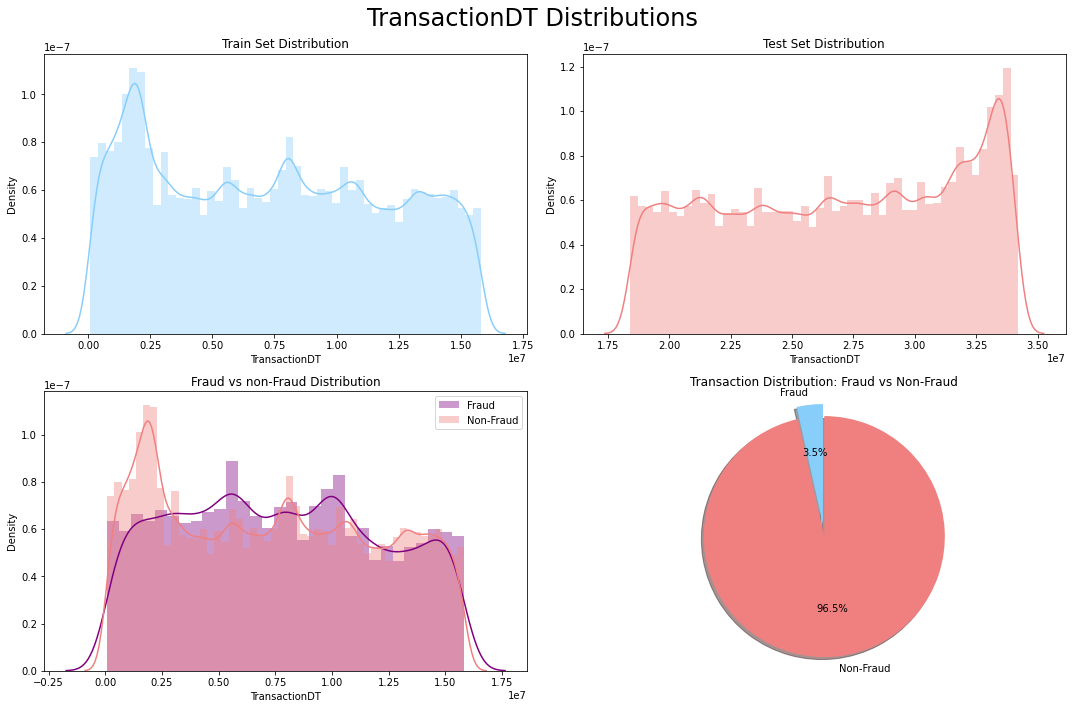

In [25]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "TransactionDT")

### **TransactionAmt**
* TransactionAmt : The ammount of transaction.
* Applied log transform in order to better show the distribution of data. Otherwise very large transactions skew the distribution.
* The mean of the fraud transaction amount is larger than the mean of non - fraud transaction amount.
* And also , the lowest and highest transaction amounts seem to be more likely to be fraudulent transactions.

In [26]:
print(' Fraud TransactionAmt mean      :  '+str(train_fraudulent['TransactionAmt'].mean()))
print(' Non - Fraud TransactionAmt mean:  '+str(train_non_fraudulent['TransactionAmt'].mean()))

 Fraud TransactionAmt mean      :  149.24530029296875
 Non - Fraud TransactionAmt mean:  134.37013244628906


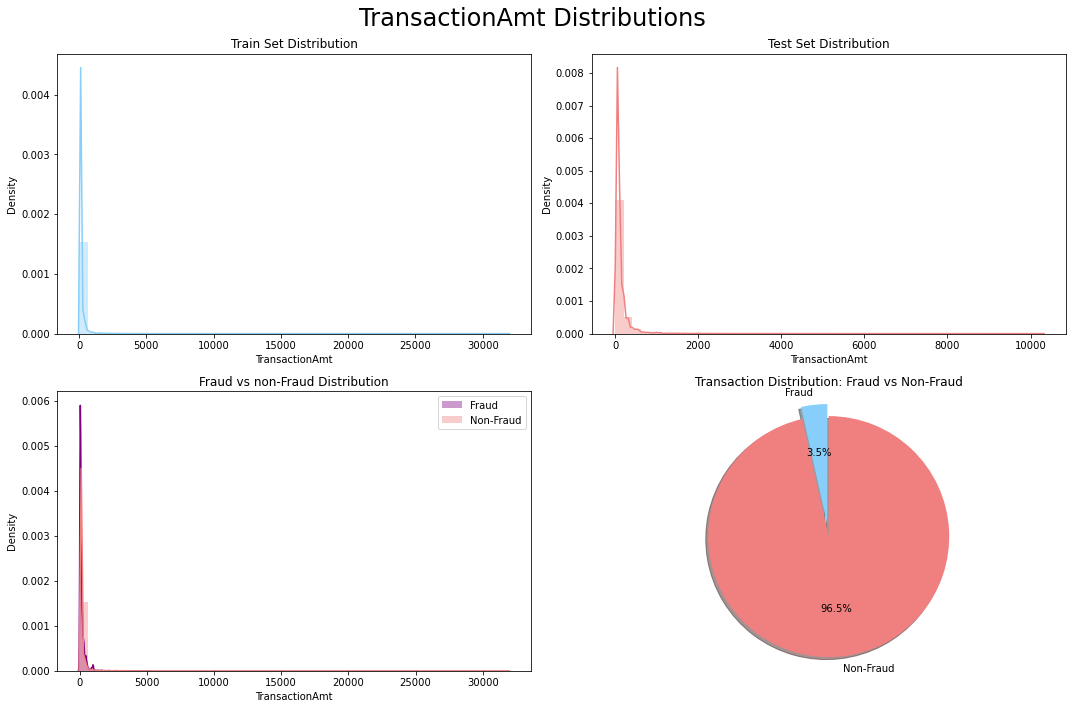

In [27]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "TransactionAmt")

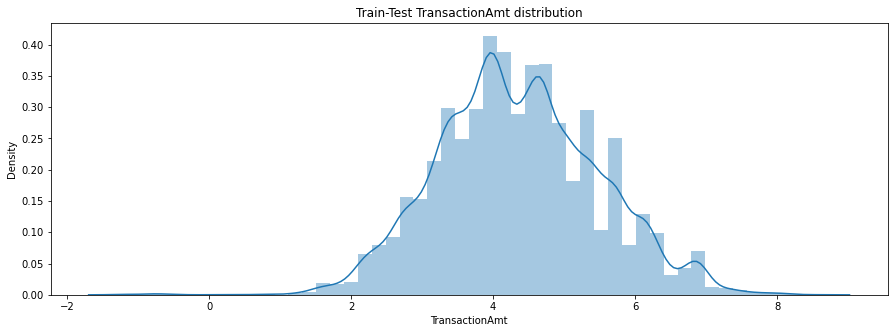

In [28]:
plt.figure(figsize=(15,5))
sns.distplot(train_fraudulent["TransactionAmt"].apply(np.log))
plt.title('Train-Test TransactionAmt distribution')
plt.show()

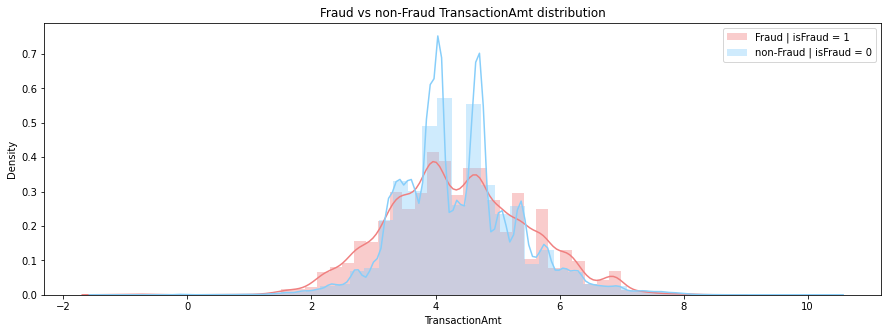

In [29]:
plt.figure(figsize=(15,5))
sns.distplot(train_fraudulent["TransactionAmt"].apply(np.log), label = 'Fraud | isFraud = 1', color= "lightcoral")
sns.distplot(train_non_fraudulent["TransactionAmt"].apply(np.log), label = 'non-Fraud | isFraud = 0', color ="lightskyblue")
plt.title('Fraud vs non-Fraud TransactionAmt distribution')
plt.legend()
plt.show()

### **dist1 & dist2**
* Perhaps this could be the distance of the transaction vs. the card owner's home/work address.

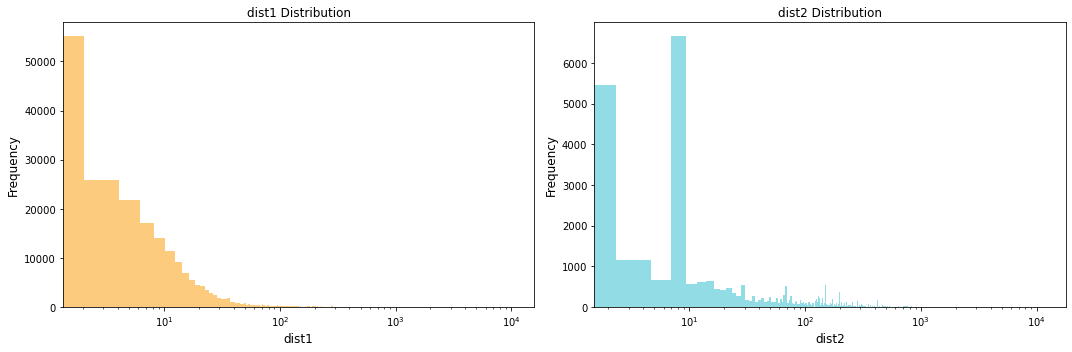

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

colors = ['#FCCB7E', '#92DCE5']  # Soft colors

train['dist1'].plot(kind='hist', bins=5000, ax=ax1, title='dist1 Distribution', logx=True, color=colors[0])
train['dist2'].plot(kind='hist', bins=5000, ax=ax2, title='dist2 Distribution', logx=True, color=colors[1])

ax1.set_xlabel('dist1', fontsize=12)
ax1.set_ylabel('Frequency', fontsize=12)
ax2.set_xlabel('dist2', fontsize=12)
ax2.set_ylabel('Frequency', fontsize=12)

plt.tight_layout()
plt.show()


## Exploring Categorical Features

In [31]:
def visualize_distributions(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0: 'NoFraud', 1: 'Fraud'}, inplace=True)
    total = len(df)

    plt.figure(figsize=(20, 14))
    plt.suptitle(f'{col} Distributions ', fontsize=24)

    plt.subplot(221)
    g = sns.countplot(x=col, hue='isFraud', data=df, order=list(tmp[col].values))
    g.set_title(f"Count of {col} and Fraud vs. Non-Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)

    plt.subplot(222)
    g2 = sns.barplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values), color='cyan')
    g2.set_title(f"Percentage of Fraud Transactions per {col}", fontsize=20)
    g2.set_xlabel(f"{col} Category Names", fontsize=16)
    g2.set_ylabel("% Fraud Transactions", fontsize=17)
    g2.set_xticklabels(g2.get_xticklabels(), rotation=45)

    plt.subplot(223)
    g3 = sns.countplot(x=col, data=df, order=list(tmp[col].values))
    g3.set_title(f"Count of {col} (New subplot)", fontsize=20)
    g3.set_xlabel(f"{col} Category Names", fontsize=16)
    g3.set_ylabel("Count", fontsize=17)
    g3.set_xticklabels(g3.get_xticklabels(), rotation=45)
    
    plt.subplot(224)
    explode = [0, 0.1]  # Explode the "Fraud" slice
    labels = ['Not Fraud', 'Fraud']
    sizes = [tmp['NoFraud'].values[0], tmp['Fraud'].values[0]]
    plt.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90, colors=['purple', 'pink'])
    plt.axis('equal')
    plt.title(f"Percentage of Fraud Transactions for {col}", fontsize=20)

    plt.subplots_adjust(hspace=0.5)
    plt.show()

In [32]:
categorical_columns = train.select_dtypes(include=['object'])
categorical_columns.columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1',
       'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_15',
       'id_16', 'id_23', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_33',
       'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType',
       'DeviceInfo'],
      dtype='object')

- We'll cover the m and id values in another section.

In [33]:
cat_columns = ['isFraud','ProductCD','addr1', 'addr2', 'P_emaildomain','R_emaildomain','DeviceType','DeviceInfo']

In [34]:
train[cat_columns].nunique()

isFraud             2
ProductCD           5
addr1             332
addr2              74
P_emaildomain      59
R_emaildomain      60
DeviceType          2
DeviceInfo       1786
dtype: int64

### **ProductCD**
*  W, C and R are the most frequent values.
* 75.45% of observations belong to product W.
* 1.97% of observations belong to product S.
* Approximately 12% of transactions with product C are fraudulent.
* Approximately 2% of transactions with product W are fraudulent.

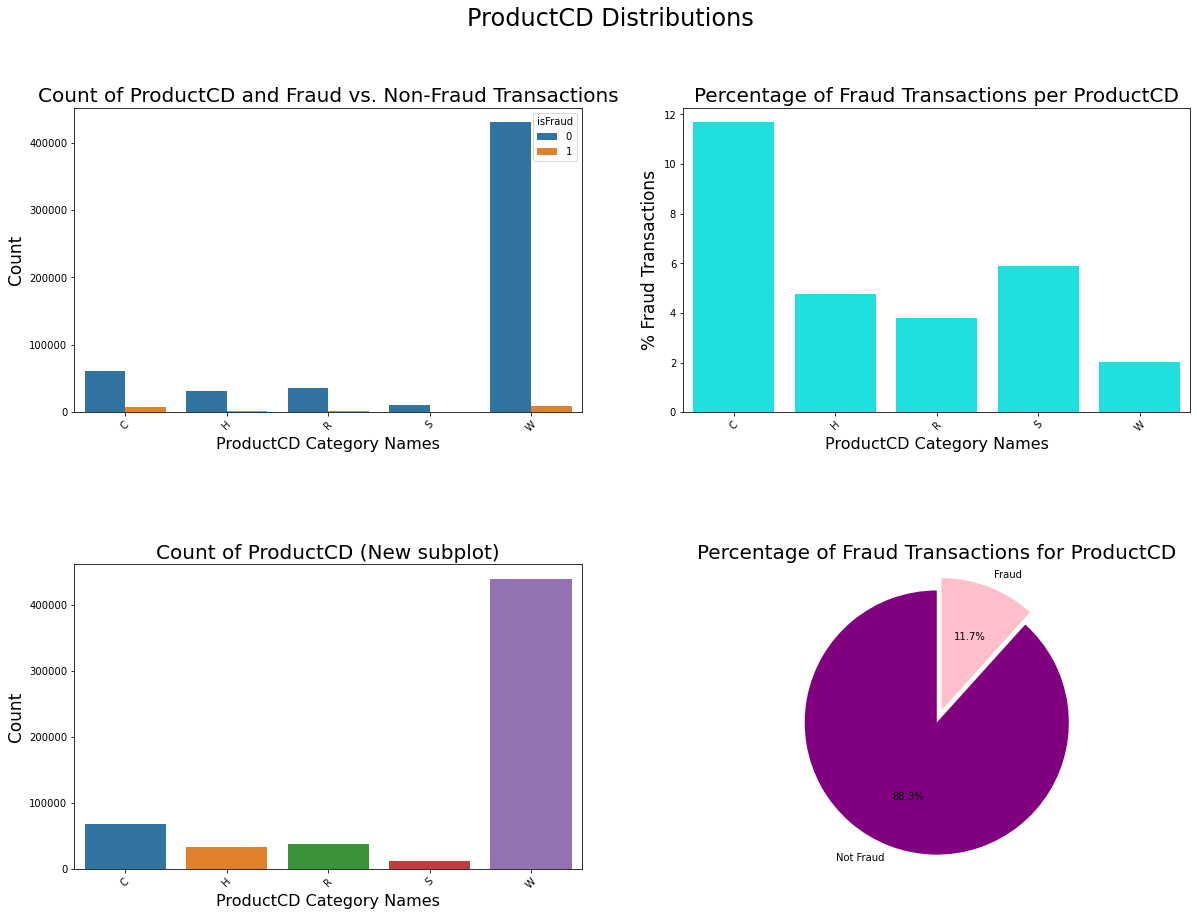

In [35]:
visualize_distributions(train, 'ProductCD')

### **addr1 - addr2**
* It was stated that although these features appear numerical, they are categorical.

In [36]:
train['addr1'].value_counts().head(20)

299.000    46335
325.000    42751
204.000    42020
264.000    39870
330.000    26287
315.000    23078
441.000    20827
272.000    20141
123.000    16105
126.000    15243
184.000    15160
337.000    15149
191.000    14979
181.000    13856
143.000     9806
476.000     9478
310.000     8486
472.000     8478
327.000     8425
512.000     8268
Name: addr1, dtype: int64

In [37]:
train['addr2'].value_counts().head(20)

87.000     520481
60.000       3084
96.000        638
32.000         91
65.000         82
16.000         55
31.000         47
19.000         33
26.000         25
27.000         20
69.000         17
59.000         17
34.000         16
43.000         12
102.000        11
29.000         11
98.000         11
68.000         10
57.000         10
78.000          8
Name: addr2, dtype: int64

In [38]:
train.loc[train['addr1'].isin(train['addr1'].value_counts()[train['addr1'].value_counts() <= 5000 ].index), 'addr1'] = "Others"
train.loc[train['addr2'].isin(train['addr2'].value_counts()[train['addr2'].value_counts() <= 50 ].index), 'addr2'] = "Others"

test.loc[test['addr1'].isin(test.addr1.value_counts()[test['addr1'].value_counts() <= 5000 ].index), 'addr1'] = "Others"
test.loc[test['addr2'].isin(test.addr2.value_counts()[test['addr2'].value_counts() <= 50 ].index), 'addr2'] = "Others"

In [39]:
train['addr1'] = train['addr1'].fillna("None")
test['addr1'] = test['addr1'].fillna("None")

train['addr2'] = train['addr2'].fillna("None")
test['addr2'] = test['addr2'].fillna("None")

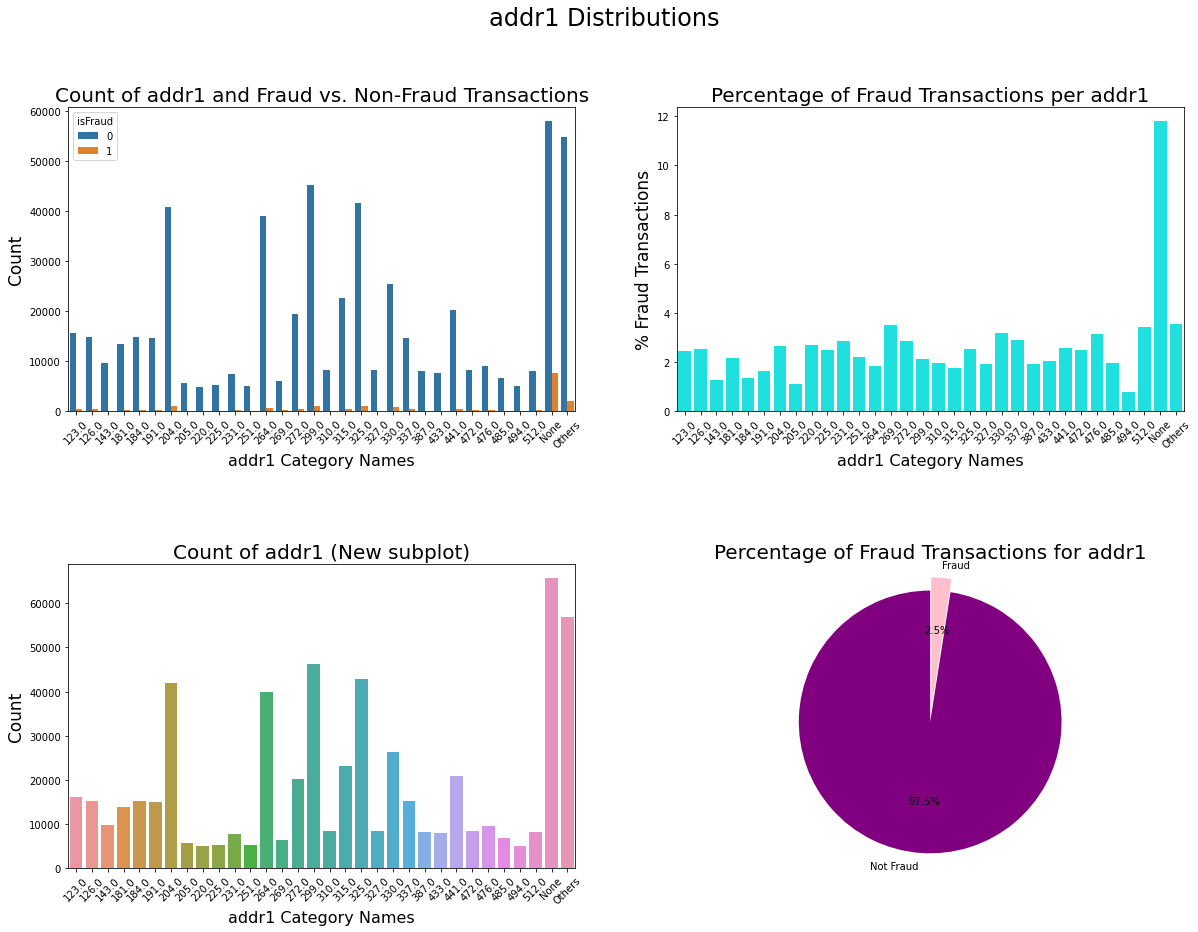

In [40]:
visualize_distributions(train, 'addr1')

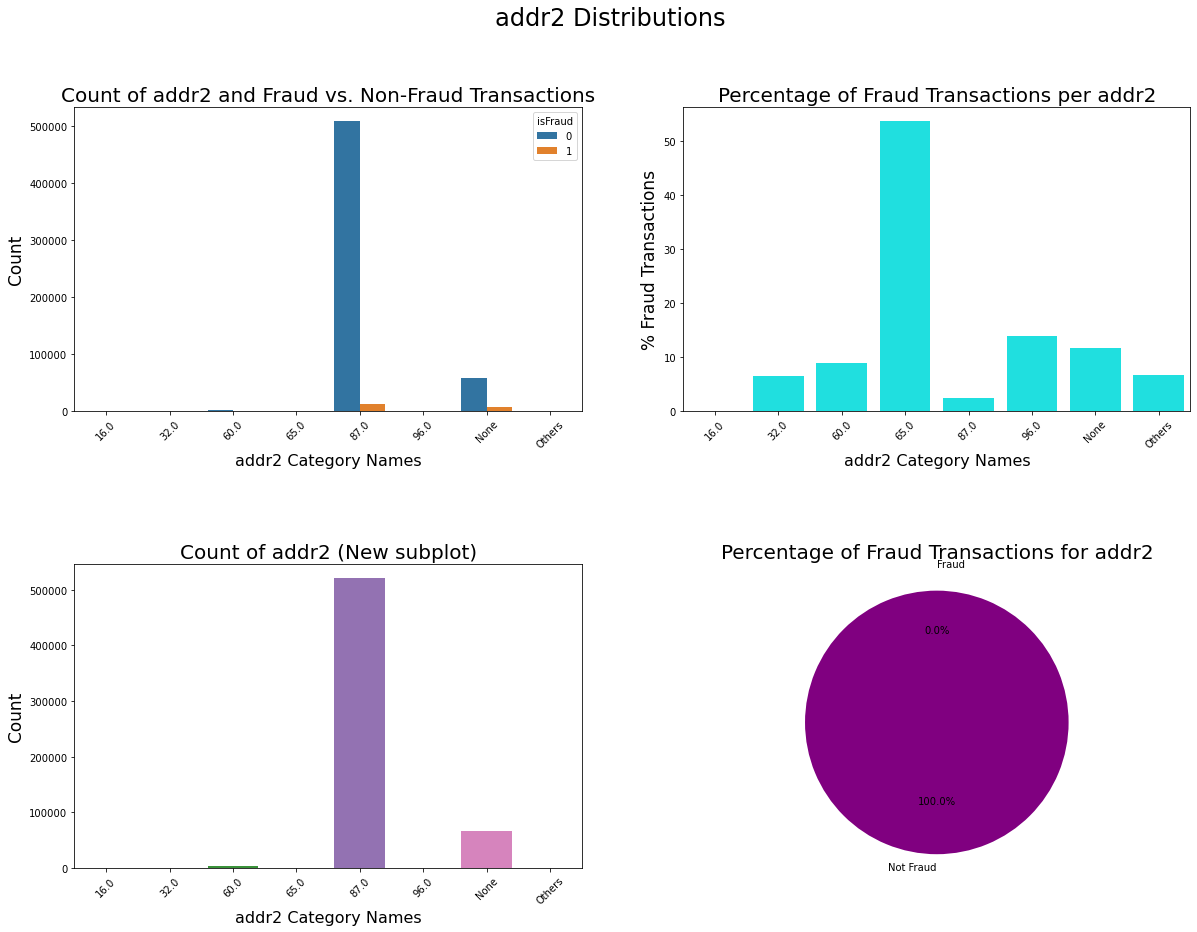

In [41]:
visualize_distributions(train, 'addr2')

### **P-emaildomain & R-emaildomain**
* We can see a very similar distribution in both email domain features.
* We have high values in google and icloud frauds.

**P-emaildomain**
* I will group all e-mail domains by the respective enterprises.
* Also, I will set as "Others" all values with less than 500 entries

In [42]:
train['P_emaildomain'].value_counts()

gmail.com           228355
yahoo.com           100934
hotmail.com          45250
anonymous.com        36998
aol.com              28289
comcast.net           7888
icloud.com            6267
outlook.com           5096
msn.com               4092
att.net               4033
live.com              3041
sbcglobal.net         2970
verizon.net           2705
ymail.com             2396
bellsouth.net         1909
yahoo.com.mx          1543
me.com                1522
cox.net               1393
optonline.net         1011
charter.net            816
live.com.mx            749
rocketmail.com         664
mail.com               559
earthlink.net          514
gmail                  496
outlook.es             438
mac.com                436
juno.com               322
aim.com                315
hotmail.es             305
roadrunner.com         305
windstream.net         305
hotmail.fr             295
frontier.com           280
embarqmail.com         260
web.de                 240
netzero.com            230
t

In [43]:
email_mapping = {
    'gmail.com': 'Google',
    'gmail': 'Google',
    'yahoo.com': 'Yahoo Mail',
    'yahoo.com.mx': 'Yahoo Mail',
    'yahoo.co.uk': 'Yahoo Mail',
    'yahoo.co.jp': 'Yahoo Mail',
    'yahoo.de': 'Yahoo Mail',
    'yahoo.fr': 'Yahoo Mail',
    'yahoo.es': 'Yahoo Mail',
    'hotmail.com': 'Microsoft',
    'outlook.com': 'Microsoft',
    'msn.com': 'Microsoft',
    'live.com.mx': 'Microsoft',
    'hotmail.es': 'Microsoft',
    'hotmail.co.uk': 'Microsoft',
    'hotmail.de': 'Microsoft',
    'outlook.es': 'Microsoft',
    'live.com': 'Microsoft',
    'live.fr': 'Microsoft'
}

In [44]:
email_counts = train['P_emaildomain'].value_counts()
rare_emails = email_counts[email_counts <= 500].index
email_mapping.update({email: 'Others' for email in rare_emails})

train['P_emaildomain'] = train['P_emaildomain'].replace(email_mapping)
train['P_emaildomain'].fillna("NoInfo", inplace=True)

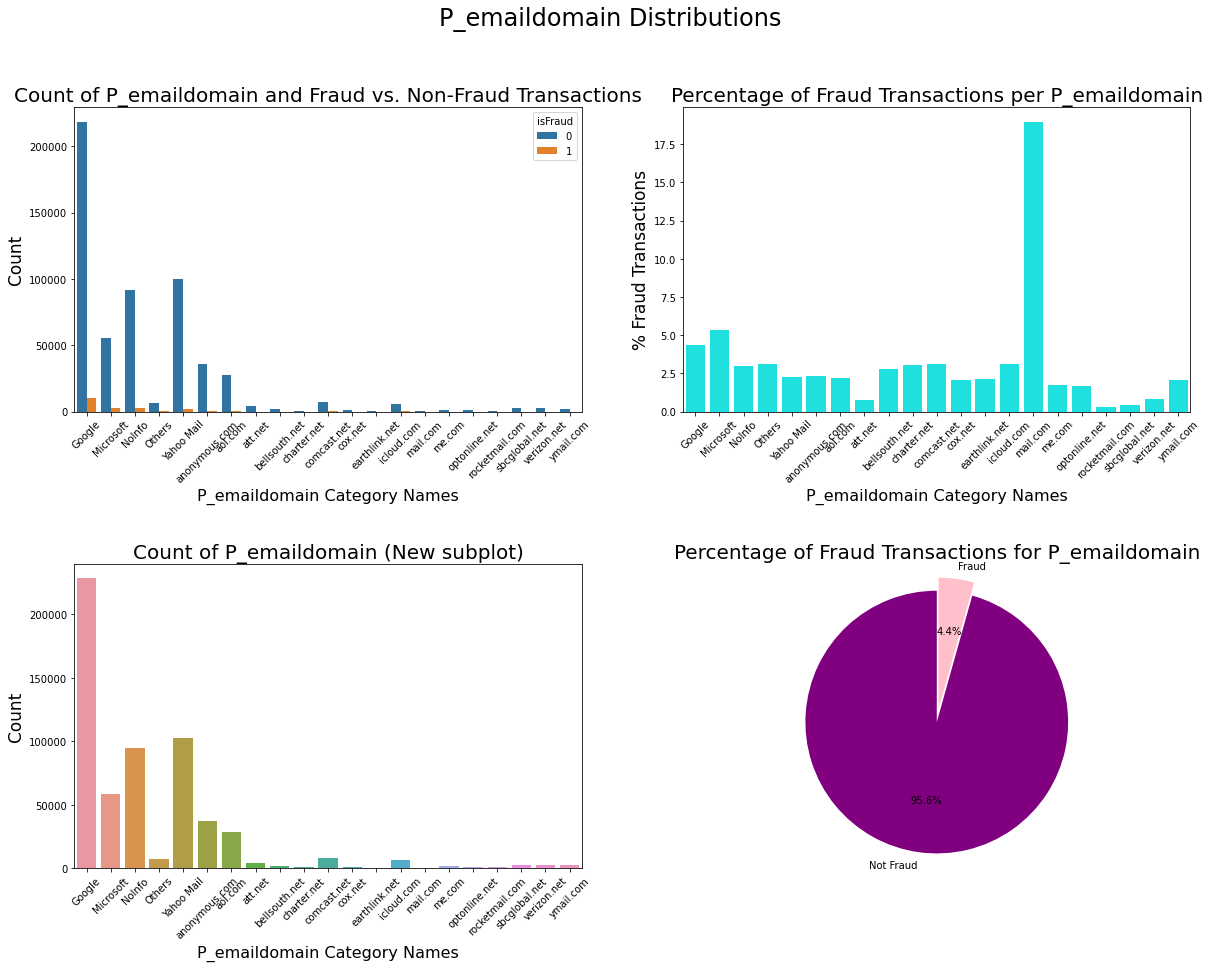

In [45]:
visualize_distributions(train, 'P_emaildomain')

**R-emaildomain**
* I will group all e-mail domains by the respective enterprises.
* I will set as "Others" all values with less than 300 entries.

In [46]:
train['R_emaildomain'].value_counts()

gmail.com           57147
hotmail.com         27509
anonymous.com       20529
yahoo.com           11842
aol.com              3701
outlook.com          2507
comcast.net          1812
yahoo.com.mx         1508
icloud.com           1398
msn.com               852
live.com              762
live.com.mx           754
verizon.net           620
me.com                556
sbcglobal.net         552
cox.net               459
outlook.es            433
att.net               430
bellsouth.net         422
hotmail.fr            293
hotmail.es            292
web.de                237
mac.com               218
ymail.com             207
prodigy.net.mx        207
optonline.net         187
gmx.de                147
yahoo.fr              137
charter.net           127
mail.com              122
hotmail.co.uk         105
gmail                  95
earthlink.net          79
yahoo.de               75
rocketmail.com         69
embarqmail.com         68
scranton.edu           63
yahoo.es               57
live.fr     

In [47]:
email_counts = train['R_emaildomain'].value_counts()
rare_emails = email_counts[email_counts <= 300].index
email_mapping.update({email: 'Others' for email in rare_emails})

train['R_emaildomain'] = train['R_emaildomain'].replace(email_mapping)
train['R_emaildomain'].fillna("NoInfo", inplace=True)

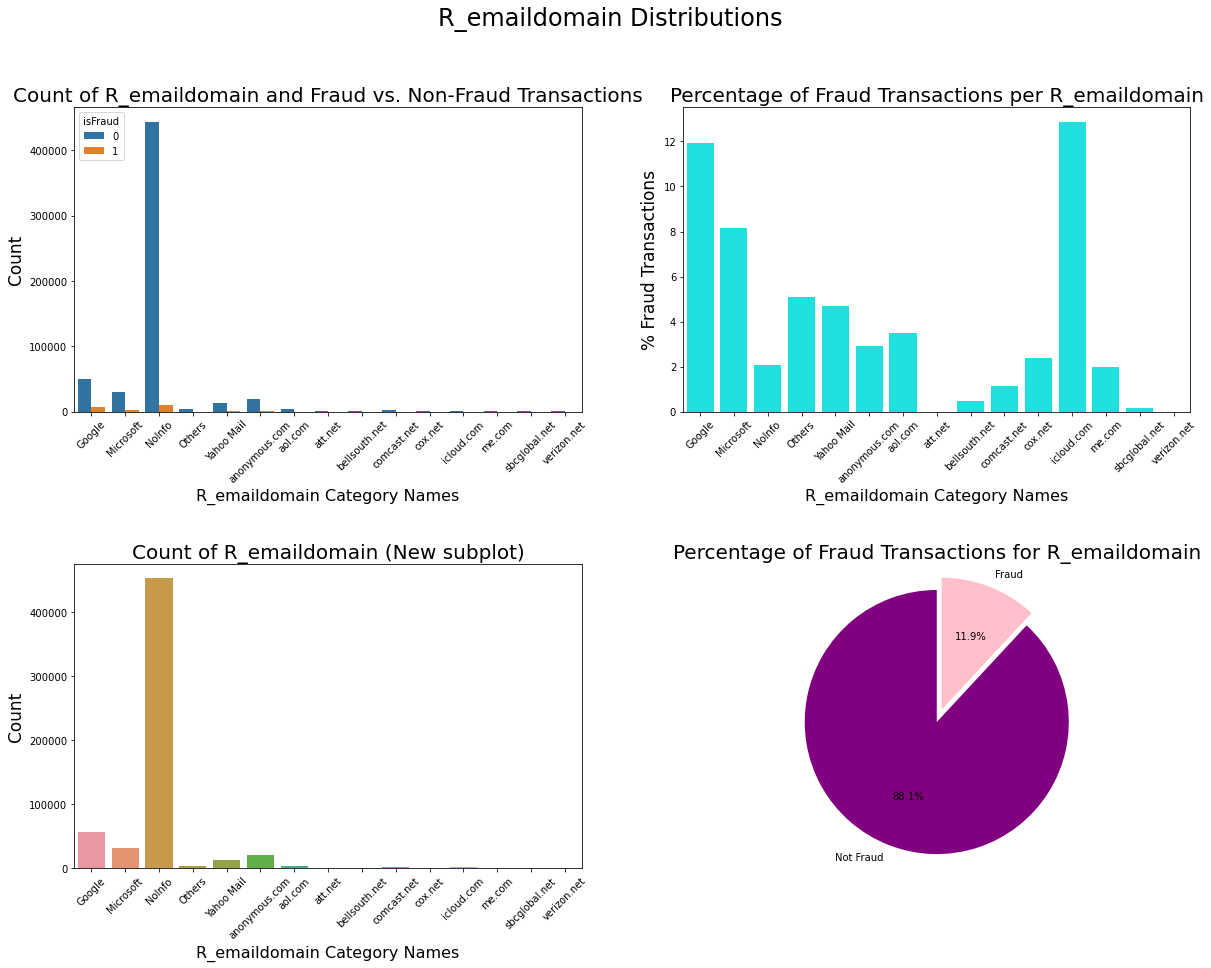

In [48]:
visualize_distributions(train, 'R_emaildomain')

### **DeviceType**

* Most of the fraudulent transactions were done by the mobile device.


In [49]:
train['DeviceType'].value_counts()

desktop    85165
mobile     55645
Name: DeviceType, dtype: int64

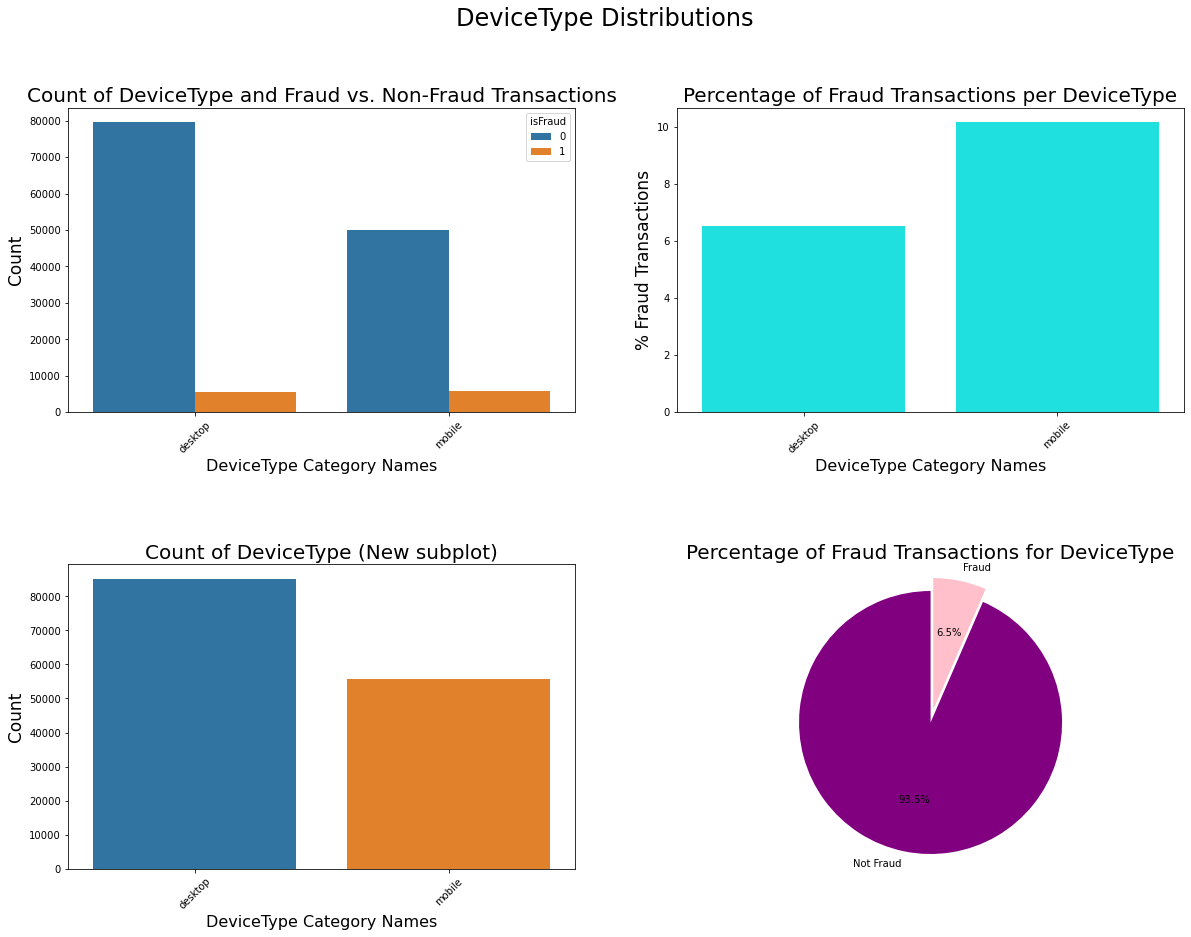

In [50]:
visualize_distributions(train, 'DeviceType')

### DeviceInfo
* Provides information about device names.

In [51]:
train['DeviceInfo'].value_counts()

Windows        47722
iOS Device     19782
MacOS          12573
Trident/7.0     7440
rv:11.0         1901
               ...  
LGMS345            1
verykool           1
XT1072             1
LG-H931            1
0PJA2              1
Name: DeviceInfo, Length: 1786, dtype: int64

In [52]:
train_test['DeviceInfo'] = train_test['DeviceInfo'].fillna('unknown_device').str.lower()
train_test['DeviceName'] = train_test['DeviceInfo'].str.split('/', expand=True)[0]

device_mapping = {
    'SM': 'Samsung',
    'SAMSUNG': 'Samsung',
    'GT-': 'Samsung',
    'Moto G': 'Motorola',
    'Moto': 'Motorola',
    'moto': 'Motorola',
    'LG-': 'LG',
    'rv:': 'RV',
    'HUAWEI': 'Huawei',
    'ALE-': 'Huawei',
    '-L': 'Huawei',
    'Blade': 'ZTE',
    'BLADE': 'ZTE',
    'Linux': 'Linux',
    'XT': 'Sony',
    'HTC': 'HTC',
    'ASUS': 'Asus'
}

train_test['DeviceName'] = train_test['DeviceName'].replace(device_mapping)
train_test.loc[train_test['DeviceName'].isin(train_test['DeviceName'].value_counts()[train_test['DeviceName'].value_counts() < 1000].index), 'DeviceName'] = 'Others'

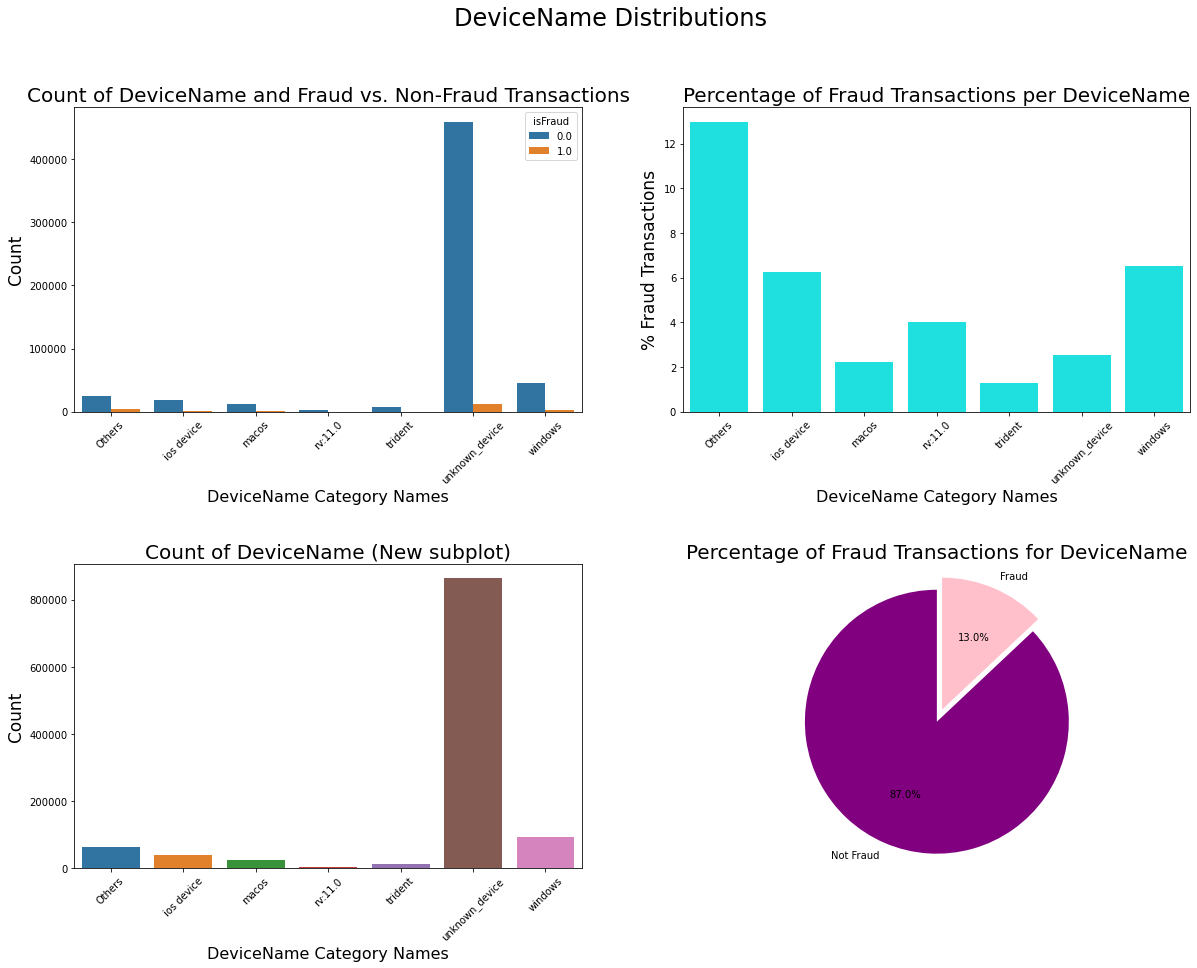

In [53]:
visualize_distributions(train_test, 'DeviceName')

## Exploring Group Features (card, C, D, M, V, id )

### card1-card6
* The host of the competition stated that some of the features are categorical even if they look numerical like card features.
* card1 - card6: payment card information, such as card type, card category, issue bank, country, etc.
* card4 and card6 have 4 unique values, and the others more than 100
* Except card1, card features have nan values ​​so I will group them according to card1 and fill with the most common value.

In [54]:
card_cols = [c for c in train.columns if c.startswith('card')]
card_cols

['card1', 'card2', 'card3', 'card4', 'card5', 'card6']

In [55]:
train[card_cols]

card1   card2   card3       card4   card5   card6
0       13926     NaN 150.000    discover 142.000  credit
1        2755 404.000 150.000  mastercard 102.000  credit
2        4663 490.000 150.000        visa 166.000   debit
3       18132 567.000 150.000  mastercard 117.000   debit
4        4497 514.000 150.000  mastercard 102.000  credit
...       ...     ...     ...         ...     ...     ...
590535   6550     NaN 150.000        visa 226.000   debit
590536  10444 225.000 150.000  mastercard 224.000   debit
590537  12037 595.000 150.000  mastercard 224.000   debit
590538   7826 481.000 150.000  mastercard 224.000   debit
590539  15066 170.000 150.000  mastercard 102.000  credit

[590540 rows x 6 columns]

In [56]:
train[card_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   card1   590540 non-null  int16  
 1   card2   581607 non-null  float32
 2   card3   588975 non-null  float32
 3   card4   588963 non-null  object 
 4   card5   586281 non-null  float32
 5   card6   588969 non-null  object 
dtypes: float32(3), int16(1), object(2)
memory usage: 37.5+ MB


In [57]:
train_test[card_cols].isnull().sum()

card1        0
card2    17587
card3     4567
card4     4663
card5     8806
card6     4578
dtype: int64

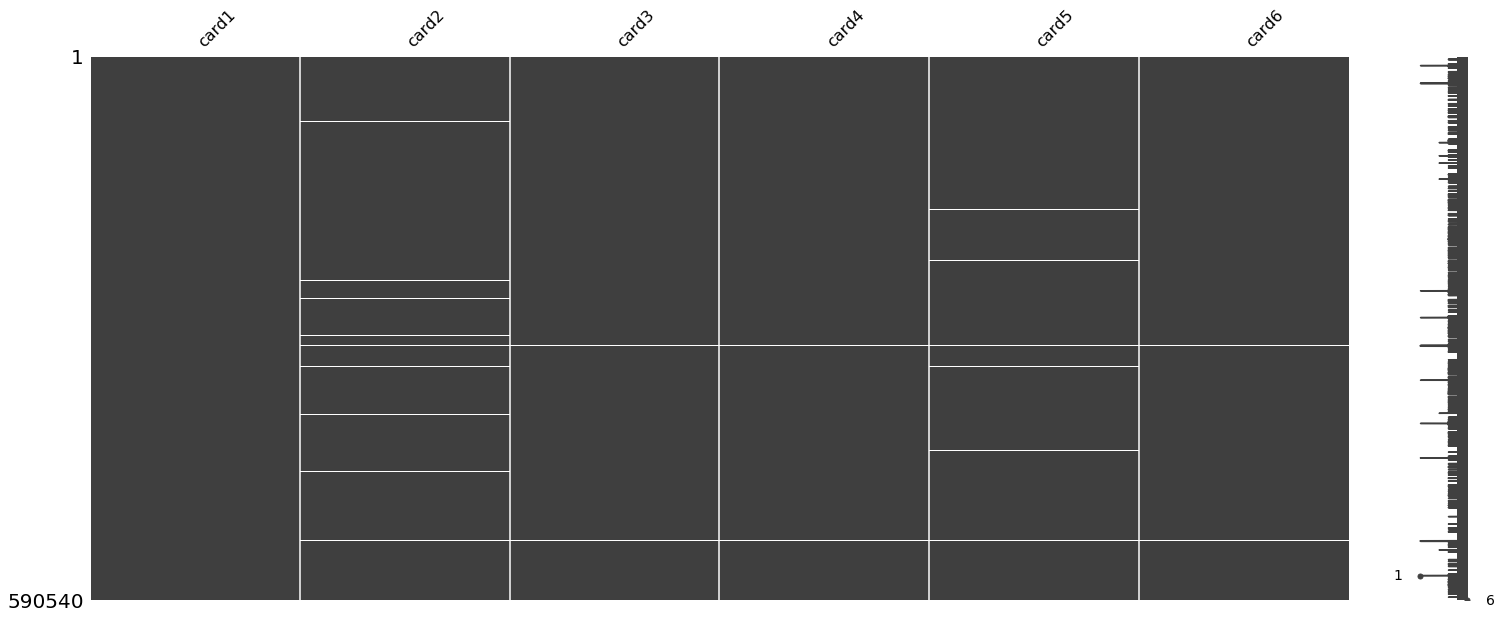

In [58]:
msno.matrix(train[card_cols]);

In [59]:
for i in range(len(card_cols)):
    print(card_cols[i]+" has "+ str(train[card_cols[i]].nunique()) + " unique value.")

card1 has 13553 unique value.
card2 has 500 unique value.
card3 has 114 unique value.
card4 has 4 unique value.
card5 has 119 unique value.
card6 has 4 unique value.


In [60]:
#filling missing values using median
for col in card_cols:
    mode_vals = train_test.groupby(['card1'])[col].transform(lambda x: x.mode())
    if not mode_vals.empty:
        train_test[col] = train_test[col].fillna(mode_vals.iat[0])
    else:
        train_test[col].fillna(train_test[col].mode()[0], inplace=True)

In [61]:
train_test[card_cols].isnull().sum()

card1    0
card2    0
card3    0
card4    0
card5    0
card6    0
dtype: int64

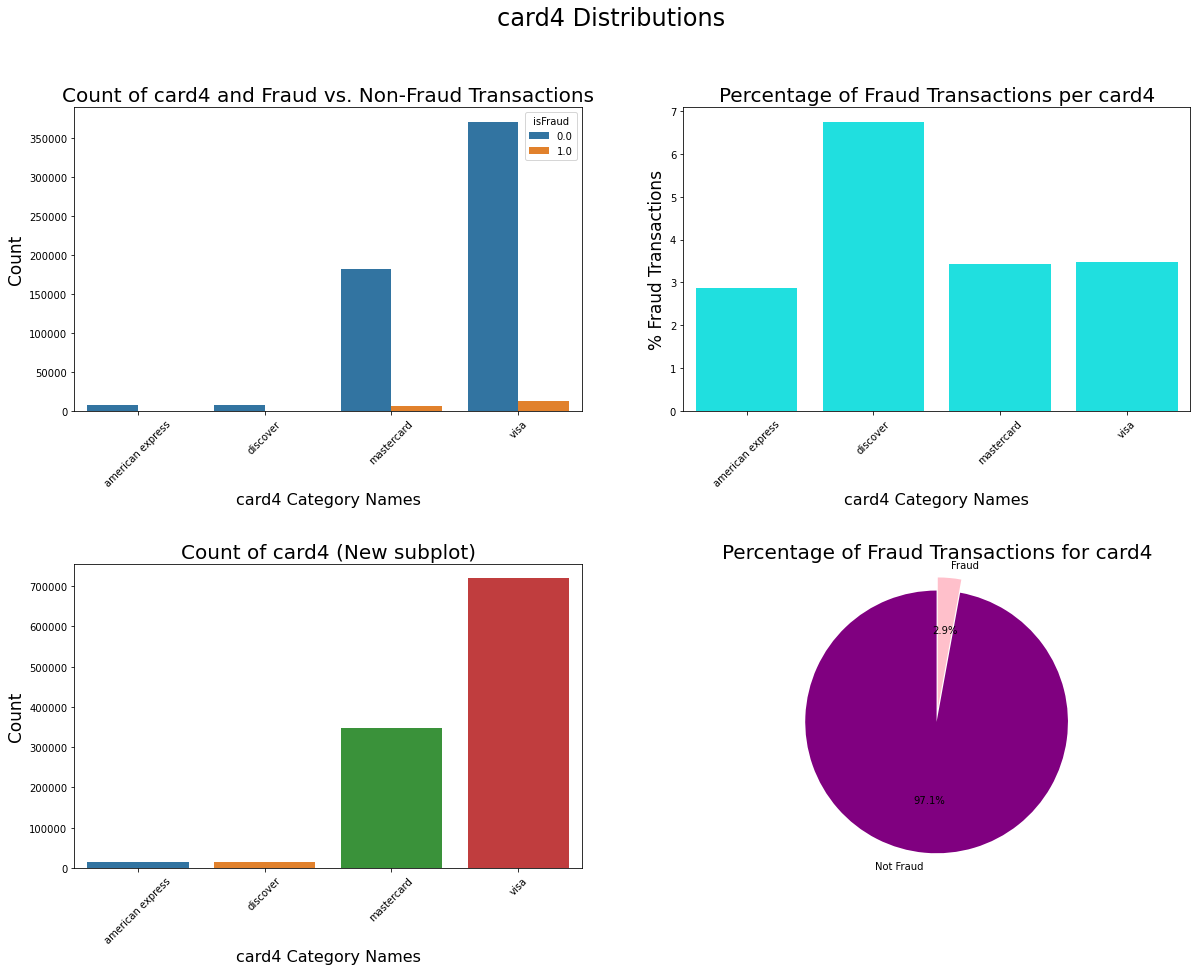

In [62]:
visualize_distributions(train_test, 'card4')

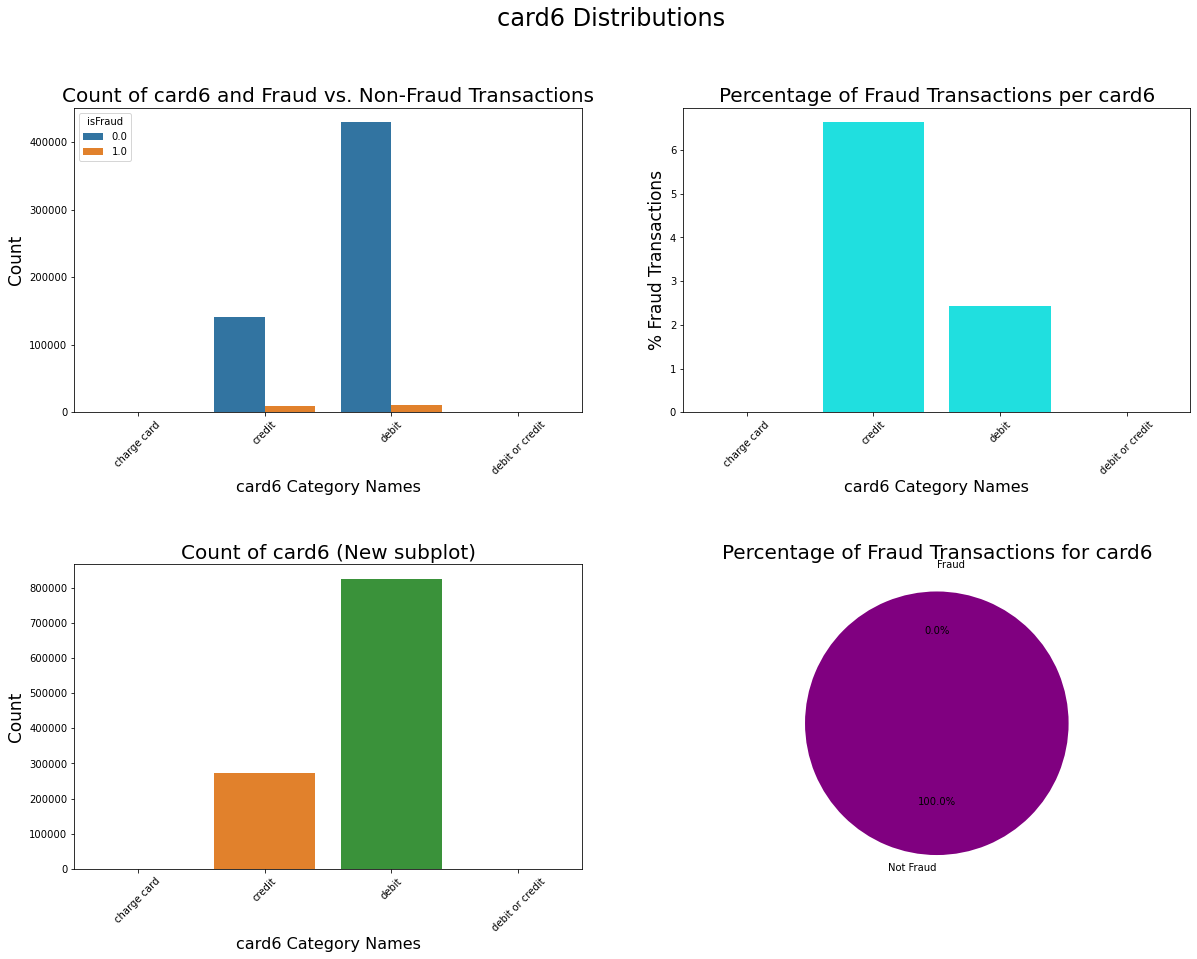

In [63]:
visualize_distributions(train_test, 'card6')

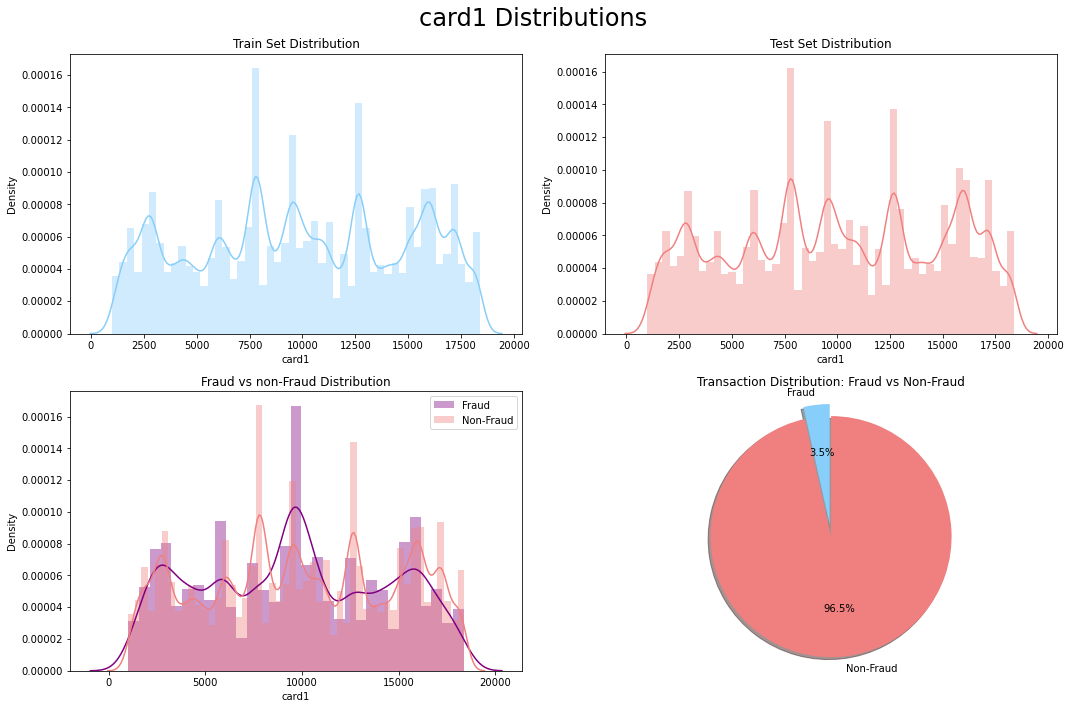

In [64]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "card1")

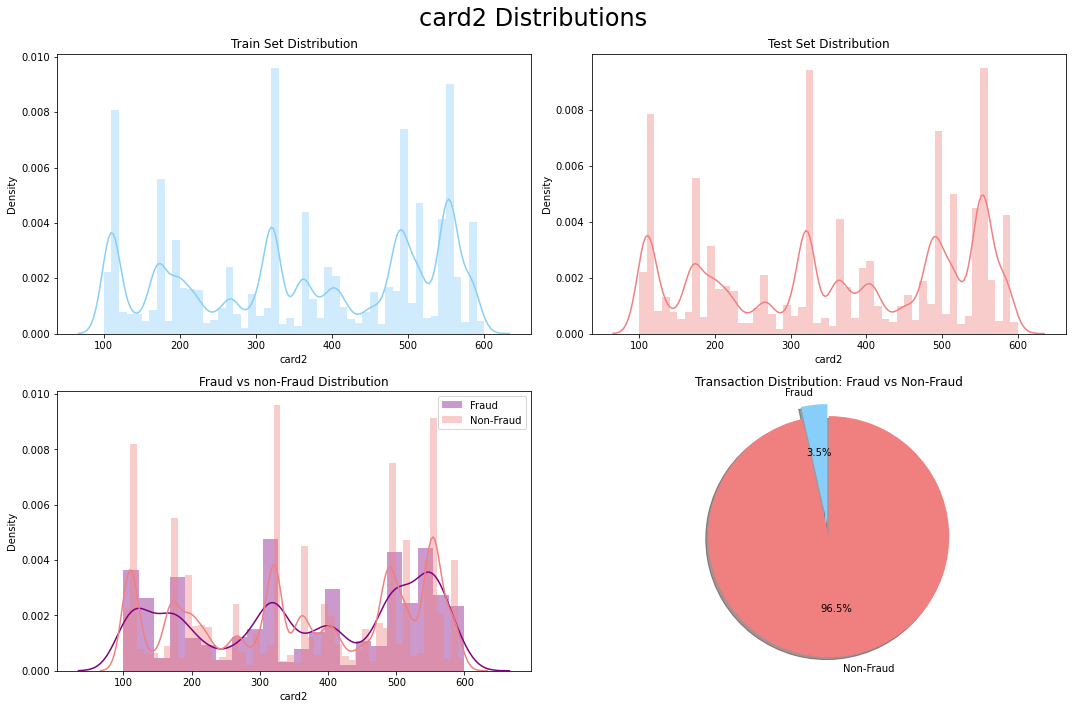

In [65]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "card2")

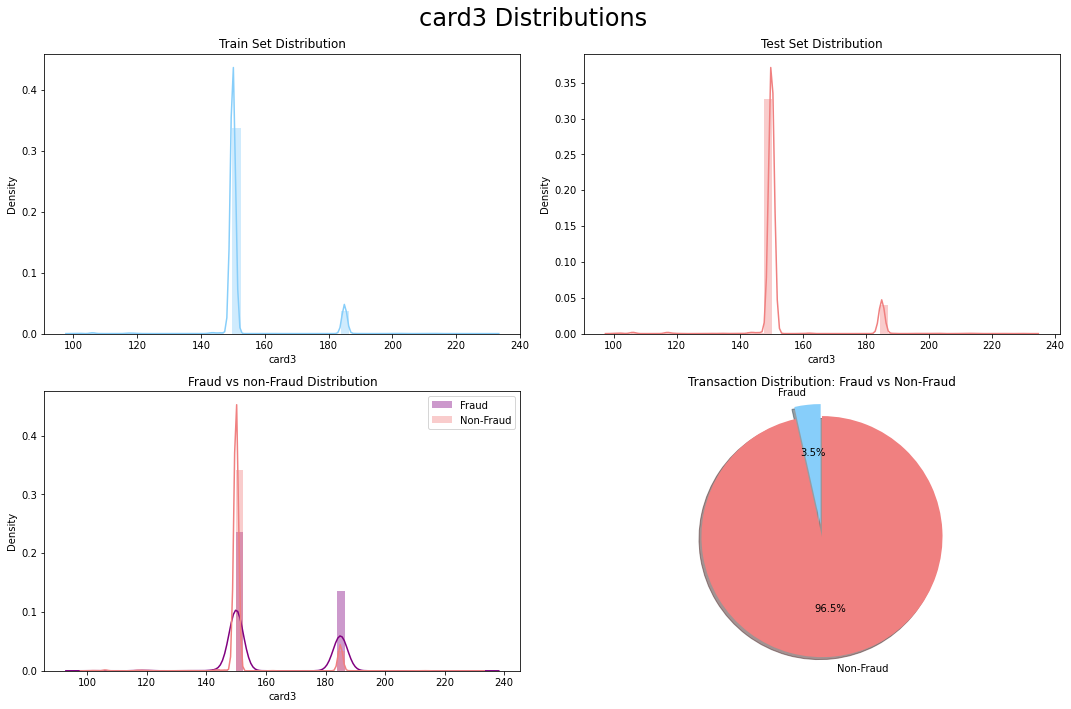

In [66]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "card3")

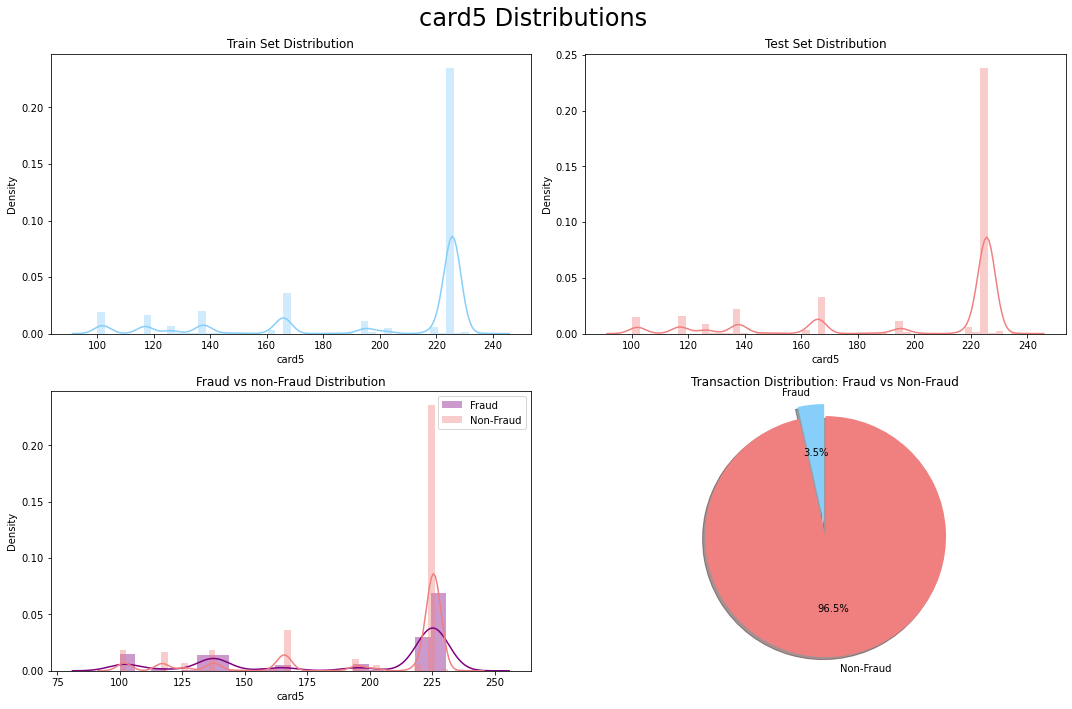

In [67]:
plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, "card5")

### C1-C14
* C1-C14: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked.
* All of the C features are continuous.

In [68]:
c_cols = [c for c in train.columns if c.startswith('C')]
c_cols

['C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14']

In [69]:
train[c_cols]

C1    C2    C3    C4    C5    C6    C7    C8    C9   C10   C11  \
0      1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 2.000   
1      1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 0.000 0.000 1.000   
2      1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000   
3      2.000 5.000 0.000 0.000 0.000 4.000 0.000 0.000 1.000 0.000 1.000   
4      1.000 1.000 0.000 0.000 0.000 1.000 0.000 1.000 0.000 1.000 1.000   
...      ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
590535 2.000 1.000 0.000 0.000 1.000 0.000 0.000 0.000 2.000 0.000 1.000   
590536 1.000 1.000 0.000 0.000 0.000 1.000 0.000 0.000 1.000 0.000 1.000   
590537 1.000 1.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 0.000 1.000   
590538 1.000 1.000 0.000 0.000 0.000 3.000 0.000 0.000 2.000 0.000 1.000   
590539 2.000 1.000 0.000 0.000 1.000 1.000 0.000 0.000 2.000 0.000 1.000   

         C12    C13   C14  
0      0.000  1.000 1.000  
1      0.000  1.000 1.000  
2      0.000  1.000 1.000  
3      0.000 25.000 1.000  
4      0.000  1.000 1.000  
...      ...    ...   ...  
590535 0.000  3.000 2.000  
590536 0.000  1.000 1.000  
590537 0.000  1.000 1.000  
590538 1.000  5.000 1.000  
590539 0.000  1.000 1.000  

[590540 rows x 14 columns]

In [70]:
train[c_cols].describe()

C1         C2         C3         C4         C5         C6  \
count 590540.000 590540.000 590540.000 590540.000 590540.000 590540.000   
mean      14.092     15.270      0.006      4.092      5.572      9.071   
std      133.093    154.179      0.150     68.751     25.801     71.158   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      0.000      1.000   
50%        1.000      1.000      0.000      0.000      0.000      1.000   
75%        3.000      3.000      0.000      0.000      1.000      2.000   
max     4684.000   5692.000     26.000   2252.000    349.000   2252.000   

              C7         C8         C9        C10        C11        C12  \
count 590540.000 590540.000 590540.000 590540.000 590540.000 590540.000   
mean       2.848      5.145      4.480      5.240     10.242      4.076   
std       61.671     95.263     16.705     95.461     93.986     86.587   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      0.000      0.000      0.000      1.000      0.000   
50%        0.000      0.000      1.000      0.000      1.000      0.000   
75%        0.000      0.000      2.000      0.000      2.000      0.000   
max     2256.000   3332.000    210.000   3256.000   3188.000   3188.000   

             C13        C14  
count 590540.000 590540.000  
mean      32.519      8.295  
std      129.430     49.268  
min        0.000      0.000  
25%        1.000      1.000  
50%        3.000      1.000  
75%       12.000      2.000  
max     2918.000   1429.000

In [71]:
train_test[c_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097231 entries, 0 to 1097230
Data columns (total 14 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   C1      1097228 non-null  float32
 1   C2      1097228 non-null  float32
 2   C3      1097228 non-null  float32
 3   C4      1097228 non-null  float32
 4   C5      1097228 non-null  float32
 5   C6      1097228 non-null  float32
 6   C7      1097228 non-null  float32
 7   C8      1097228 non-null  float32
 8   C9      1097228 non-null  float32
 9   C10     1097228 non-null  float32
 10  C11     1097228 non-null  float32
 11  C12     1097228 non-null  float32
 12  C13     1092483 non-null  float32
 13  C14     1097228 non-null  float32
dtypes: float32(14)
memory usage: 58.6 MB


### D1-D15
* The D Columns are "time deltas" from some point in the past.


In [72]:
d_cols = ['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10','D11','D12','D13','D14']
train[d_cols].head()

D1      D2     D3     D4    D5  D6  D7  D8  D9    D10     D11  D12  \
0  14.000     NaN 13.000    NaN   NaN NaN NaN NaN NaN 13.000  13.000  NaN   
1   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000     NaN  NaN   
2   0.000     NaN    NaN  0.000   NaN NaN NaN NaN NaN  0.000 315.000  NaN   
3 112.000 112.000  0.000 94.000 0.000 NaN NaN NaN NaN 84.000     NaN  NaN   
4   0.000     NaN    NaN    NaN   NaN NaN NaN NaN NaN    NaN     NaN  NaN   

   D13  D14  
0  NaN  NaN  
1  NaN  NaN  
2  NaN  NaN  
3  NaN  NaN  
4  NaN  NaN

In [73]:
train[d_cols].describe()

D1         D2         D3         D4         D5        D6  \
count 589271.000 309743.000 327662.000 421618.000 280699.000 73187.000   
mean      94.341    169.553     28.343    139.996     42.336    69.806   
std      157.754    177.297     62.394    191.033     88.994   143.659   
min        0.000      0.000      0.000   -122.000      0.000   -83.000   
25%        0.000     26.000      1.000      0.000      1.000     0.000   
50%        3.000     97.000      8.000     26.000     10.000     0.000   
75%      122.000    276.000     27.000    253.000     32.000    40.000   
max      640.000    640.000    819.000    869.000    819.000   873.000   

             D7        D8        D9        D10        D11       D12       D13  \
count 38917.000 74926.000 74926.000 514518.000 311253.000 64717.000 61952.000   
mean     41.639   146.088     0.561    123.977    146.618    54.038    17.901   
std      99.732   231.661     0.317    182.612    186.039   124.296    67.612   
min       0.000     0.000     0.000      0.000    -53.000   -83.000     0.000   
25%       0.000     0.958     0.208      0.000      0.000     0.000     0.000   
50%       0.000    37.875     0.667     15.000     43.000     0.000     0.000   
75%      17.000   188.000     0.833    197.000    274.000    13.000     0.000   
max     843.000  1708.000     0.958    876.000    670.000   648.000   847.000   

            D14  
count 62187.000  
mean     57.724  
std     136.304  
min    -193.000  
25%       0.000  
50%       0.000  
75%       2.000  
max     878.000

In [74]:
train[d_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   D1      589271 non-null  float32
 1   D2      309743 non-null  float32
 2   D3      327662 non-null  float32
 3   D4      421618 non-null  float32
 4   D5      280699 non-null  float32
 5   D6      73187 non-null   float32
 6   D7      38917 non-null   float32
 7   D8      74926 non-null   float32
 8   D9      74926 non-null   float32
 9   D10     514518 non-null  float32
 10  D11     311253 non-null  float32
 11  D12     64717 non-null   float32
 12  D13     61952 non-null   float32
 13  D14     62187 non-null   float32
dtypes: float32(14)
memory usage: 52.2 MB


In [75]:
train[d_cols].isnull().sum()

D1       1269
D2     280797
D3     262878
D4     168922
D5     309841
D6     517353
D7     551623
D8     515614
D9     515614
D10     76022
D11    279287
D12    525823
D13    528588
D14    528353
dtype: int64

In [76]:
import random
cute_palette = ['#FFD700', '#FF69B4', '#FFA500', '#FFC0CB', '#90EE90', '#00BFFF', '#FF7F50', '#BA55D3', '#00CED1', '#FF4500', '#87CEFA', '#FF8C00', '#9370DB', '#7FFFD4']
random_color = random.choice(cute_palette)

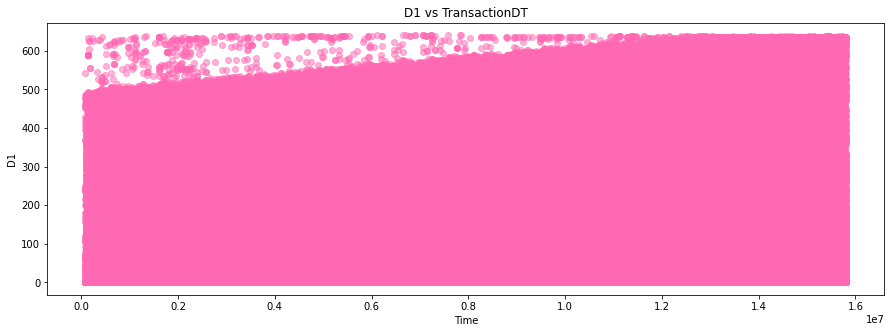

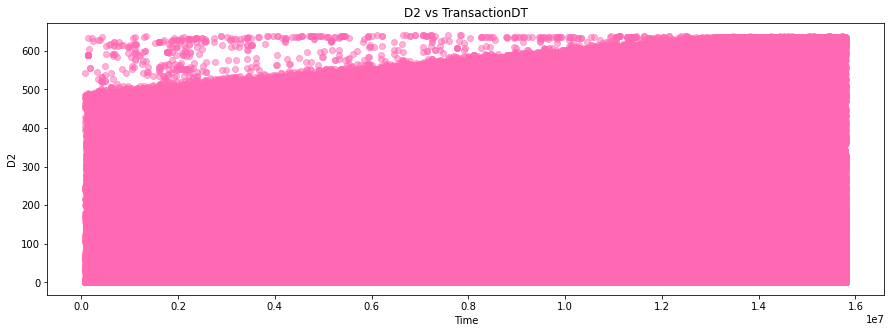

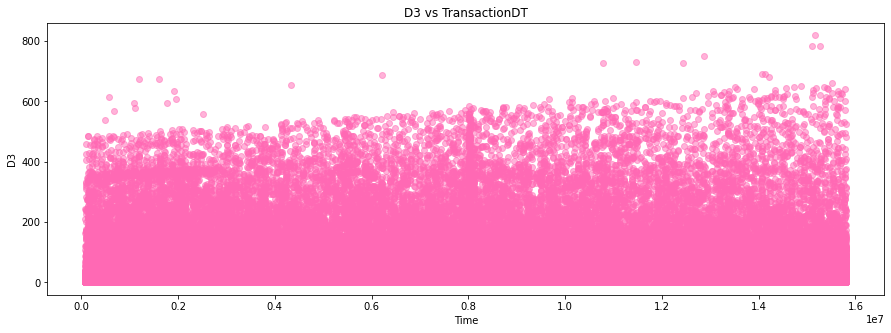

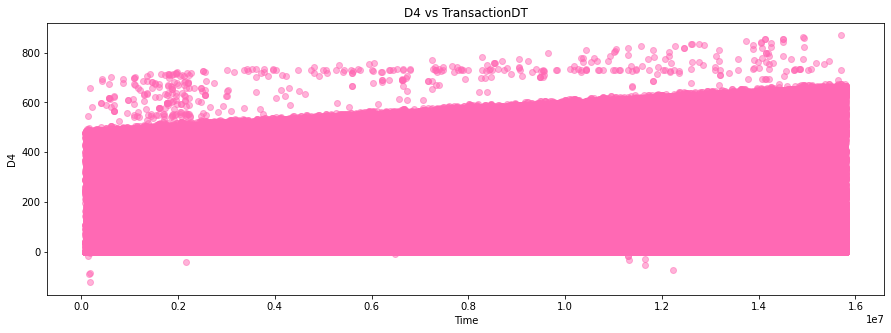

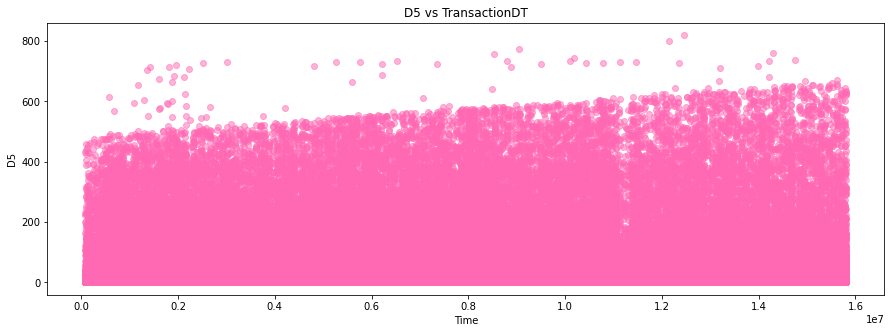

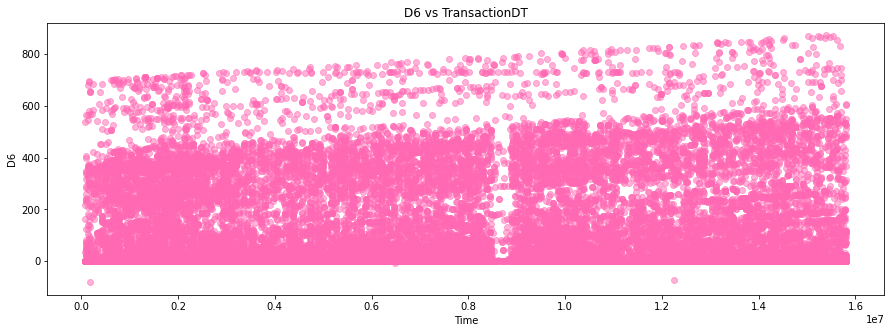

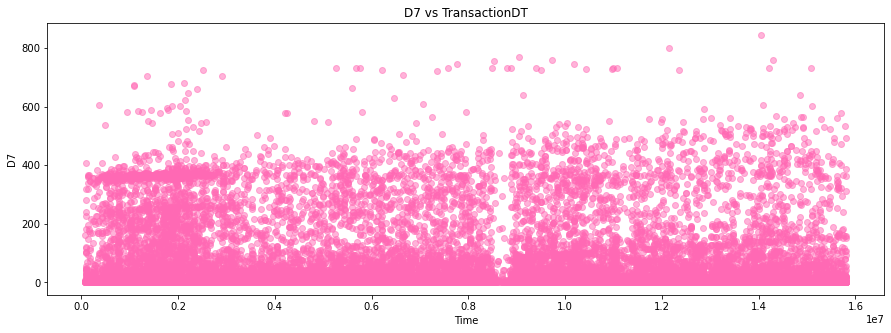

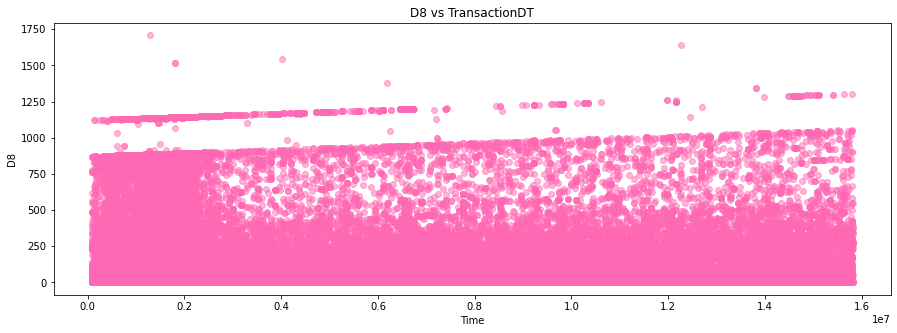

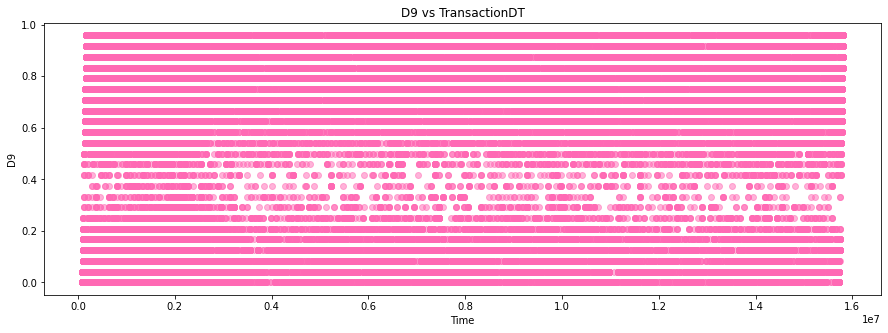

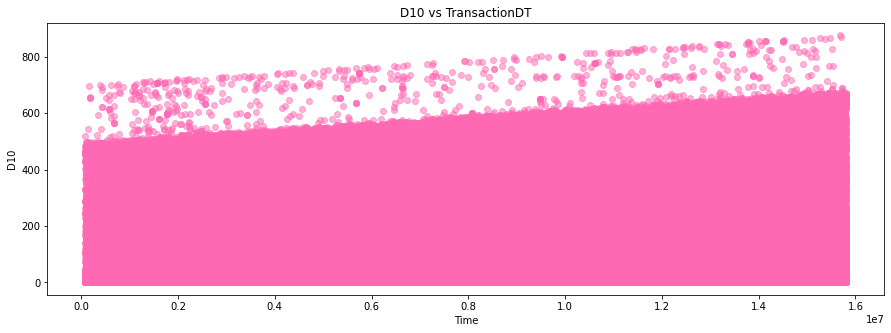

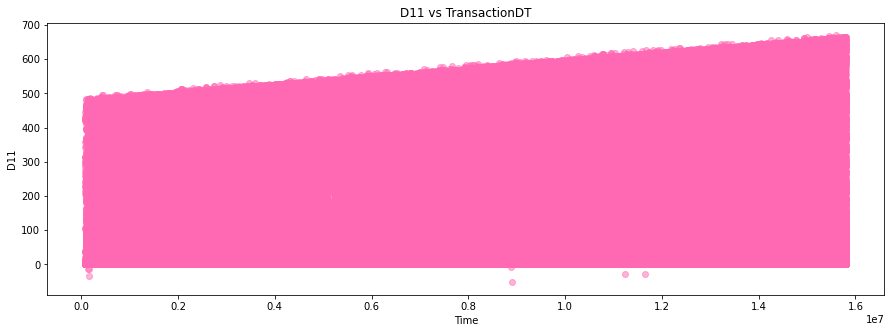

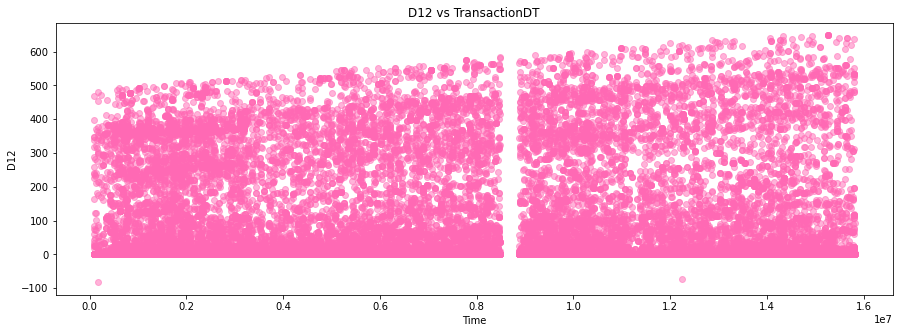

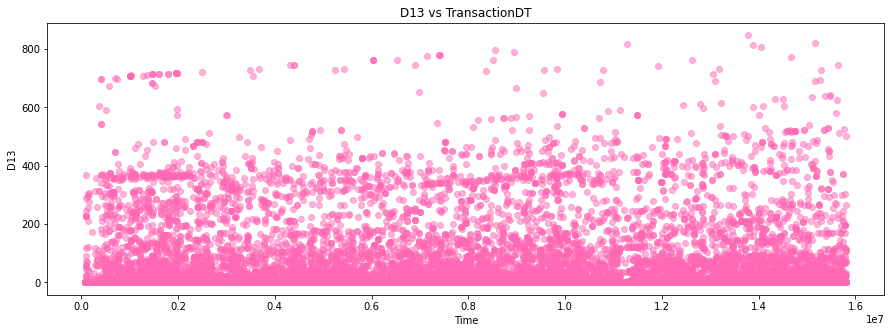

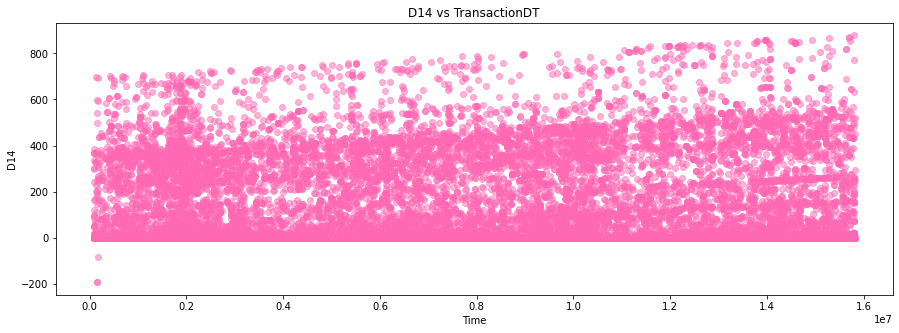

In [77]:
for col in d_cols:
    plt.figure(figsize=(15, 5))
    plt.scatter(train['TransactionDT'], train[col], color=random_color, alpha=0.5)
    plt.title(f'{col} vs TransactionDT')
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.show()

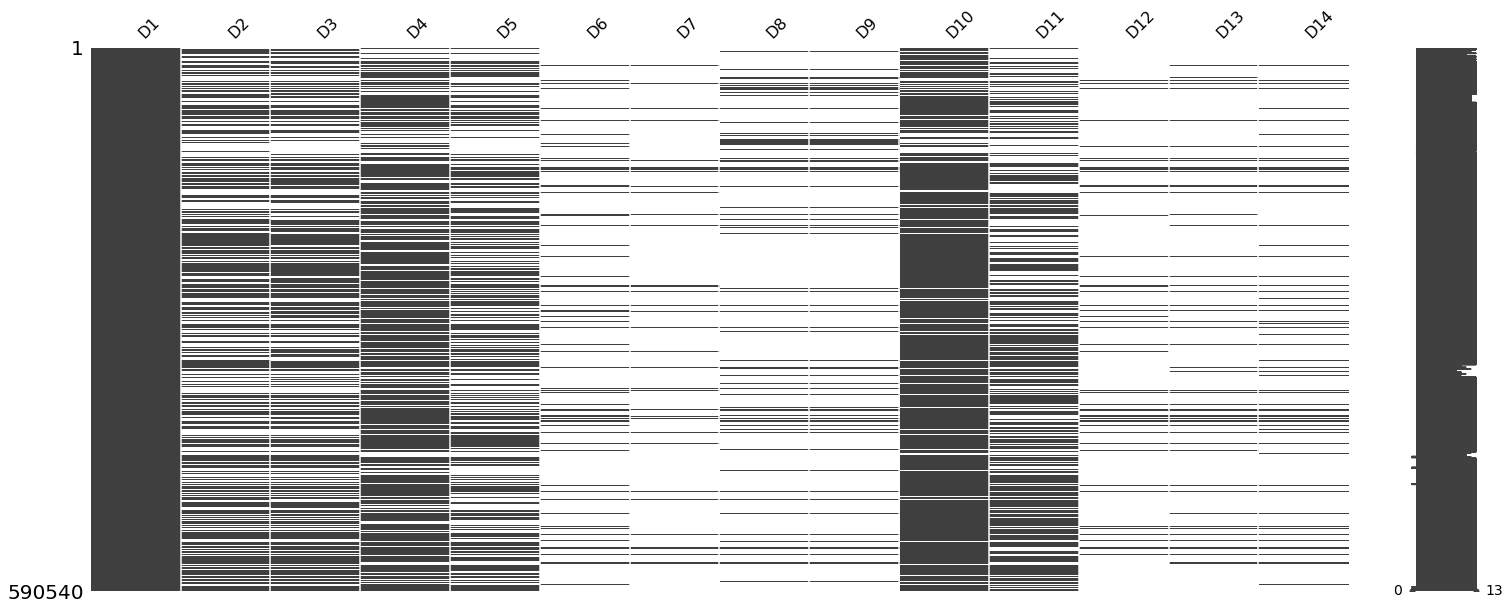

In [78]:
msno.matrix(train[d_cols]);

### M1-M9
* M1-M9 : match, such as names on card and address, etc.
* All of the M features are categorical.
* Values are T F or NaN except M4.
* M4 feature appears to be different from others.

In [79]:
m_cols = [c for c in train.columns if c.startswith('M')]

In [80]:
train[m_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 0 to 590539
Data columns (total 9 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   M1      319440 non-null  object
 1   M2      319440 non-null  object
 2   M3      319440 non-null  object
 3   M4      309096 non-null  object
 4   M5      240058 non-null  object
 5   M6      421180 non-null  object
 6   M7      244275 non-null  object
 7   M8      244288 non-null  object
 8   M9      244288 non-null  object
dtypes: object(9)
memory usage: 61.2+ MB


In [81]:
train[m_cols].isnull().sum()

M1    271100
M2    271100
M3    271100
M4    281444
M5    350482
M6    169360
M7    346265
M8    346252
M9    346252
dtype: int64

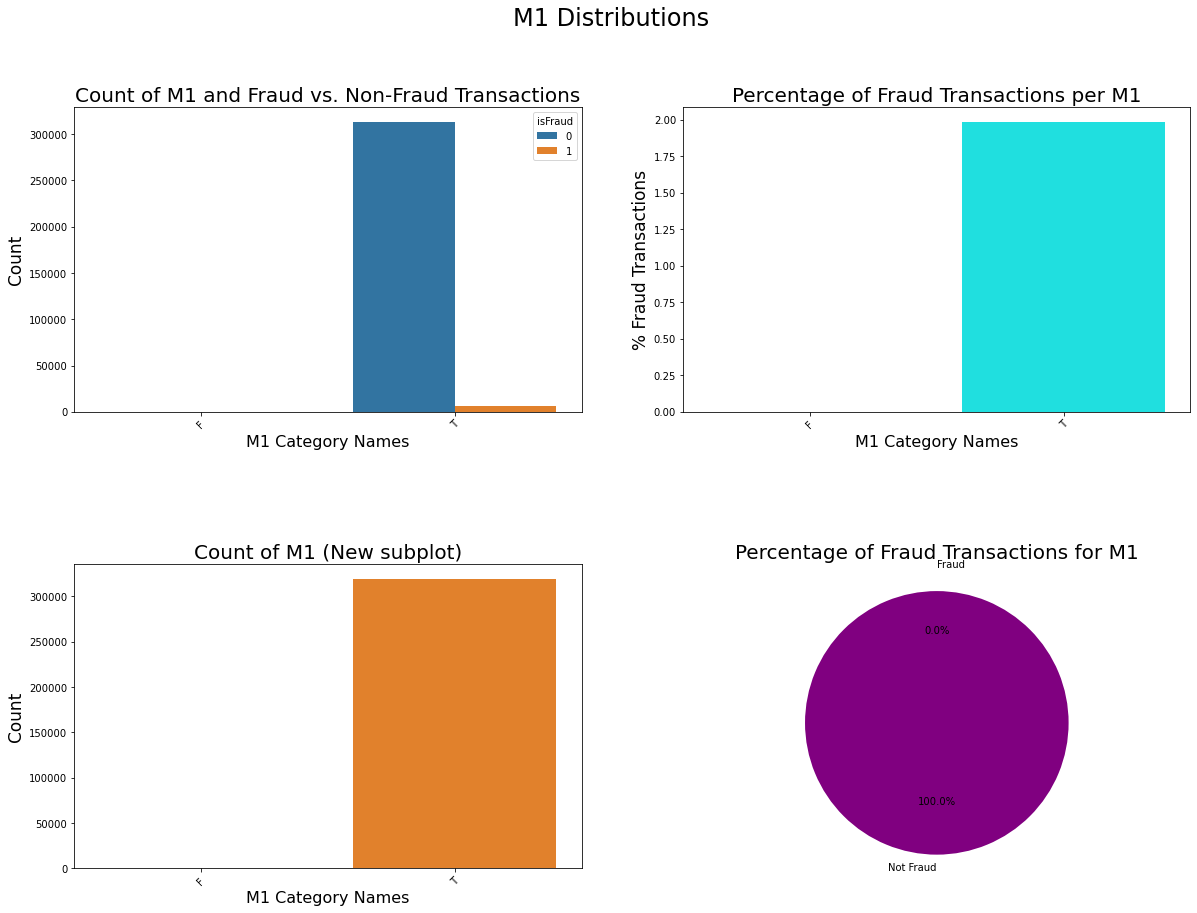

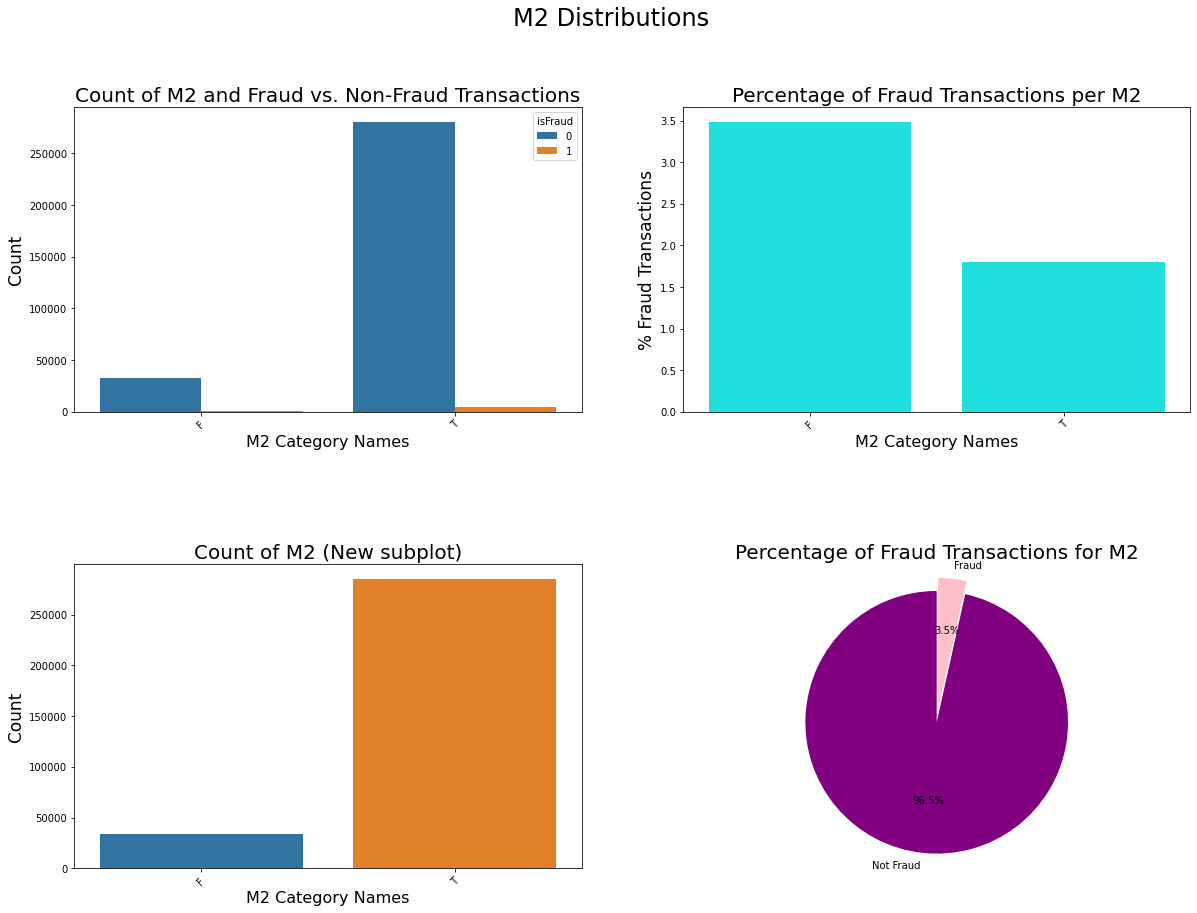

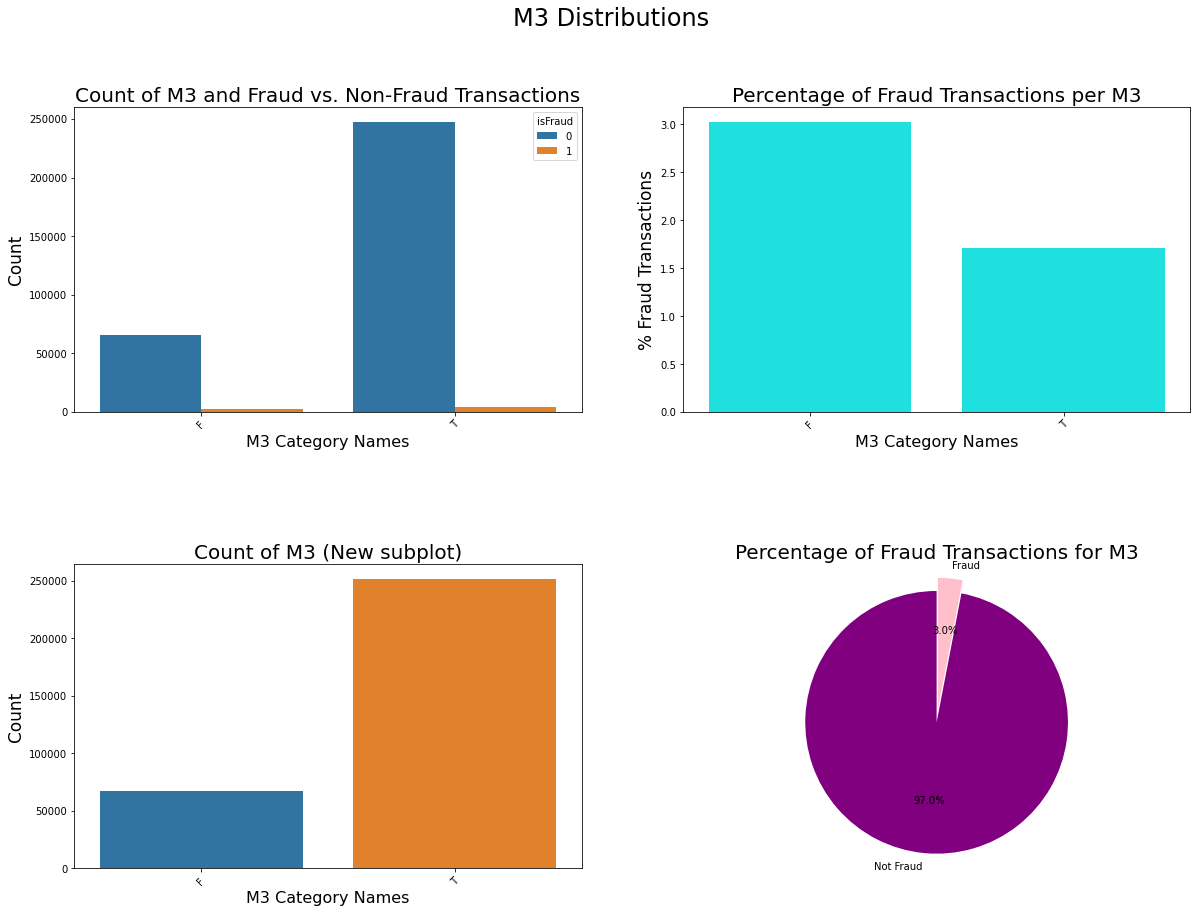

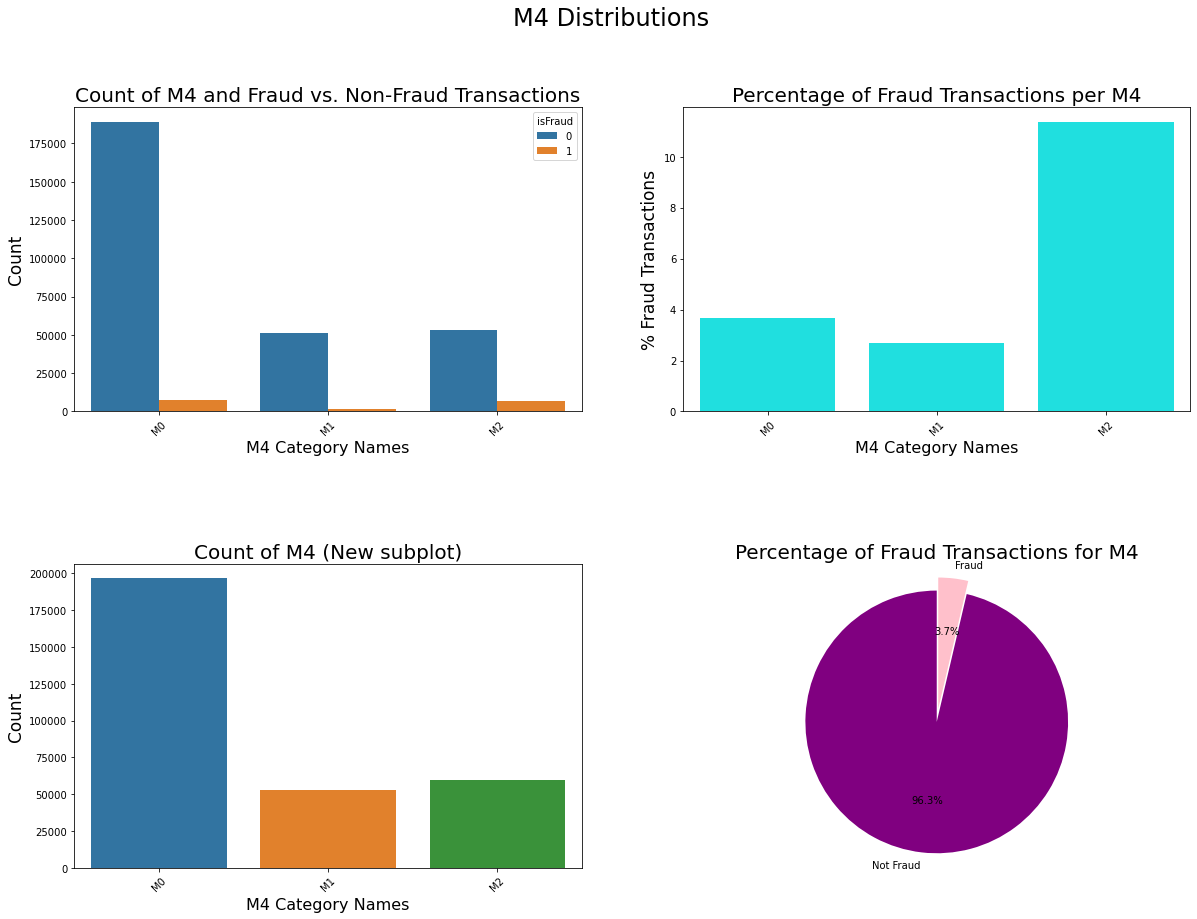

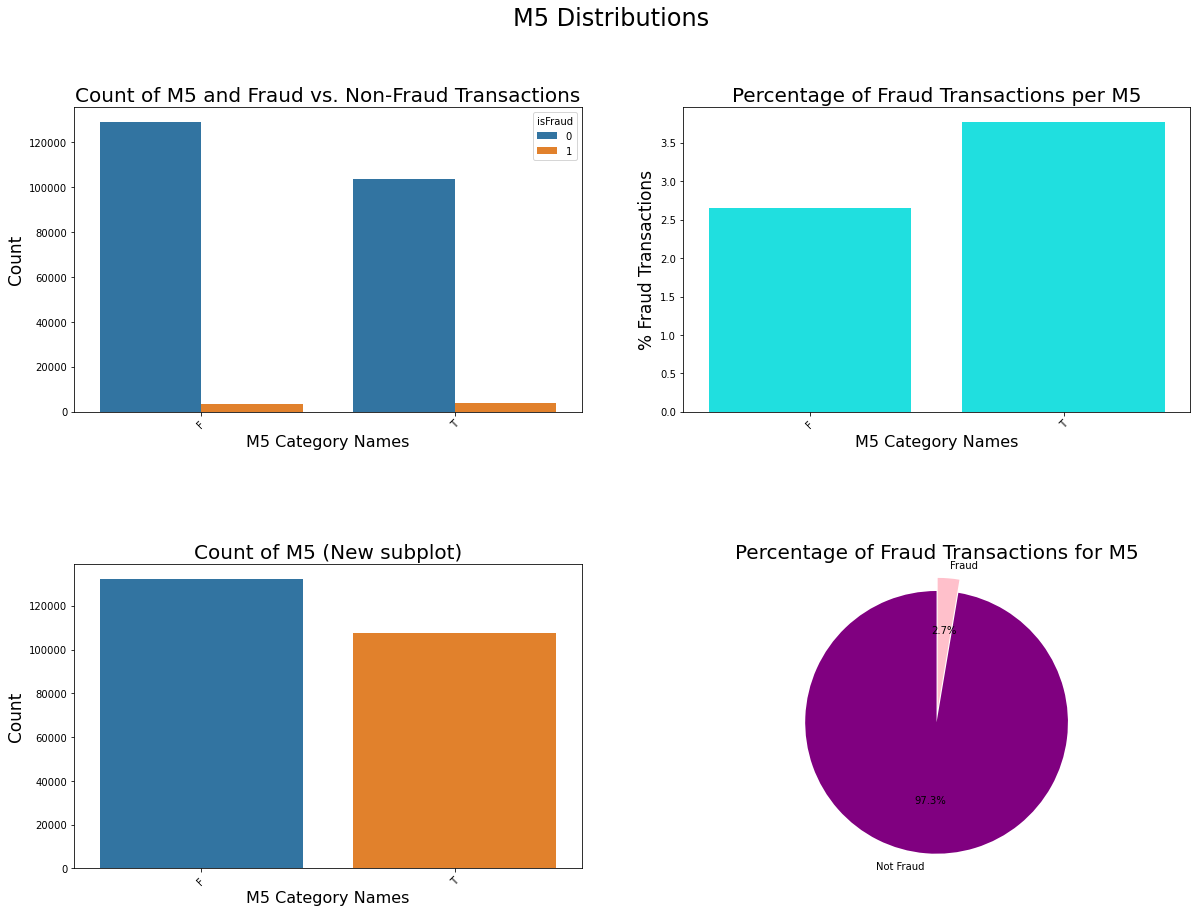

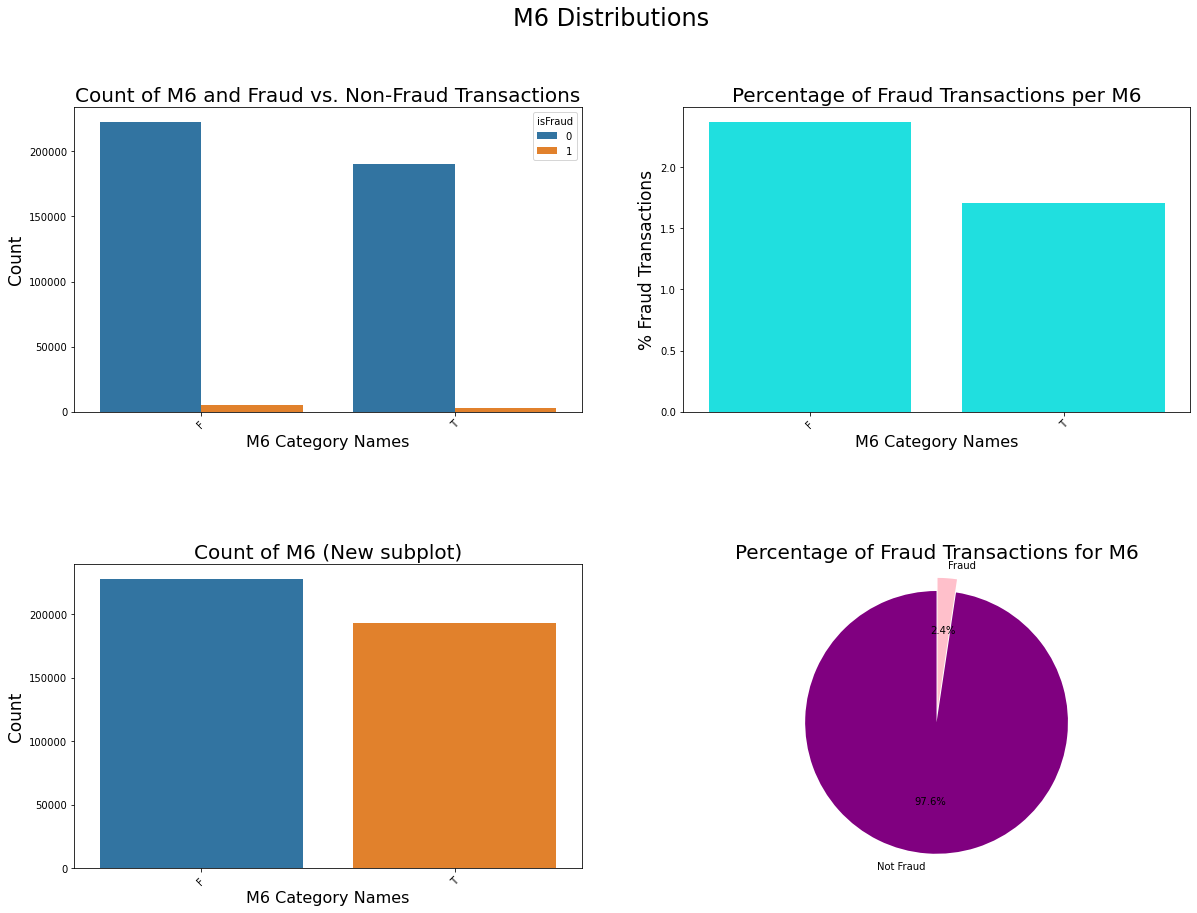

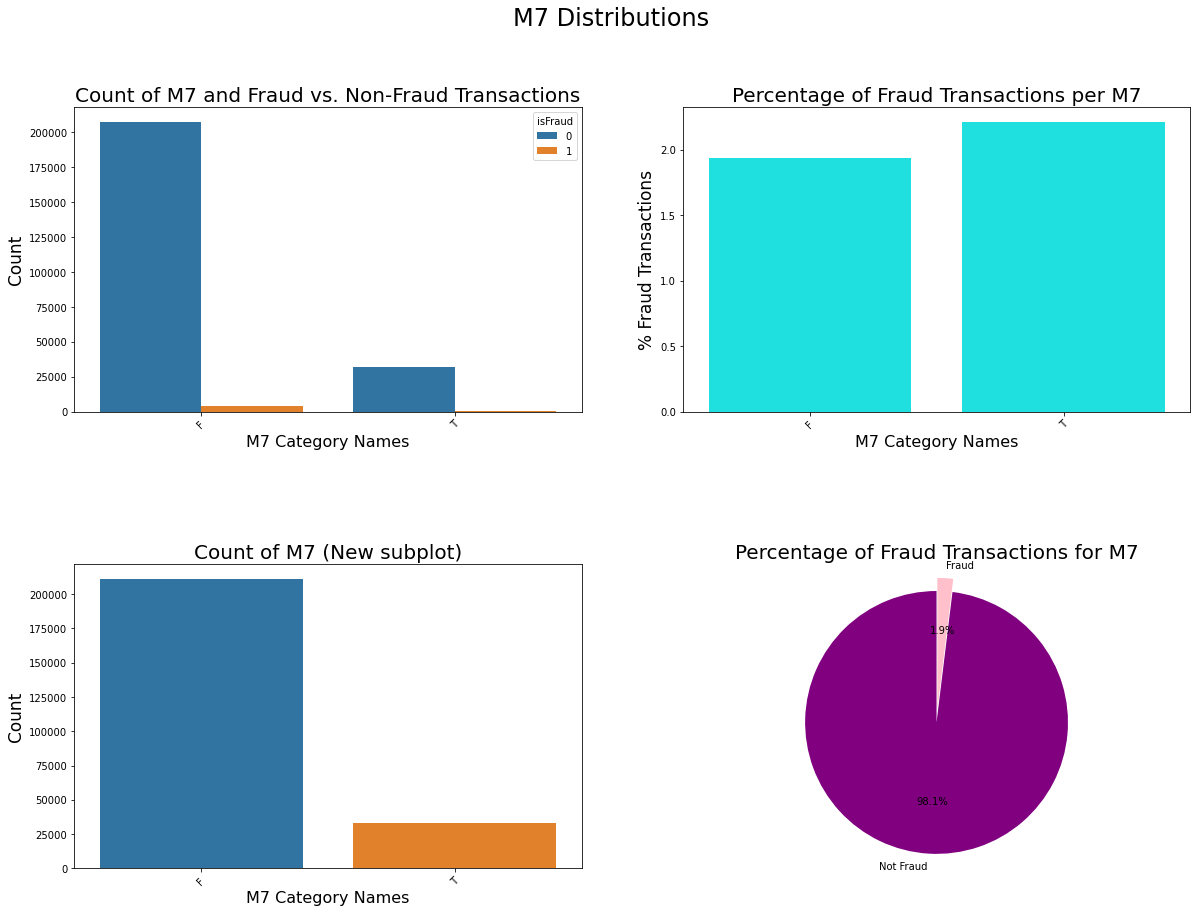

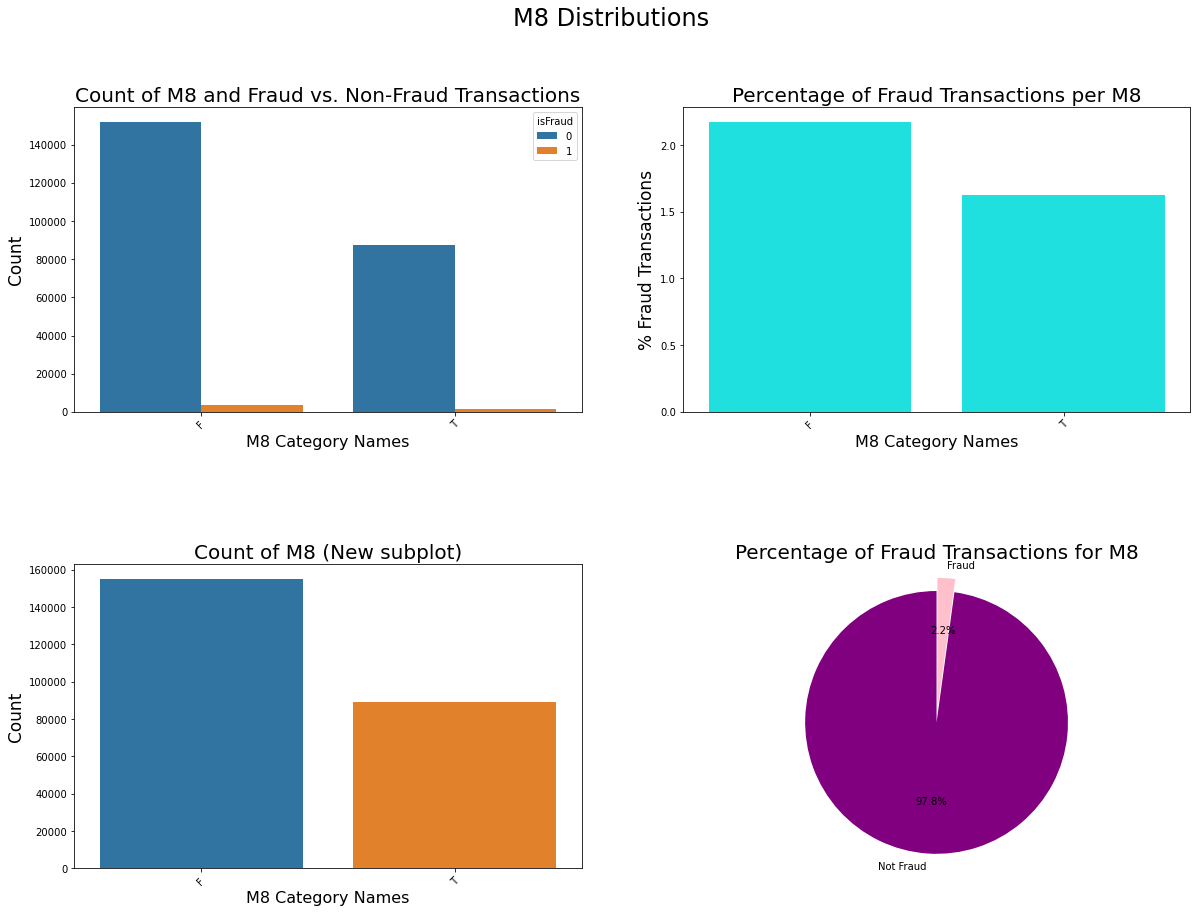

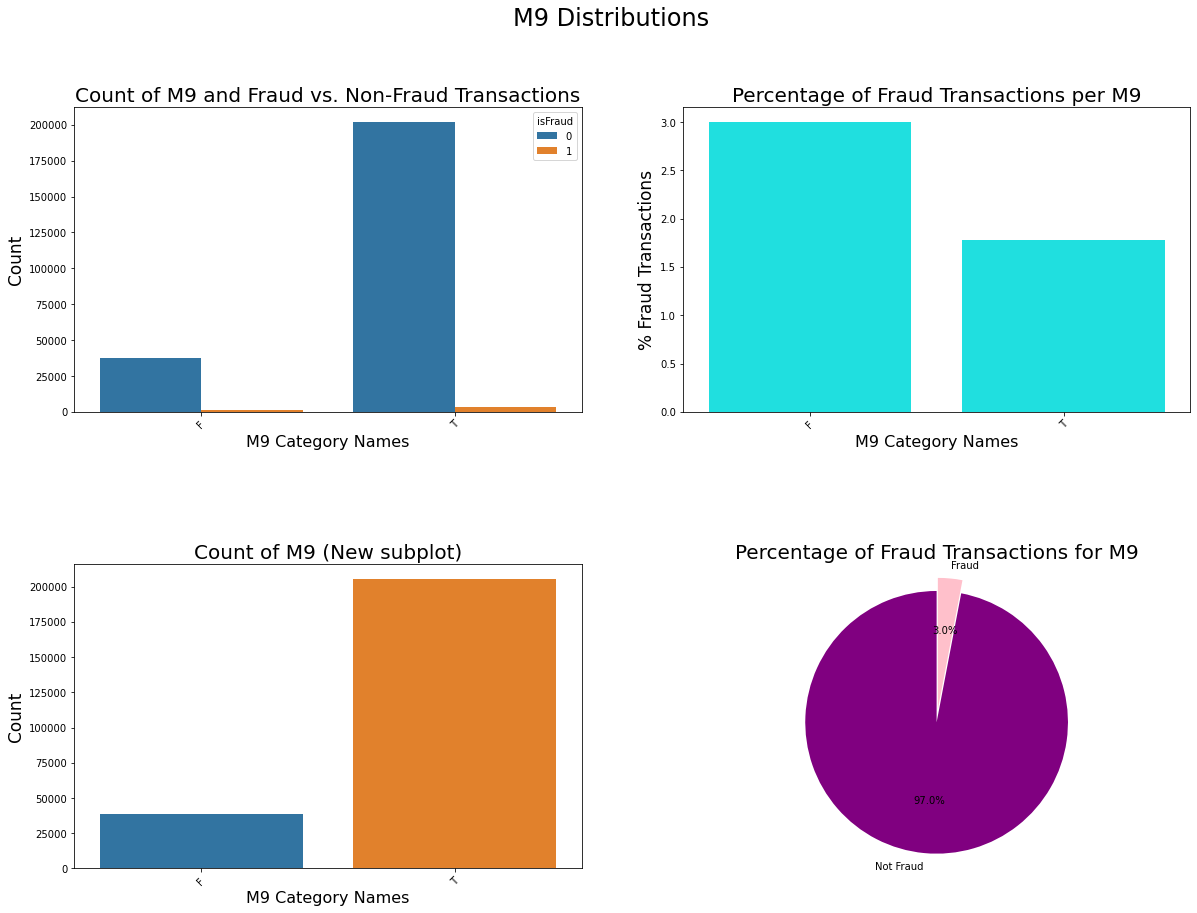

In [82]:
for col in m_cols:
    visualize_distributions(train, col)

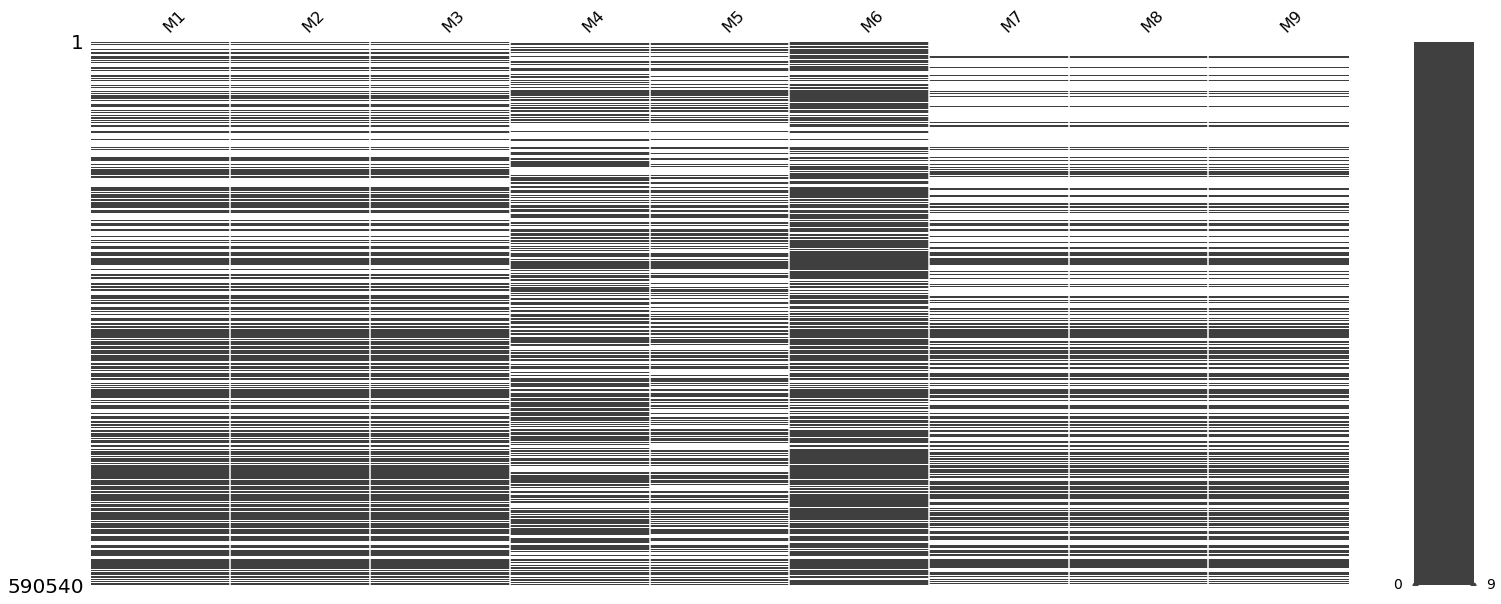

In [83]:
msno.matrix(train[m_cols]);

### V1-V339
* Vxxx: Vesta engineered rich features, including ranking, counting, and other entity relations.
* I will group the v features that have a similar number of nan observations.

In [84]:
v_cols = [v for v in train.columns if v.startswith('V')]
train[v_cols].head()

V1    V2    V3    V4    V5    V6    V7    V8    V9   V10   V11   V12  \
0 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000 0.000 1.000   
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 0.000   
2 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 1.000 0.000 0.000 1.000   
3   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V13   V14   V15   V16   V17   V18   V19   V20   V21   V22   V23   V24  \
0 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
1 0.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
2 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
3 1.000 1.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V25   V26   V27   V28   V29   V30   V31   V32   V33   V34   V35   V36  \
0 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   NaN   NaN   
1 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000   
2 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000   
3 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V37   V38   V39   V40   V41   V42   V43   V44   V45   V46   V47   V48  \
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
1 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
2 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
3 1.000 1.000 0.000 0.000 1.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V49   V50   V51   V52   V53   V54   V55   V56   V57   V58   V59   V60  \
0   NaN   NaN   NaN   NaN 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 0.000 0.000   
2 0.000 0.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
3 0.000 0.000 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V61   V62   V63   V64   V65   V66   V67   V68   V69   V70   V71   V72  \
0 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
1 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
2 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
3 1.000 1.000 0.000 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V73   V74   V75   V76   V77   V78   V79   V80   V81   V82   V83   V84  \
0 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000   
1 0.000 0.000 0.000 0.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
2 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
3 0.000 0.000 1.000 1.000 1.000 1.000 0.000 0.000 0.000 1.000 1.000 0.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   

    V85   V86   V87   V88   V89   V90   V91   V92   V93   V94   V95    V96  \
0 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  1.000   
1 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000   
2 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000  0.000   
3 0.000 1.000 1.000 1.000 0.000 0.000 0.000 0.000 0.000 0.000 1.000 48.000   
4   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN 0.000  0.000   

     V97   V98    V99  V100  V101   V102   V103  V104  V105  V106  V107  V108  \
0  0.000 0.000  0.000 0.000 0.000  1.000  0.000 0.000 0.000 0.000 1.000 1.000   
1  0.000 0.000  0.000 0.000 0.000  0.000  0.000 0.000 0.000 0.000 1.000 1.000   
2  0.000 0.000  0.000 0.000 0.000  0.000  0.000 0.00

In [85]:
train[v_cols].describe()

V1         V2         V3         V4         V5         V6  \
count 311253.000 311253.000 311253.000 311253.000 311253.000 311253.000   
mean       1.000      1.045      1.078      0.846      0.877      1.046   
std        0.007      0.240      0.321      0.440      0.476      0.239   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      1.000      1.000      1.000      1.000   
50%        1.000      1.000      1.000      1.000      1.000      1.000   
75%        1.000      1.000      1.000      1.000      1.000      1.000   
max        1.000      8.000      9.000      6.000      6.000      9.000   

              V7         V8         V9        V10        V11        V12  \
count 311253.000 311253.000 311253.000 311253.000 311253.000 514467.000   
mean       1.073      1.028      1.042      0.464      0.479      0.560   
std        0.305      0.186      0.227      0.522      0.552      0.511   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      1.000      0.000      0.000      0.000   
50%        1.000      1.000      1.000      0.000      0.000      1.000   
75%        1.000      1.000      1.000      1.000      1.000      1.000   
max        9.000      8.000      8.000      4.000      5.000      3.000   

             V13        V14        V15        V16        V17        V18  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.599      1.000      0.122      0.123      0.134      0.135   
std        0.533      0.022      0.333      0.343      0.365      0.372   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      1.000      0.000      0.000      0.000      0.000   
50%        1.000      1.000      0.000      0.000      0.000      0.000   
75%        1.000      1.000      0.000      0.000      0.000      0.000   
max        6.000      1.000      7.000     15.000     15.000     15.000   

             V19        V20        V21        V22        V23        V24  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.816      0.848      0.130      0.132      1.035      1.058   
std        0.425      0.460      0.339      0.358      0.248      0.306   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      1.000      1.000   
50%        1.000      1.000      0.000      0.000      1.000      1.000   
75%        1.000      1.000      0.000      0.000      1.000      1.000   
max        7.000     15.000      5.000      8.000     13.000     13.000   

             V25        V26        V27        V28        V29        V30  \
count 514467.000 514467.000 514467.000 514467.000 514467.000 514467.000   
mean       0.978      0.988      0.001      0.001      0.388      0.406   
std        0.185      0.209      0.029      0.031      0.511      0.555   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        1.000      1.000      0.000      0.000      0.000      0.000   
50%        1.000      1.000      0.000      0.000      0.000      0.000   
75%        1.000      1.000      0.000      0.000      1.000      1.000   
max        7.000     13.000      4.000      4.000      5.000      9.000   

             V31        V32        V33        V34        V35        V36  \
count 514467.000 514467.000 514467.000 514467.000 421571.000 421571.000   
mean       0.141      0.142      0.131      0.139      0.543      0.579   
std        0.355      0.368      0.340      0.358      0.517      0.540   
min        0.000      0.000      0.000      0.000      0.000      0.000   
25%        0.000      0.000      0.000      0.000      0.000      0.000   
50%        0.000      0.000      0.000      0.000      1.000      1.000   
75%        0.000      0.000      0.000      0.000      1.000      1.000   
max        7.000     15.000      7

In [86]:
train[v_cols].isnull().sum()

V1      279287
V2      279287
V3      279287
V4      279287
V5      279287
V6      279287
V7      279287
V8      279287
V9      279287
V10     279287
V11     279287
V12      76073
V13      76073
V14      76073
V15      76073
V16      76073
V17      76073
V18      76073
V19      76073
V20      76073
V21      76073
V22      76073
V23      76073
V24      76073
V25      76073
V26      76073
V27      76073
V28      76073
V29      76073
V30      76073
V31      76073
V32      76073
V33      76073
V34      76073
V35     168969
V36     168969
V37     168969
V38     168969
V39     168969
V40     168969
V41     168969
V42     168969
V43     168969
V44     168969
V45     168969
V46     168969
V47     168969
V48     168969
V49     168969
V50     168969
V51     168969
V52     168969
V53      77096
V54      77096
V55      77096
V56      77096
V57      77096
V58      77096
V59      77096
V60      77096
V61      77096
V62      77096
V63      77096
V64      77096
V65      77096
V66      77096
V67      7

In [87]:
v_cols = [c for c in train_test if c[0] == 'V']
v_nan_df = train_test[v_cols].isna()
nan_groups={}

for col in v_cols:
    cur_group = v_nan_df[col].sum()
    try:
        nan_groups[cur_group].append(col)
    except:
        nan_groups[cur_group]=[col]
del v_nan_df; x=gc.collect()

In [88]:
def plot_corr(columns):
    cols = columns + ['TransactionDT']
    corr_matrix = train[cols].corr()

    # Create a mask to hide the lower triangle
    mask = np.tri(*corr_matrix.shape, k=-1).T

    plt.figure(figsize=(15, 15))
    sns.heatmap(corr_matrix, mask=mask, cmap='magma_r', annot=True, center=0.0)
    plt.title(v_cols[0] + ' - ' + v_cols[-1], fontsize=14)
    plt.show()

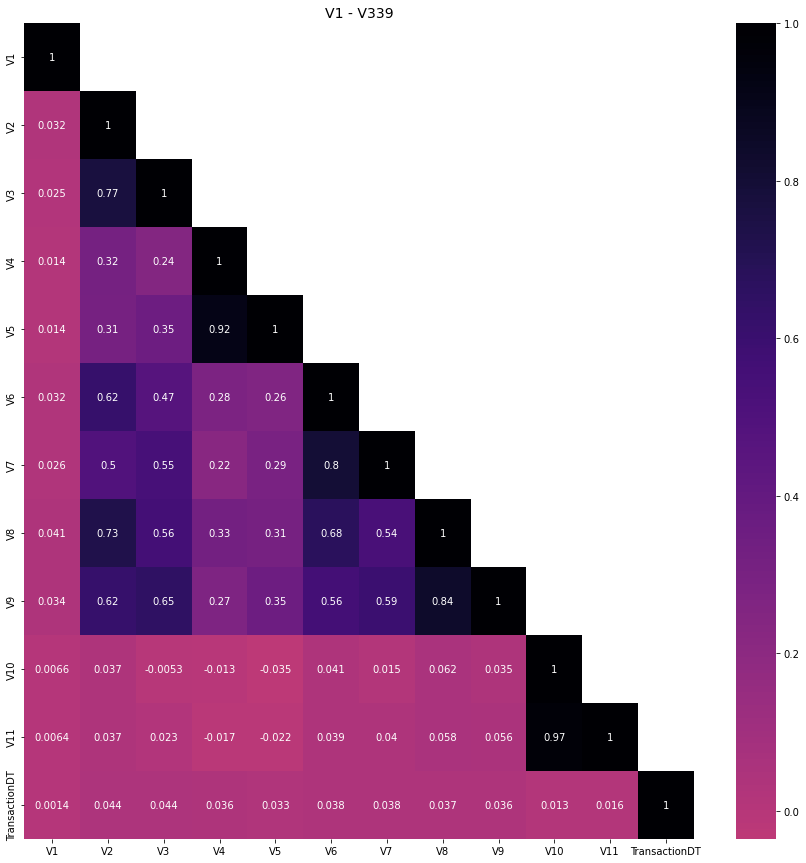

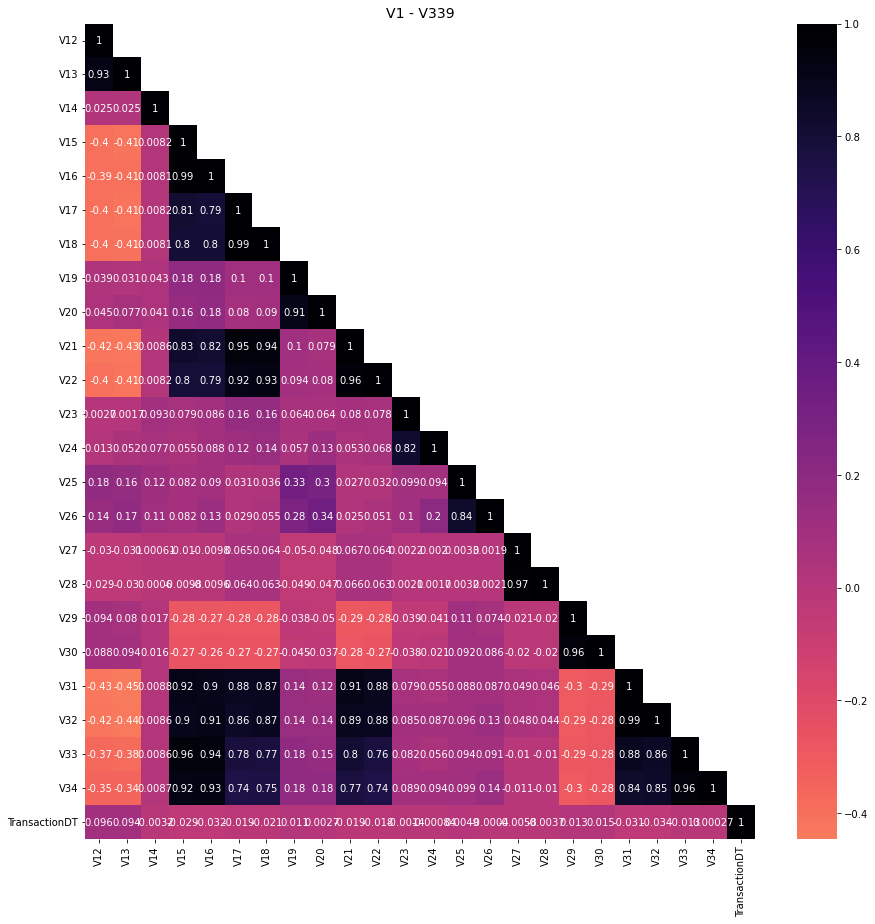

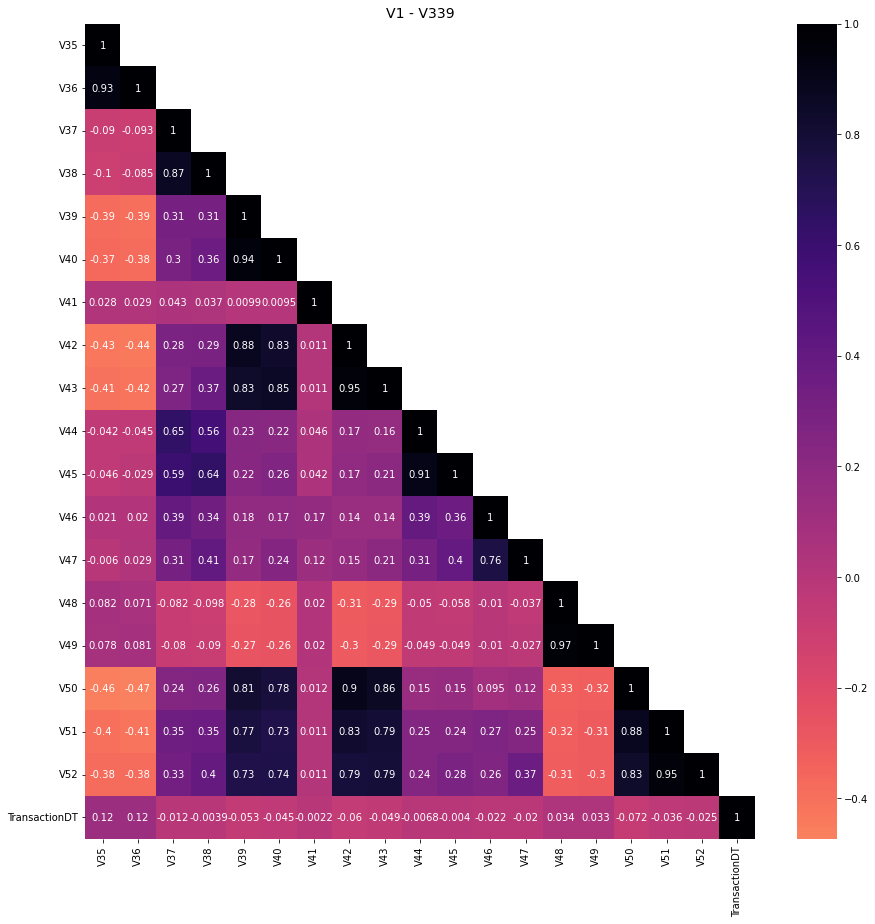

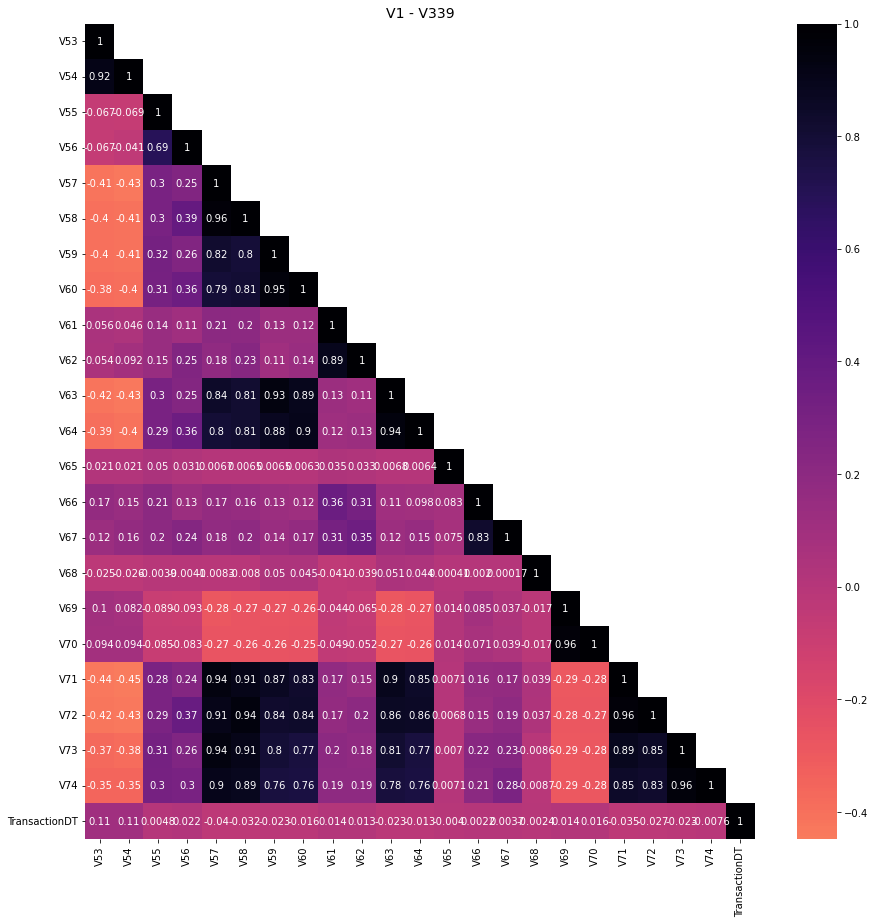

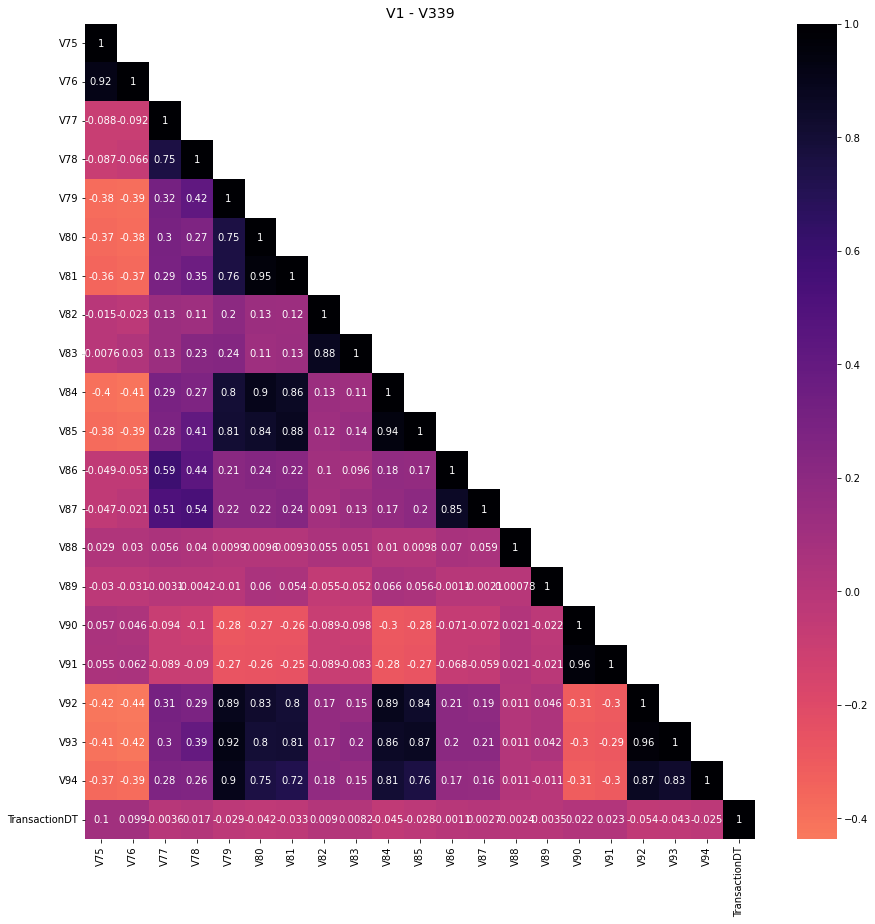

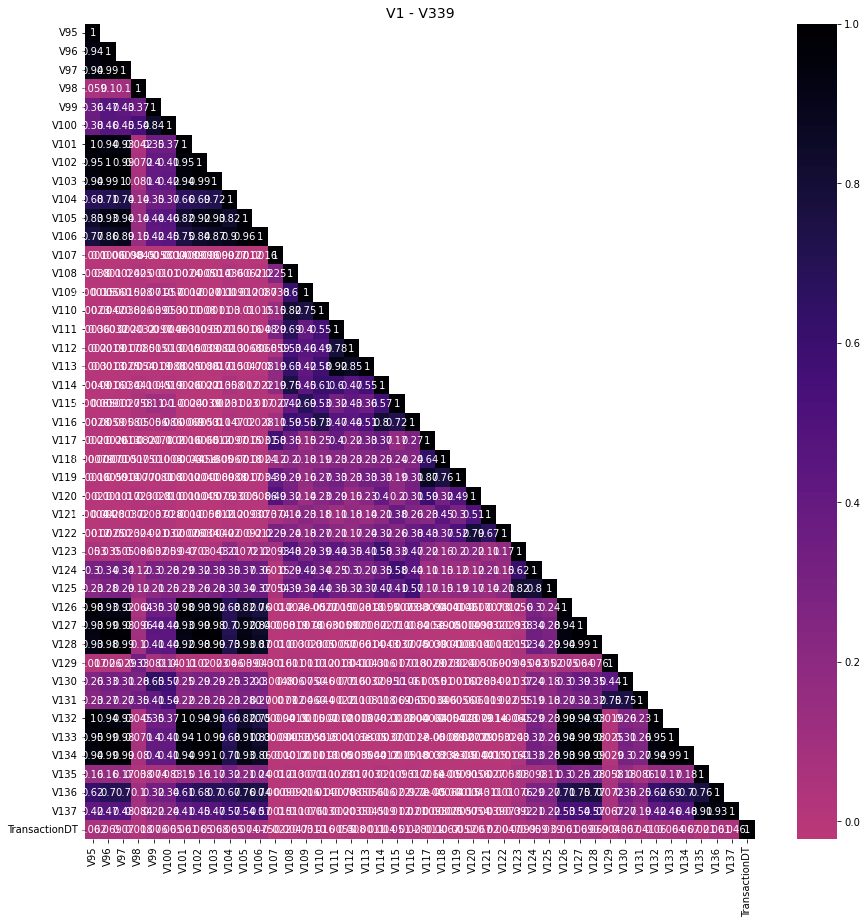

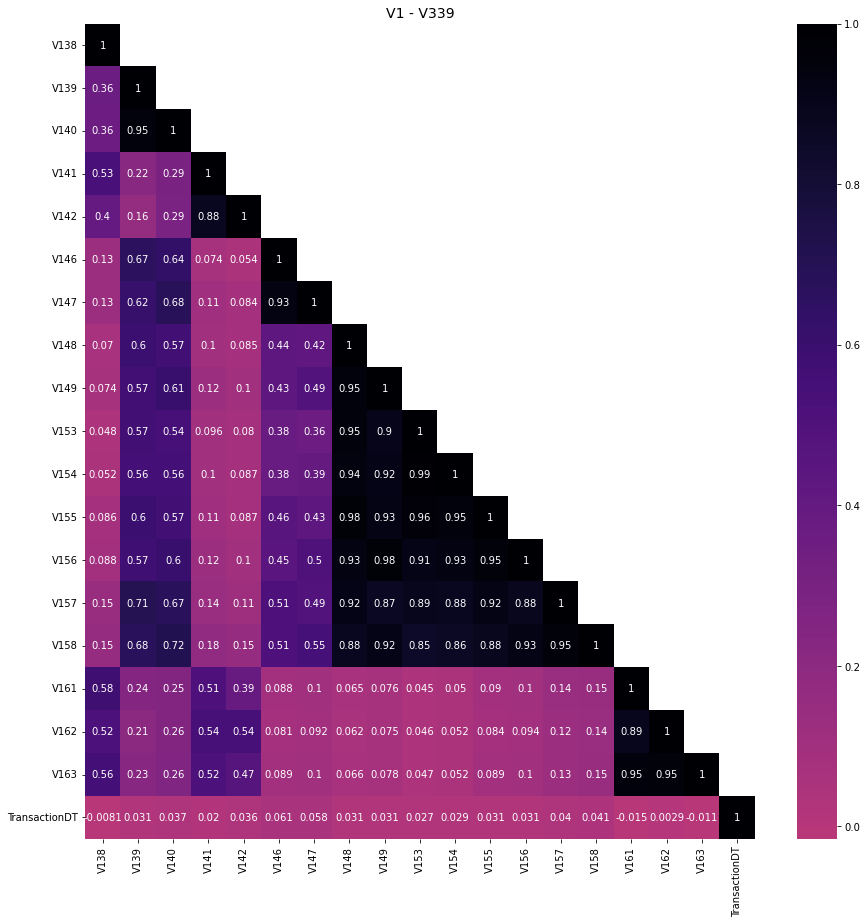

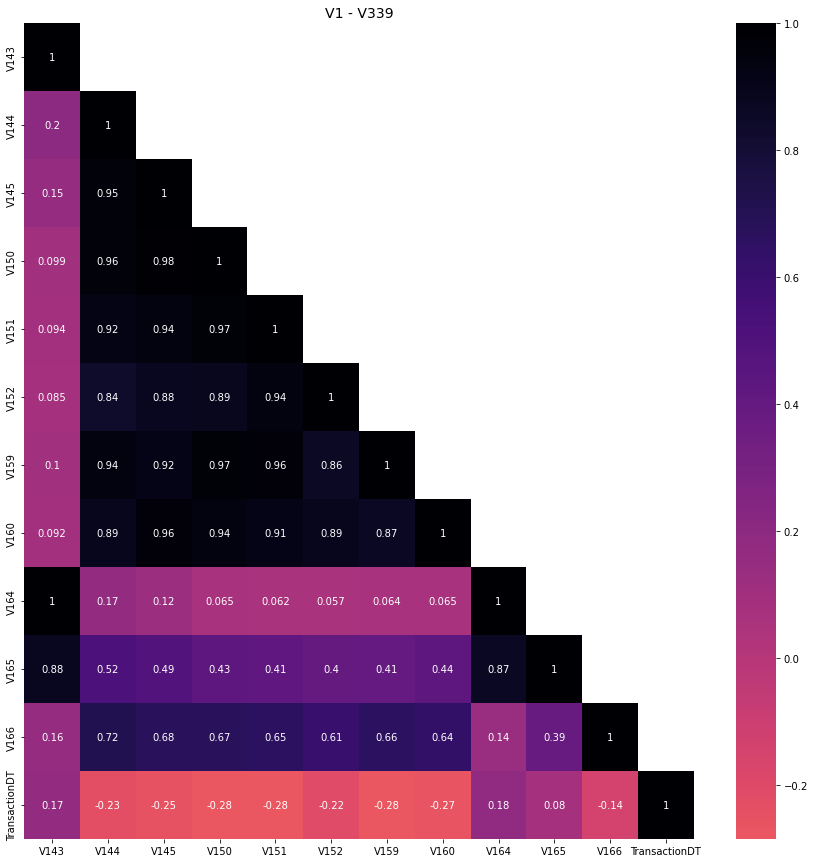

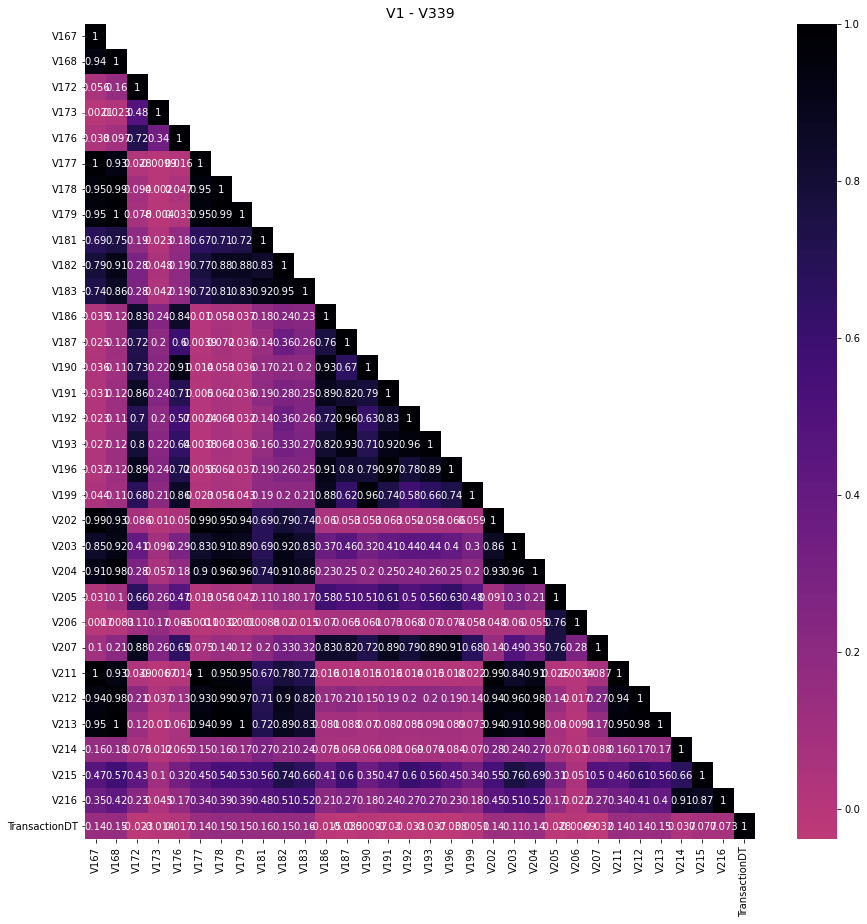

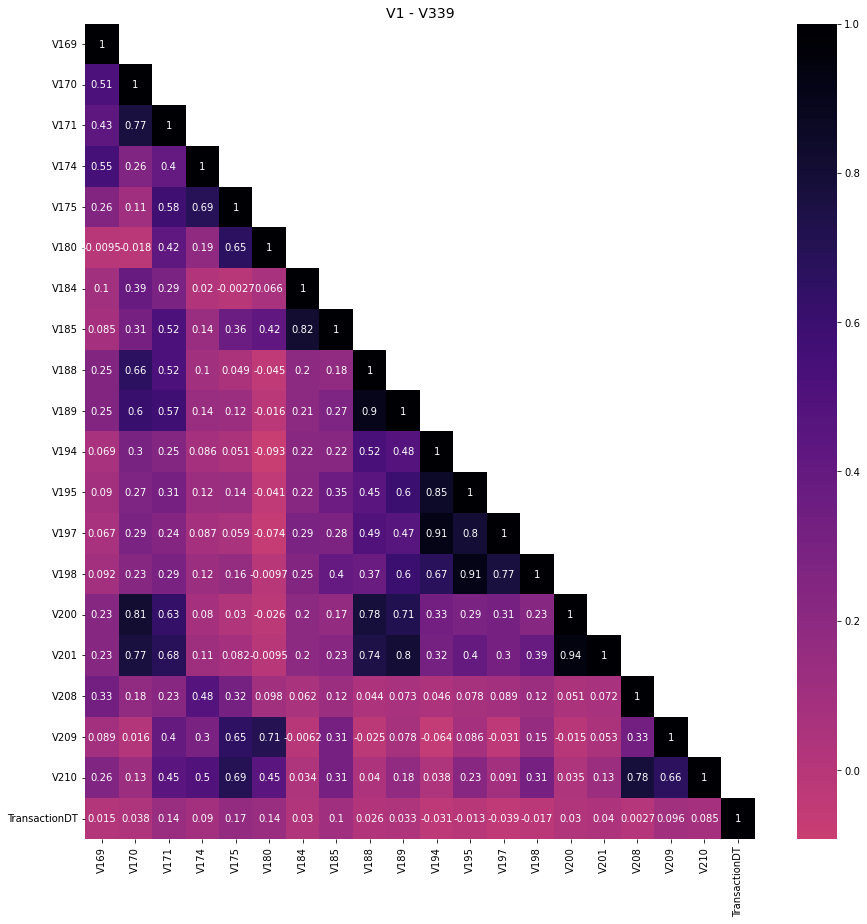

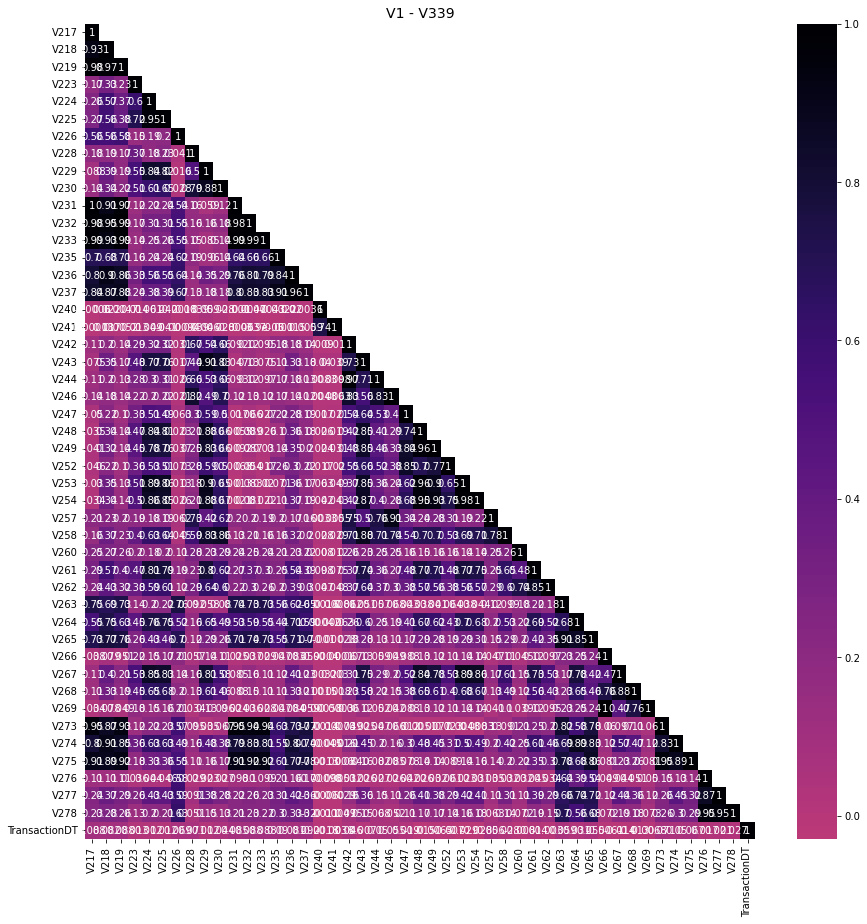

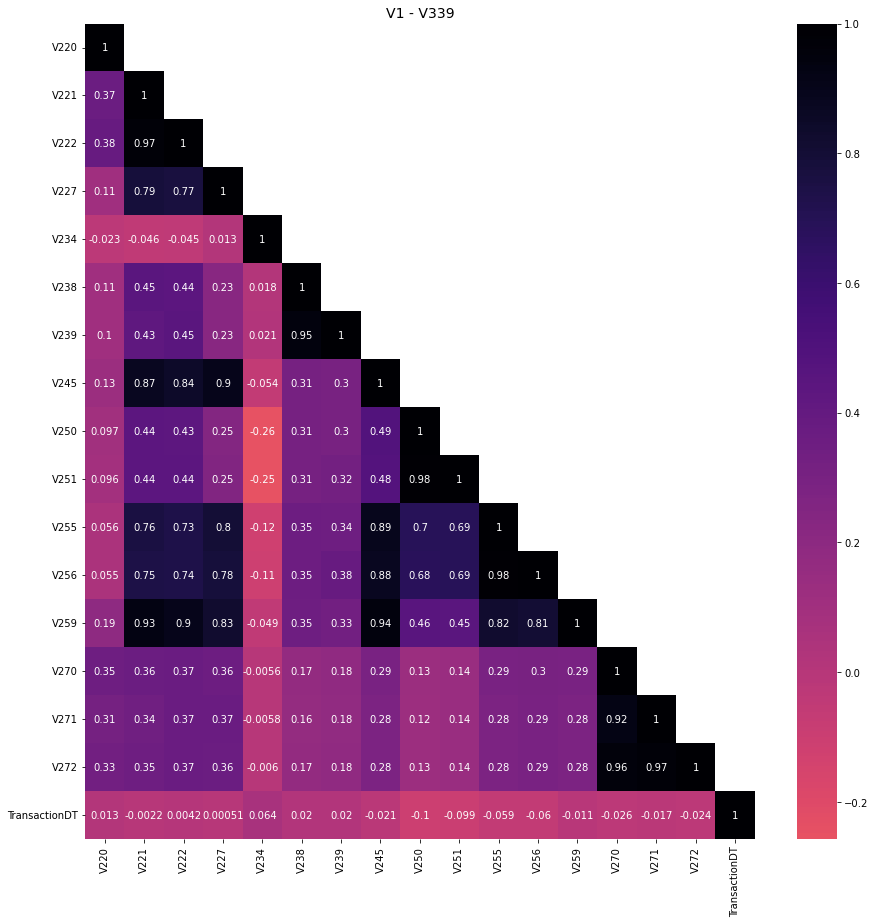

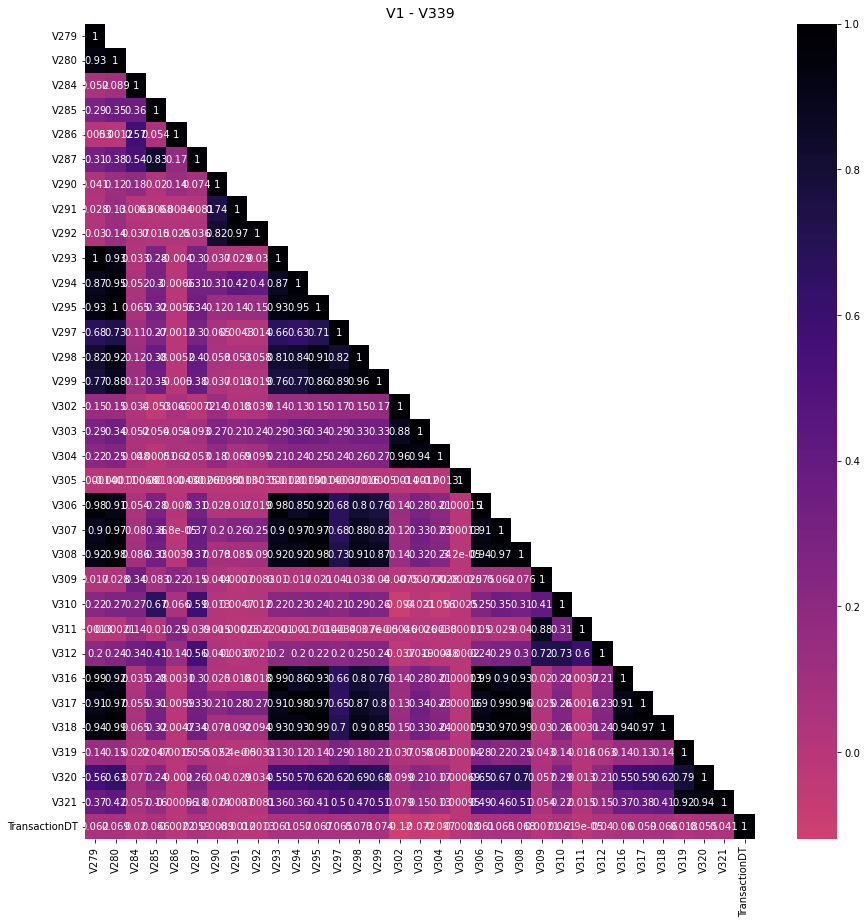

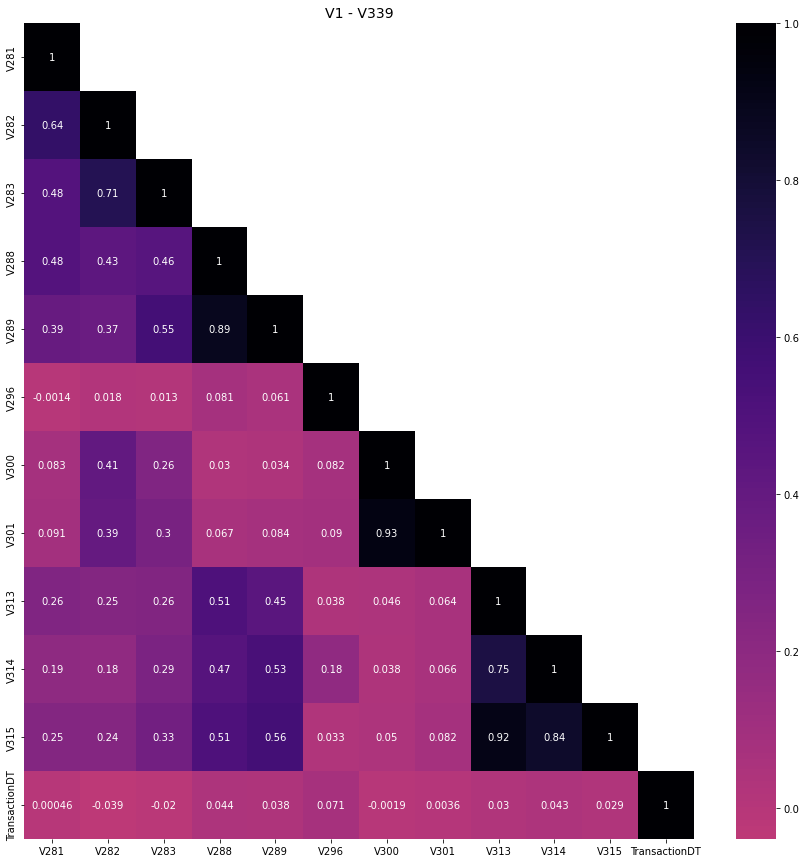

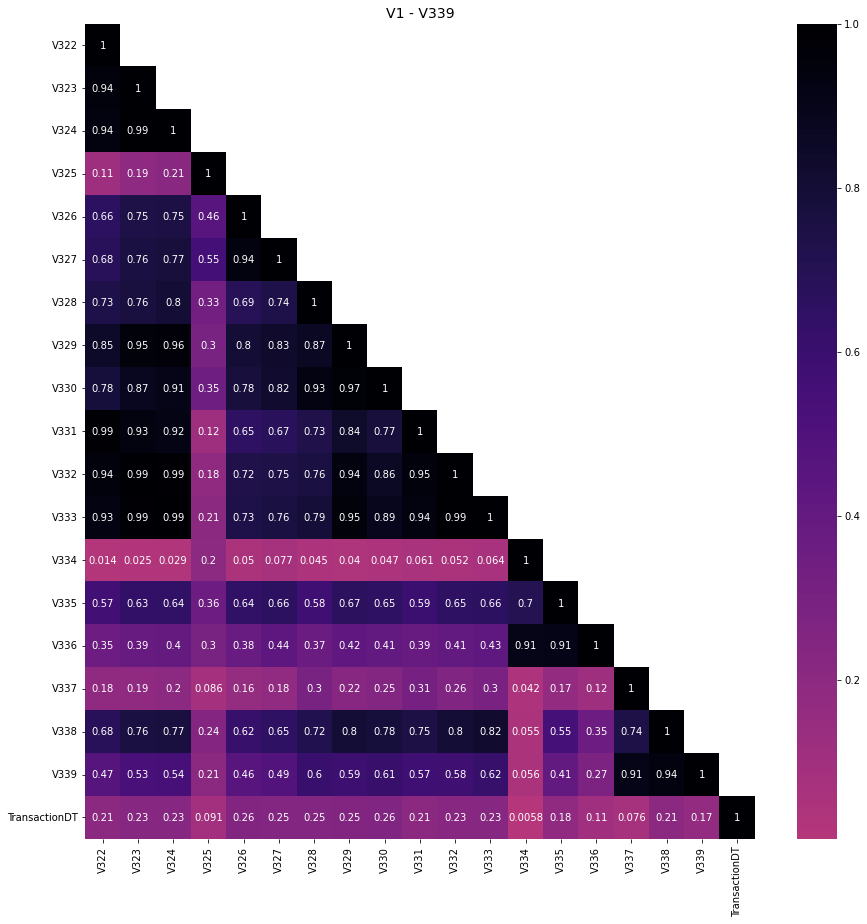

In [89]:
for k,v in nan_groups.items():
    plot_corr(v)

### id1-id38
* id1-id11 are numeric features
* id12-id38 are categorical features.

In [90]:
id_cols = [c for c in train_test if c[:2] == 'id']

id_num_cols=id_cols[:11]
id_cat_cols=id_cols[11:]

In [91]:
train[id_num_cols].describe()

id_01      id_02     id_03     id_04      id_05      id_06  \
count 144233.000 140872.000 66324.000 66324.000 136865.000 136865.000   
mean     -10.171 174716.938     0.060    -0.059      1.616     -6.699   
std       14.343 159650.000     0.598     0.701      5.248     16.482   
min     -100.000      1.000   -13.000   -28.000    -72.000   -100.000   
25%      -10.000  67992.000     0.000     0.000      0.000     -6.000   
50%       -5.000 125800.500     0.000     0.000      0.000      0.000   
75%       -5.000 228749.000     0.000     0.000      1.000      0.000   
max        0.000 999595.000    10.000     0.000     52.000      0.000   

         id_07    id_08     id_09     id_10      id_11  
count 5155.000 5155.000 74926.000 74926.000 140978.000  
mean    13.285  -38.600     0.091    -0.301     99.744  
std     11.384   26.085     0.984     2.789      1.127  
min    -46.000 -100.000   -36.000  -100.000     90.000  
25%      5.000  -48.000     0.000     0.000    100.000  
50%     14.000  -34.000     0.000     0.000    100.000  
75%     22.000  -23.000     0.000     0.000    100.000  
max     61.000    0.000    25.000     0.000    100.000

In [92]:
for i in range(len(id_cat_cols)):
    print(id_cat_cols[i]+" has "+ str(train[id_cat_cols[i]].nunique()) + " unique value.")

id_12 has 2 unique value.
id_13 has 54 unique value.
id_14 has 25 unique value.
id_15 has 3 unique value.
id_16 has 2 unique value.
id_17 has 104 unique value.
id_18 has 18 unique value.
id_19 has 522 unique value.
id_20 has 394 unique value.
id_21 has 490 unique value.
id_22 has 25 unique value.
id_23 has 3 unique value.
id_24 has 12 unique value.
id_25 has 341 unique value.
id_26 has 95 unique value.
id_27 has 2 unique value.
id_28 has 2 unique value.
id_29 has 2 unique value.
id_30 has 75 unique value.
id_31 has 130 unique value.
id_32 has 4 unique value.
id_33 has 260 unique value.
id_34 has 4 unique value.
id_35 has 2 unique value.
id_36 has 2 unique value.
id_37 has 2 unique value.
id_38 has 2 unique value.


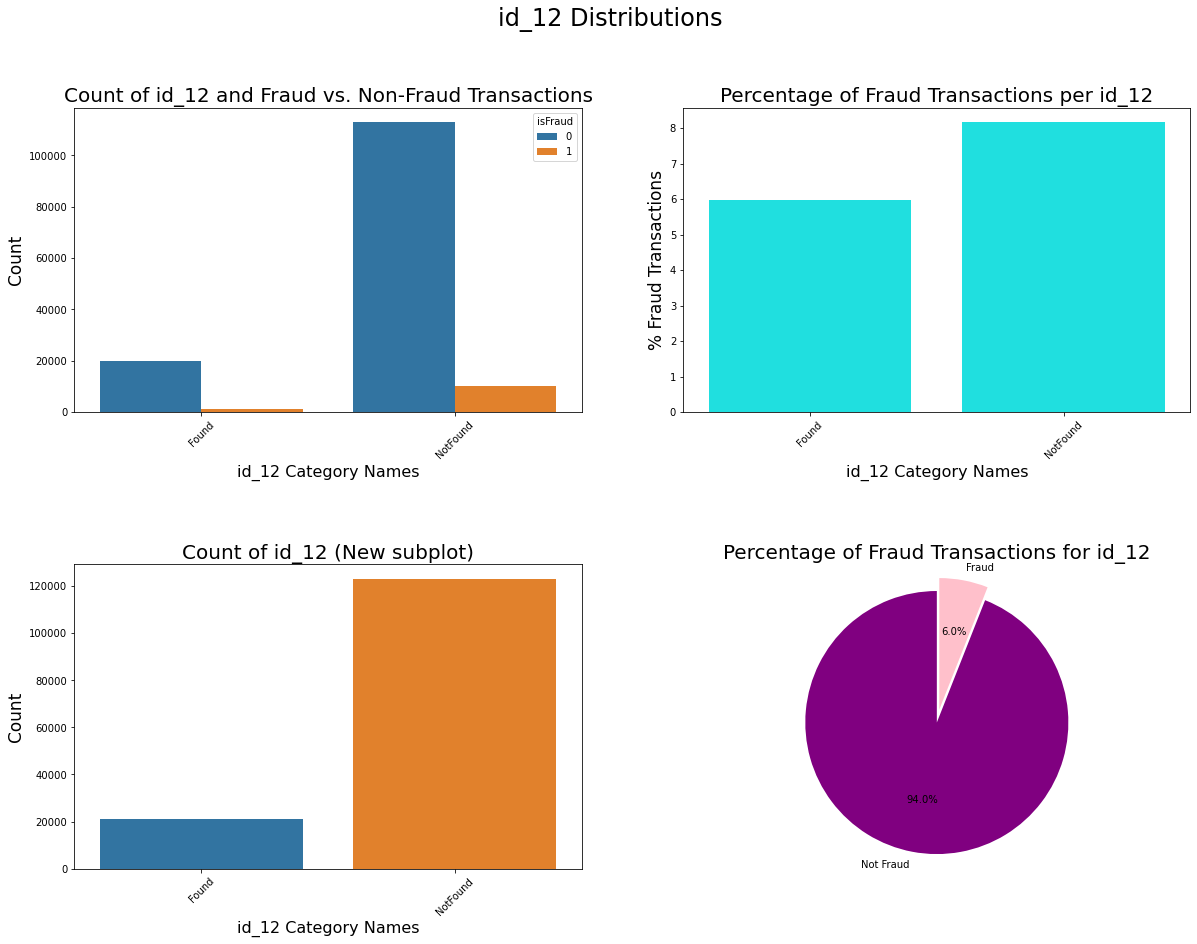

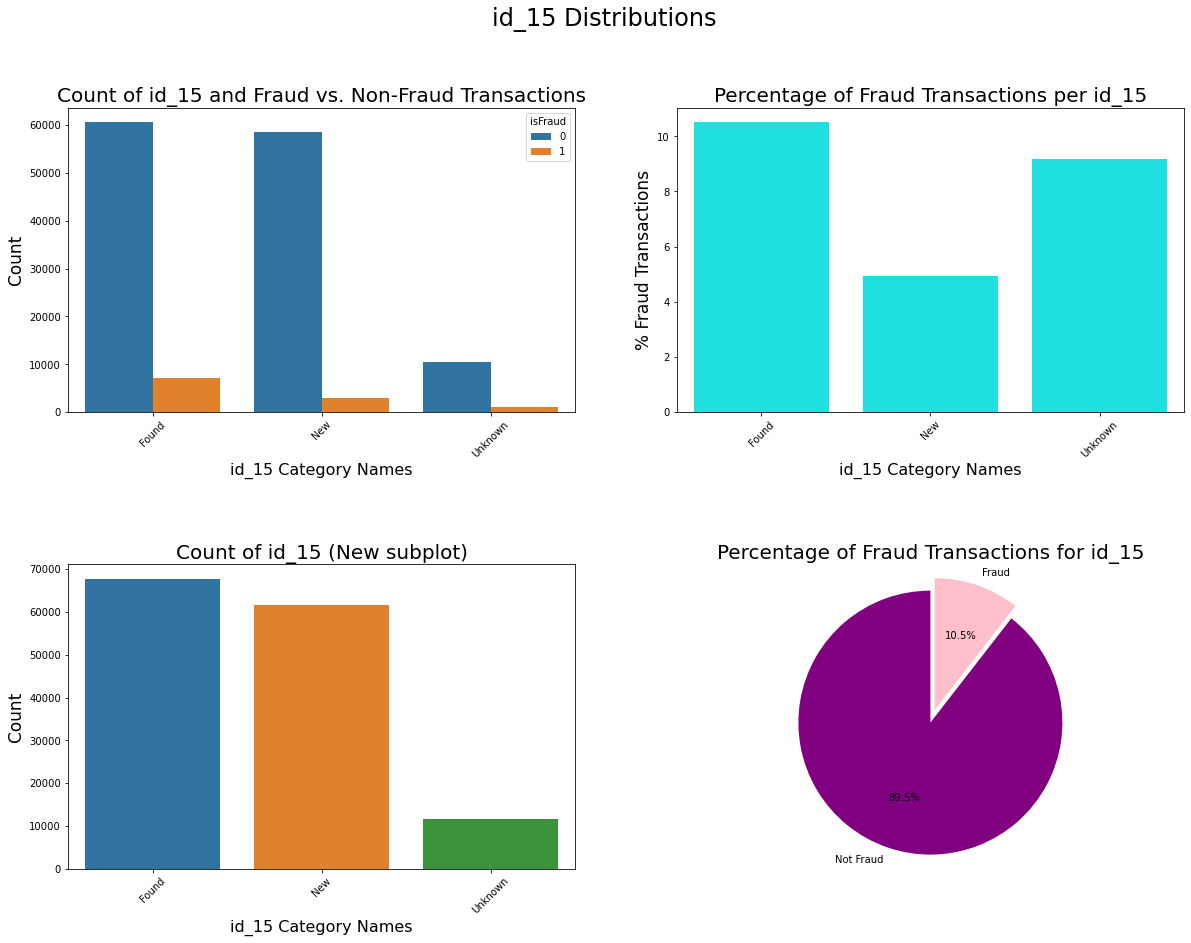

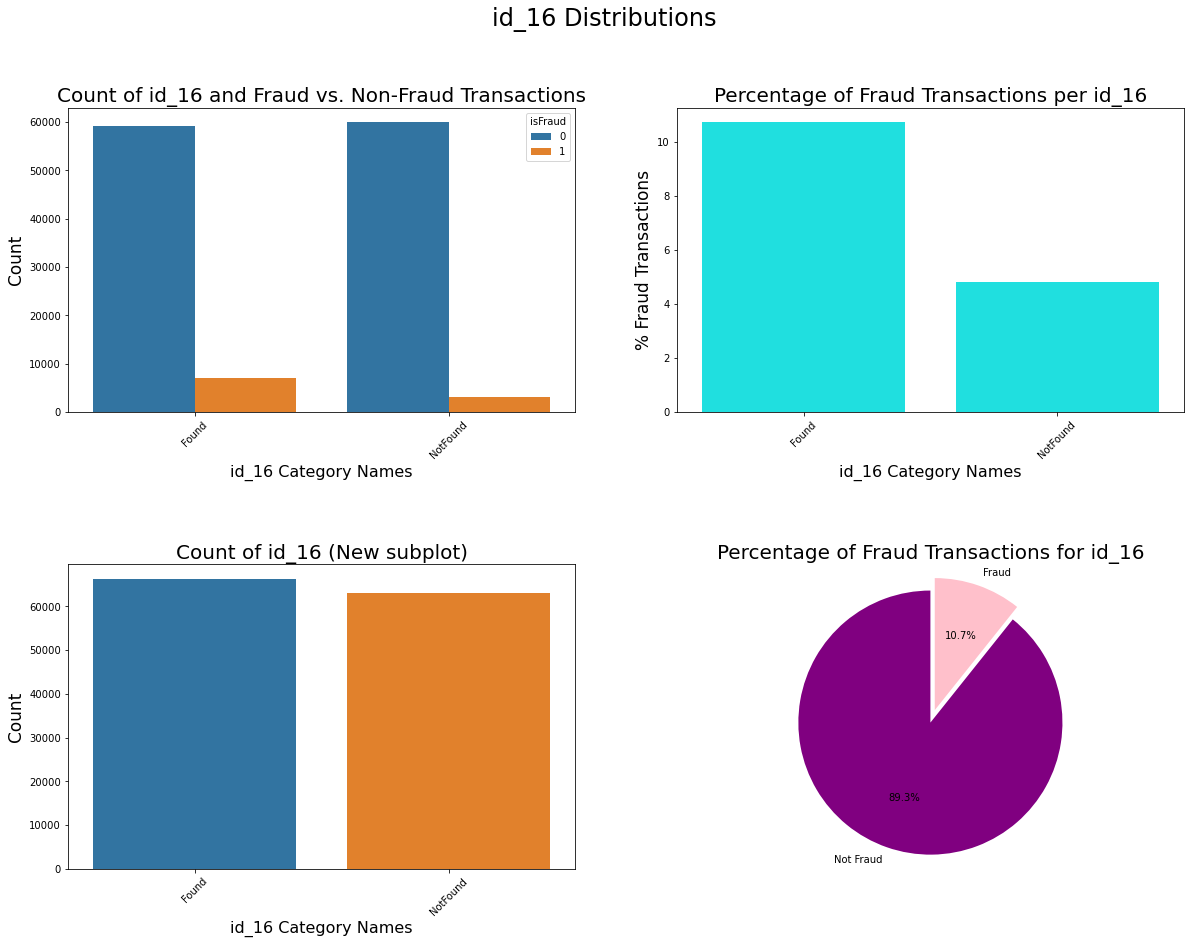

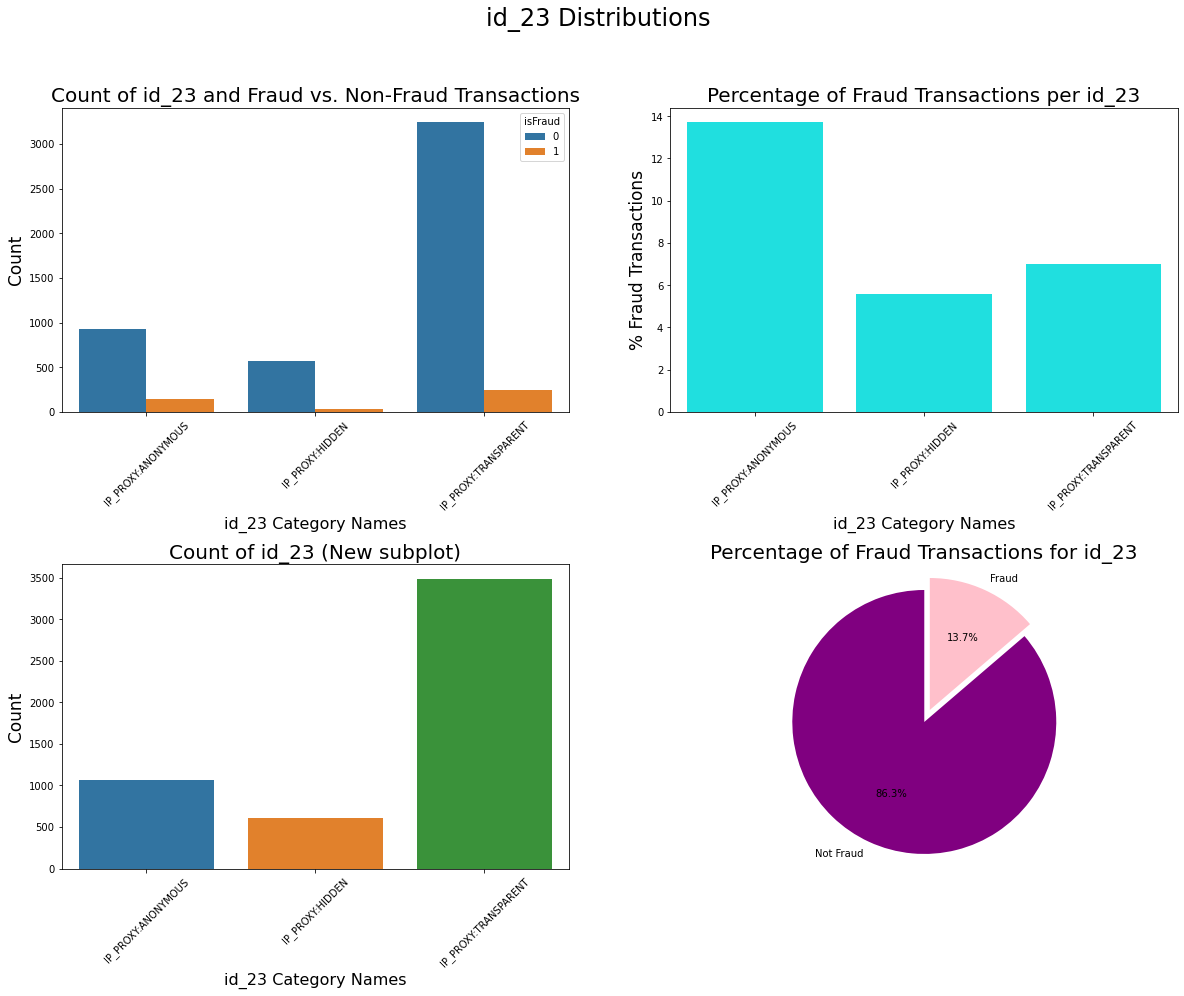

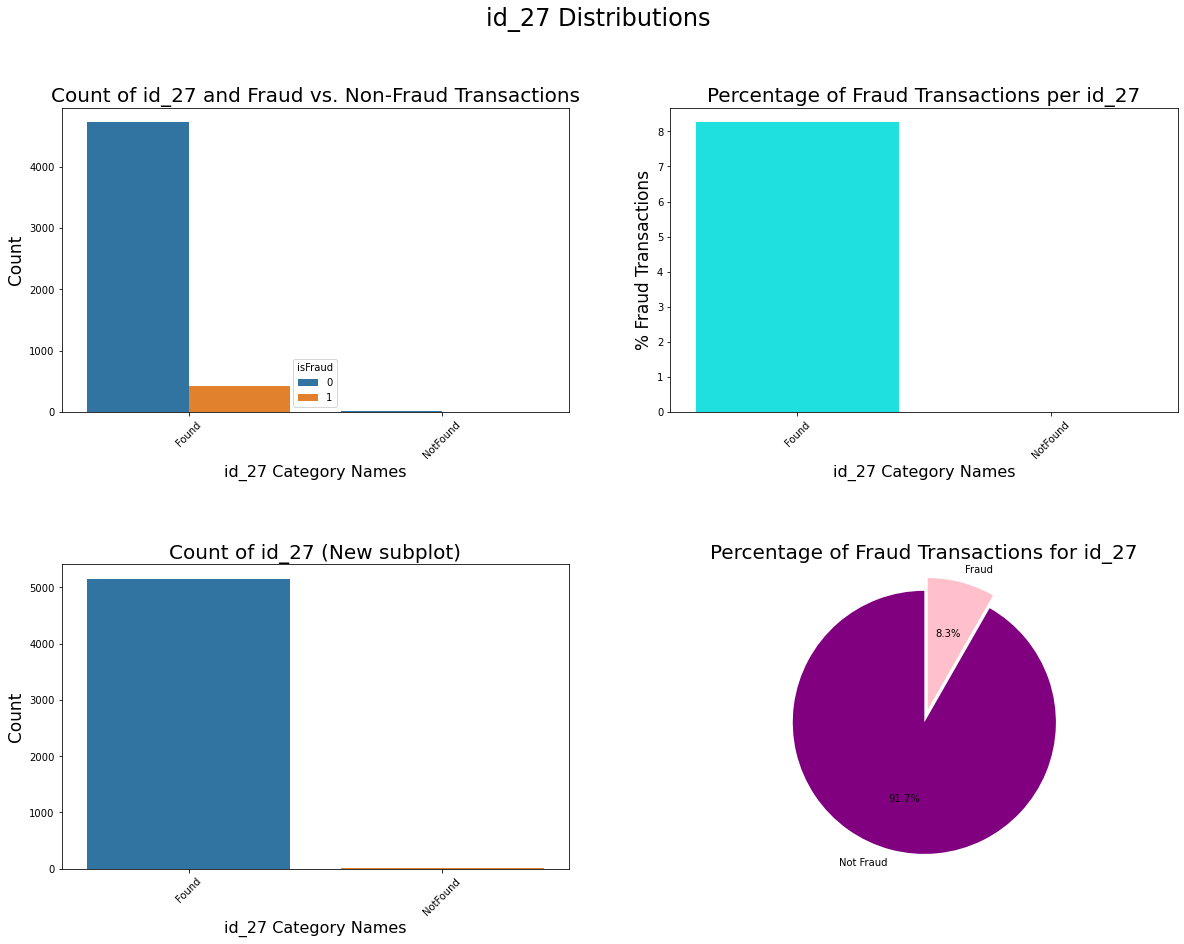

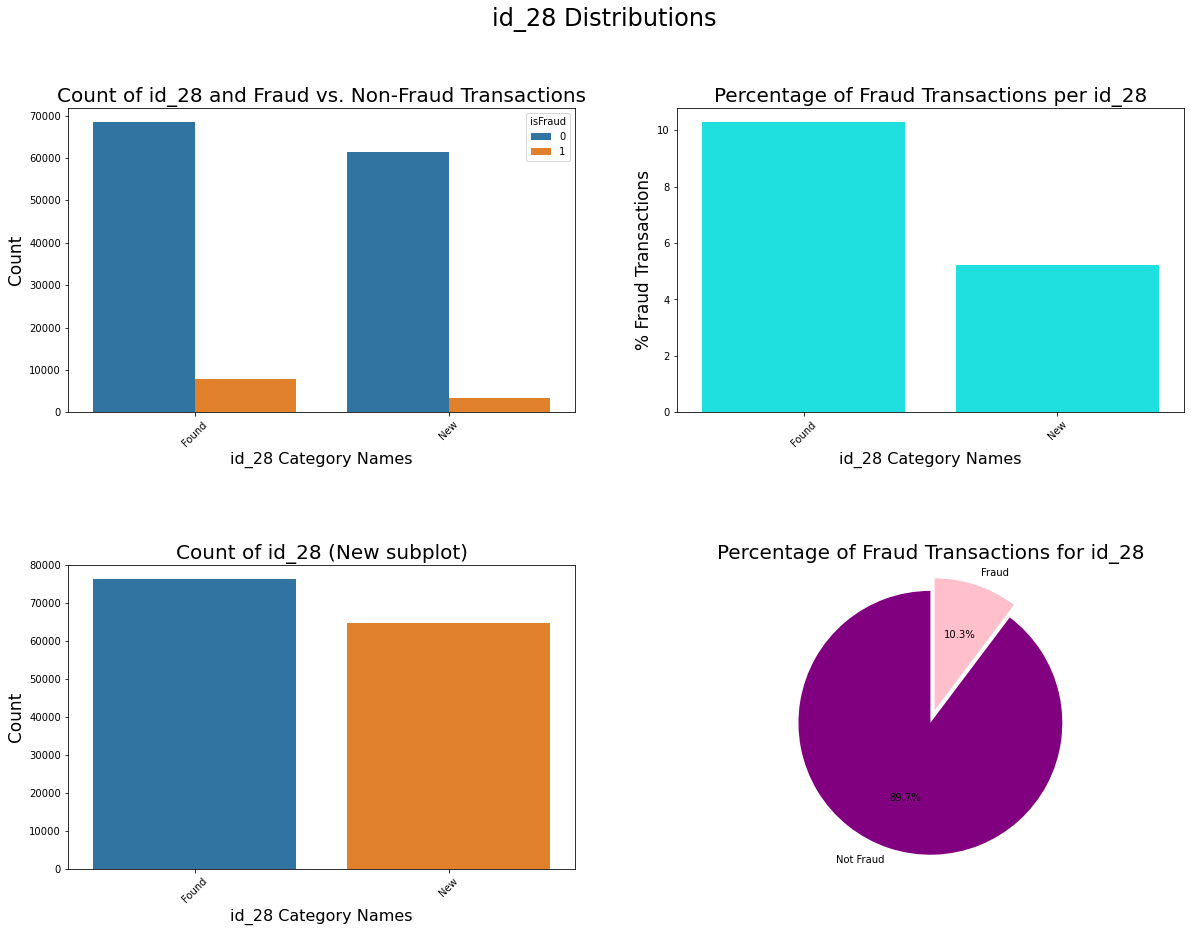

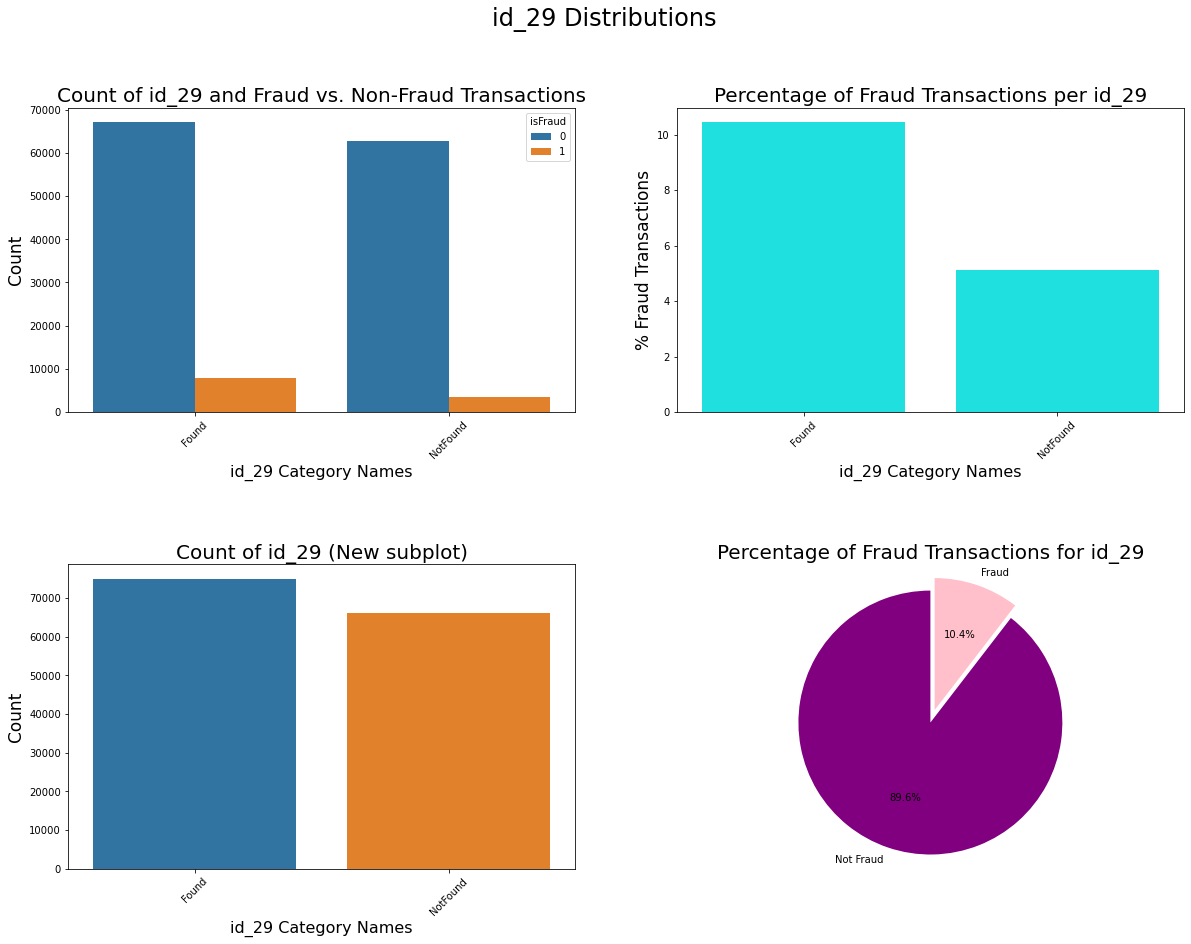

In [93]:
for col in  ['id_12', 'id_15', 'id_16', 'id_23', 'id_27', 'id_28', 'id_29']:
    visualize_distributions(train, col, lim=2500)

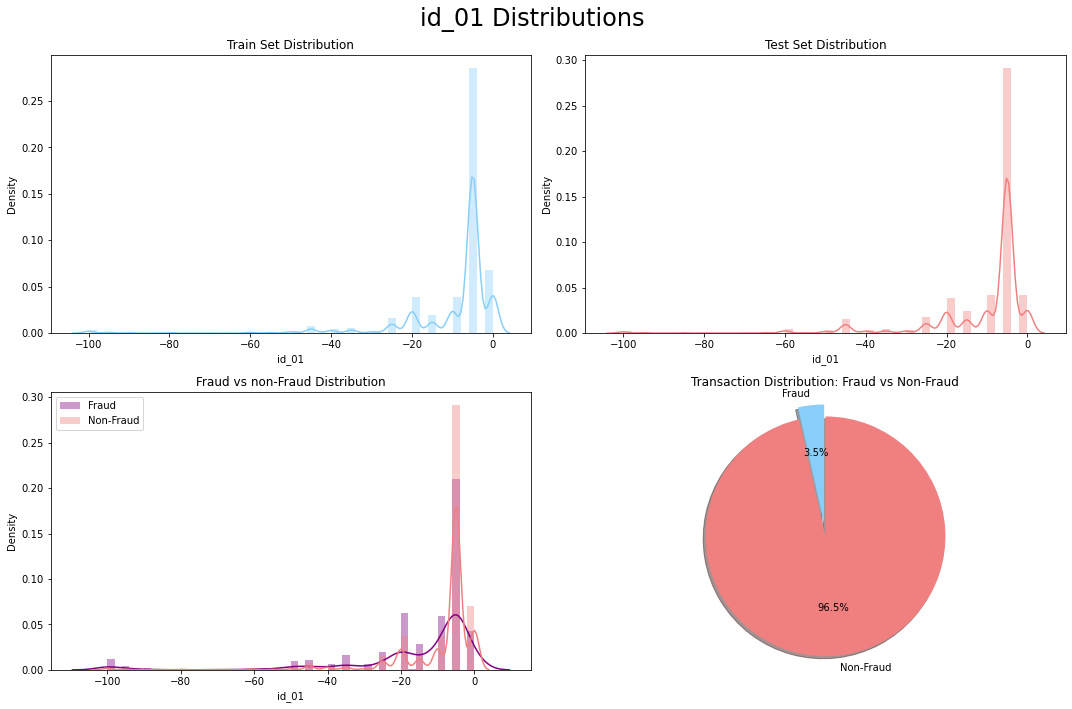

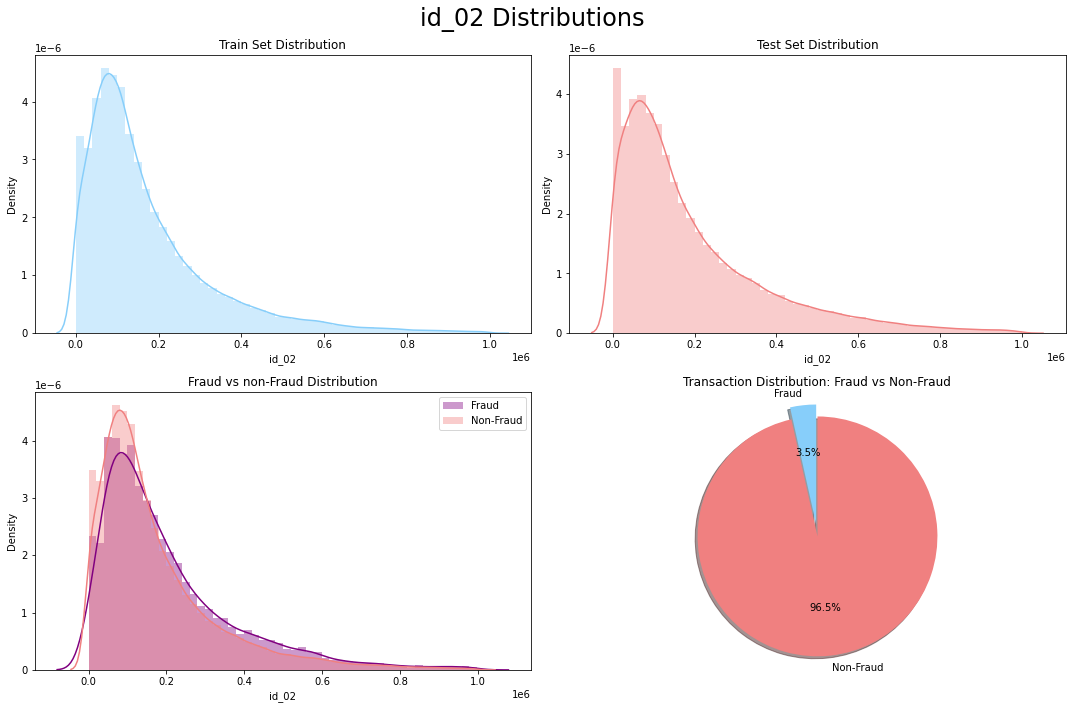

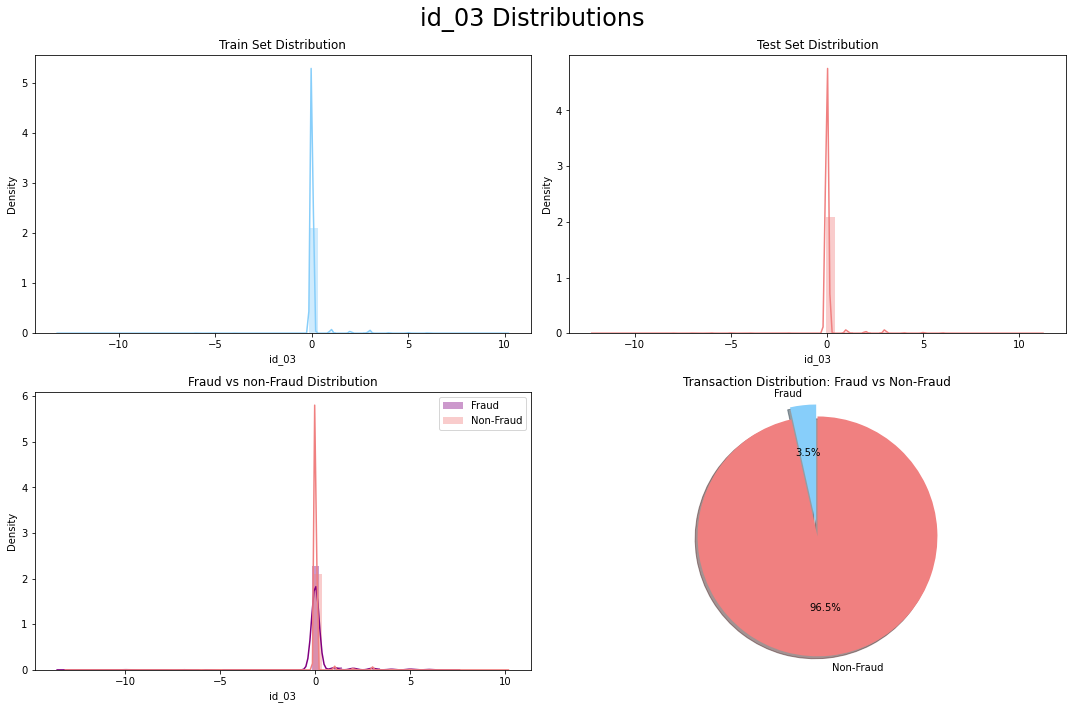

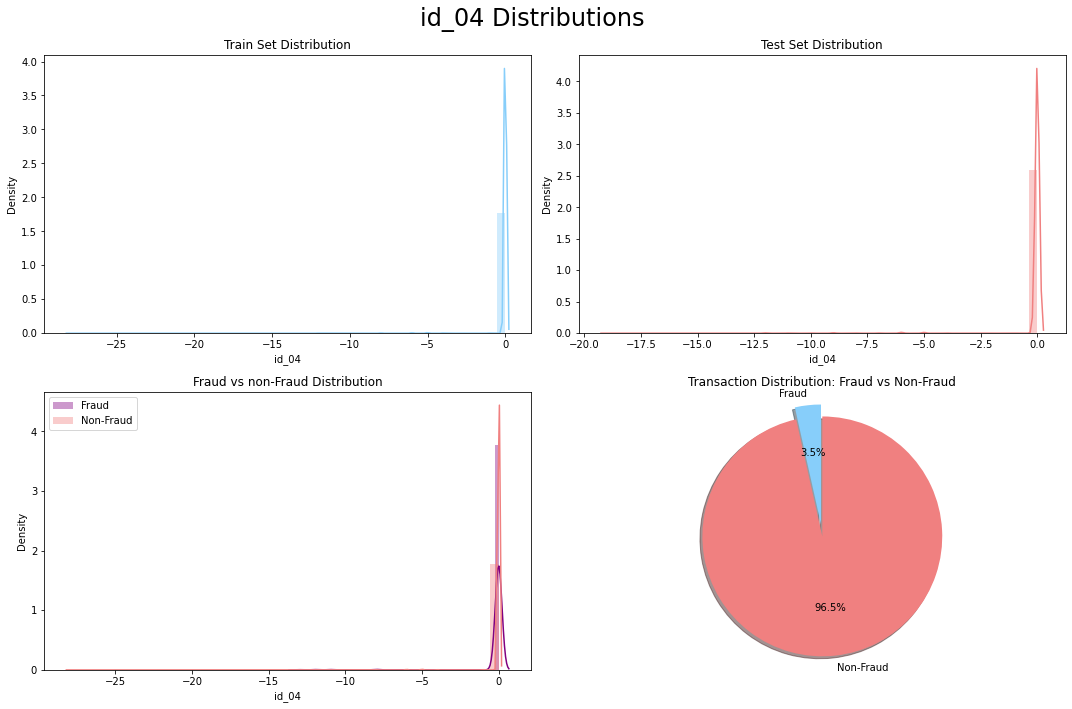

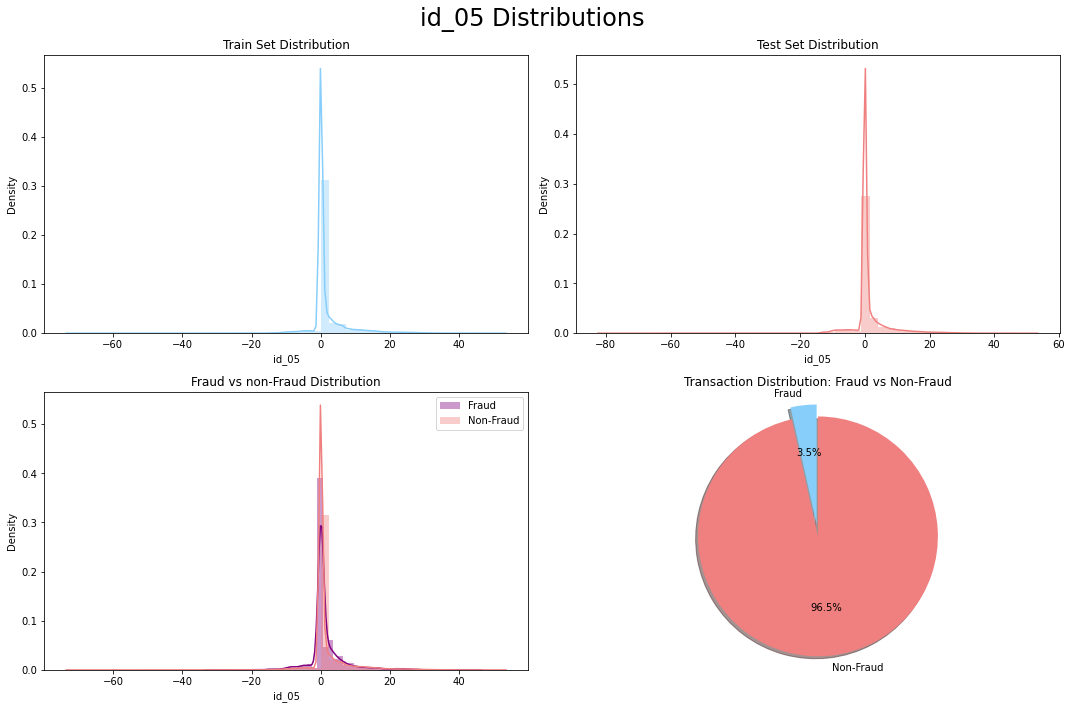

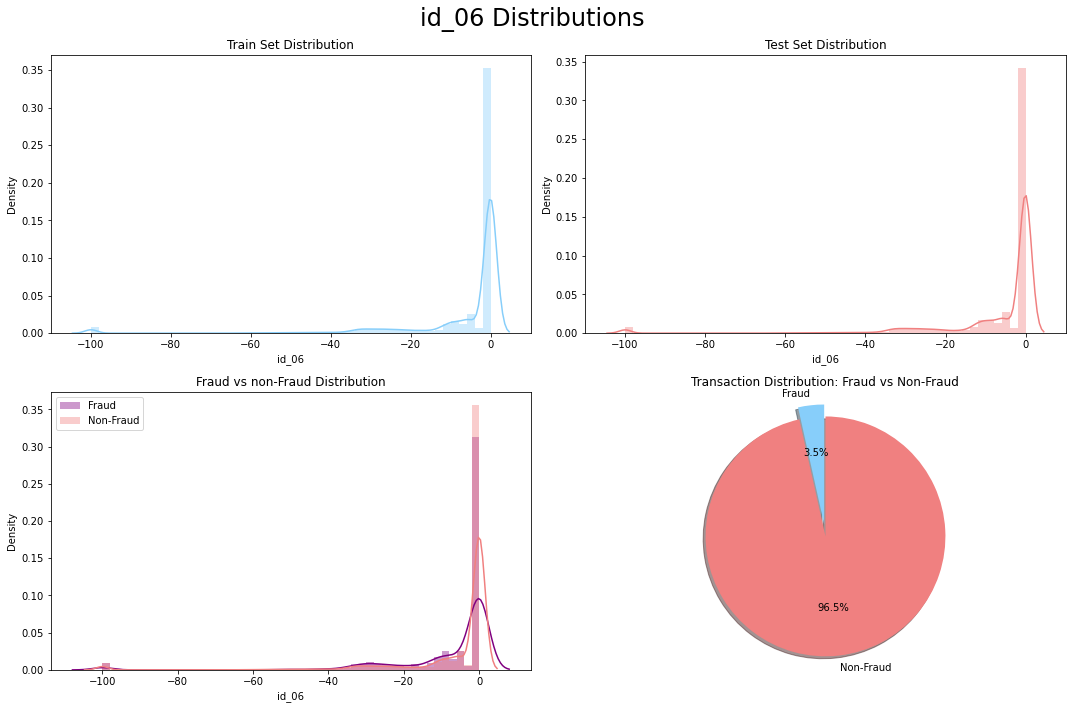

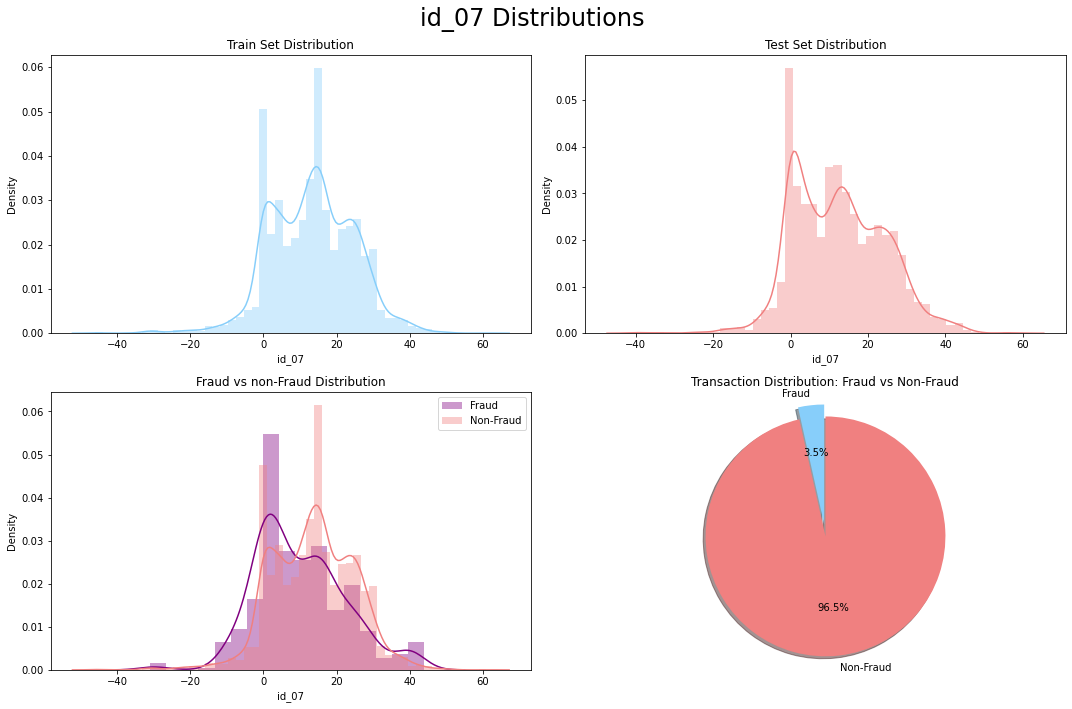

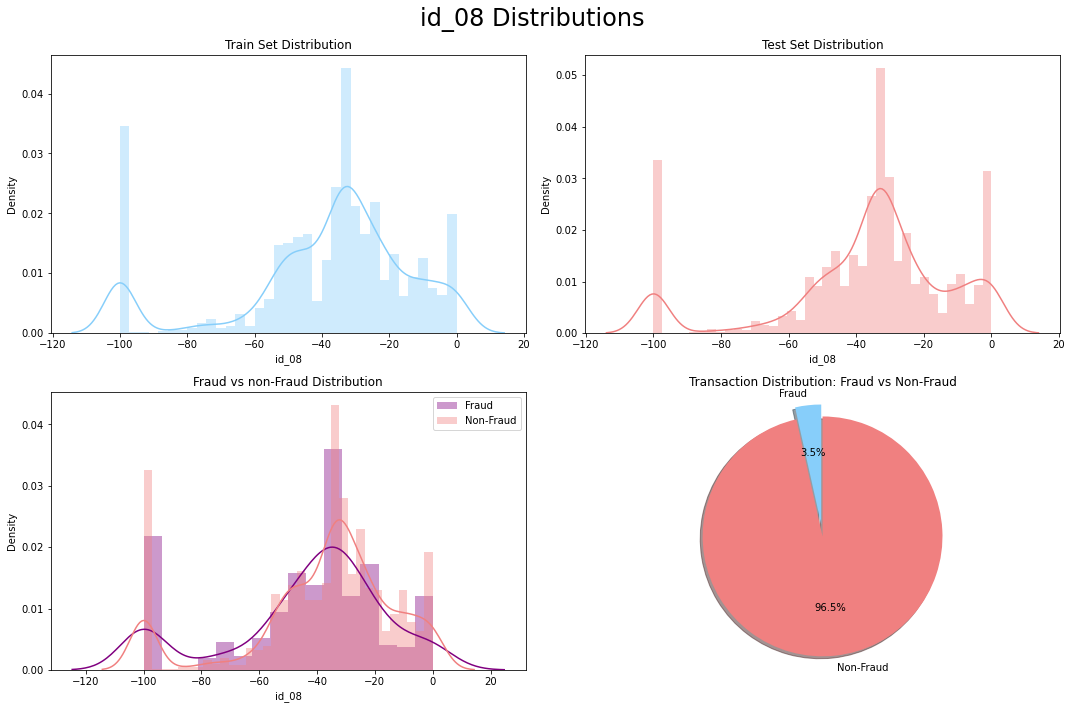

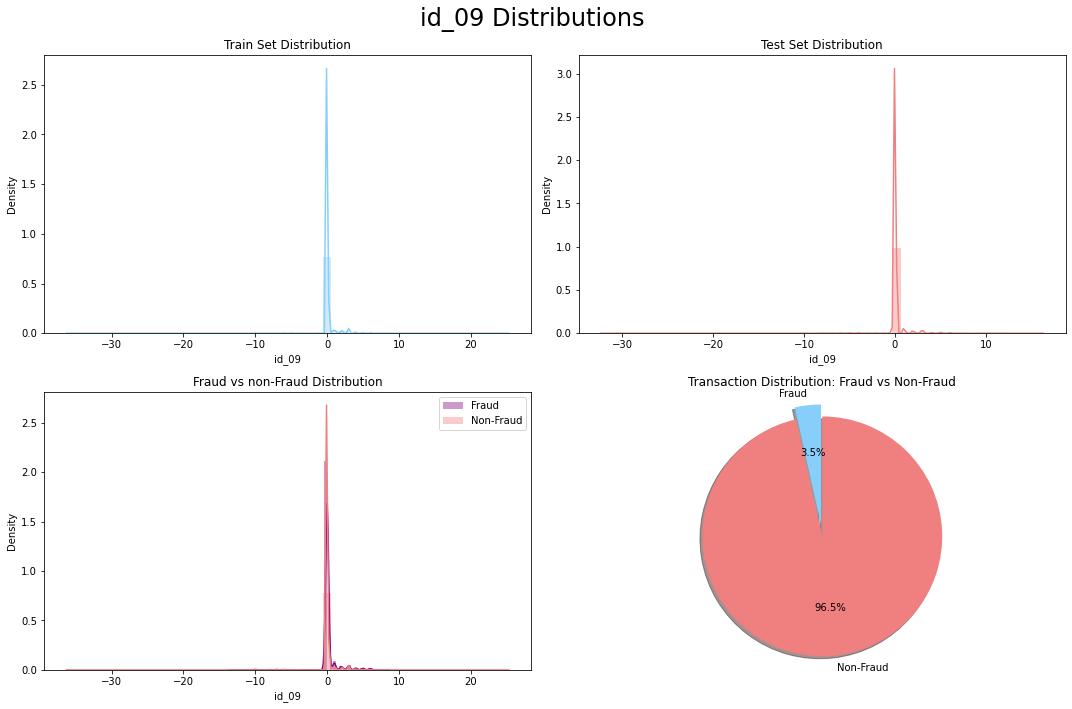

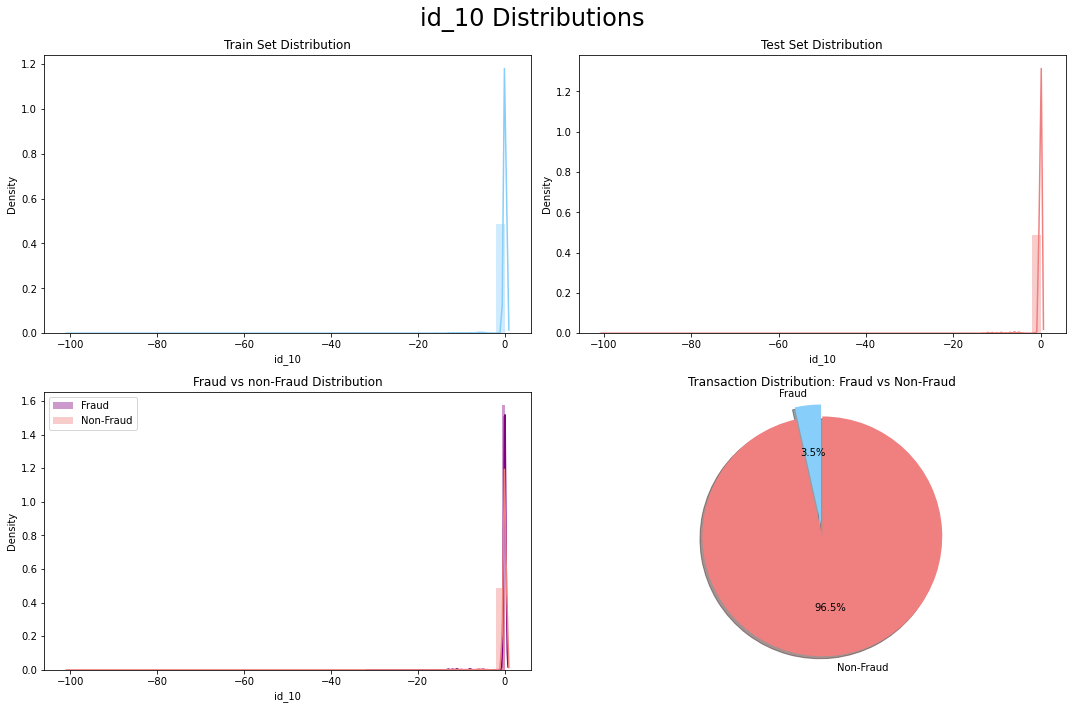

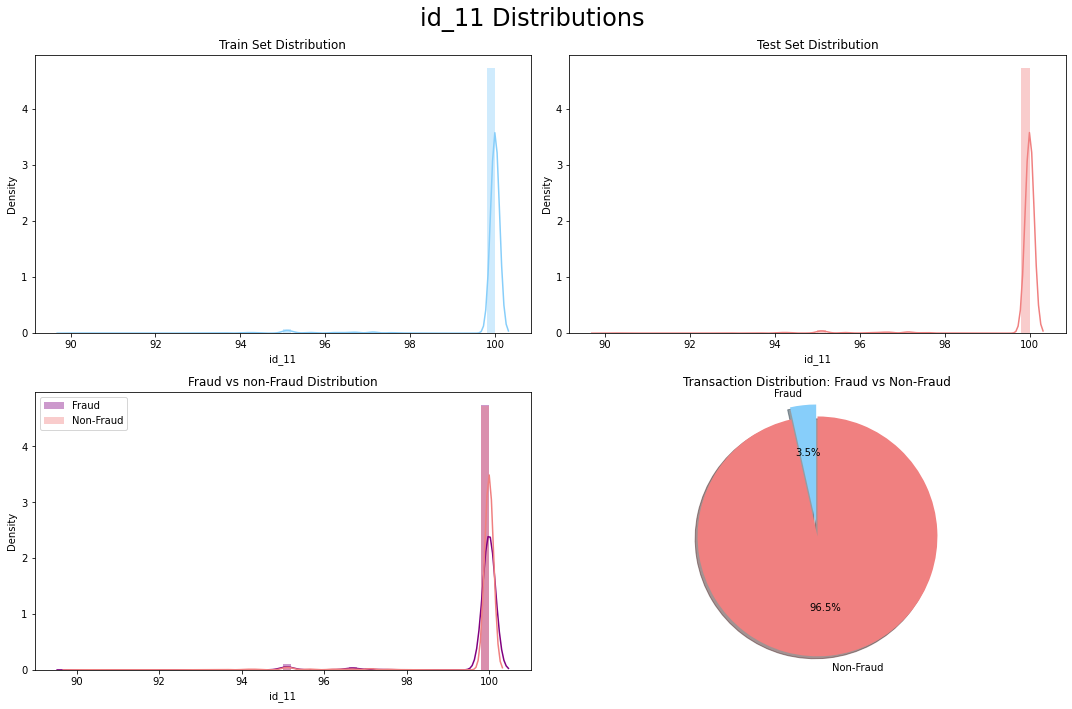

In [94]:
for num in  id_num_cols :
    plot_distributions_cont_features(train, test, train_fraudulent, train_non_fraudulent, num)

# Preprocessing

## Feature extraction

### TransactionDT

In [95]:
START_DATE = '2017-12-01'
startdate = pd.to_datetime(START_DATE)

train_test['New_Date'] = startdate + pd.to_timedelta(train_test['TransactionDT'], unit='s')
train_test['New_Date_YMD'] = train_test['New_Date'].dt.strftime('%Y-%m-%d')
train_test['New_Date_YearMonth'] = train_test['New_Date'].dt.strftime('%Y-%m')
train_test['New_Date_Weekday'] = train_test['New_Date'].dt.dayofweek
train_test['New_Date_Hour'] = train_test['New_Date'].dt.hour
train_test['New_Date_Day'] = train_test['New_Date'].dt.day

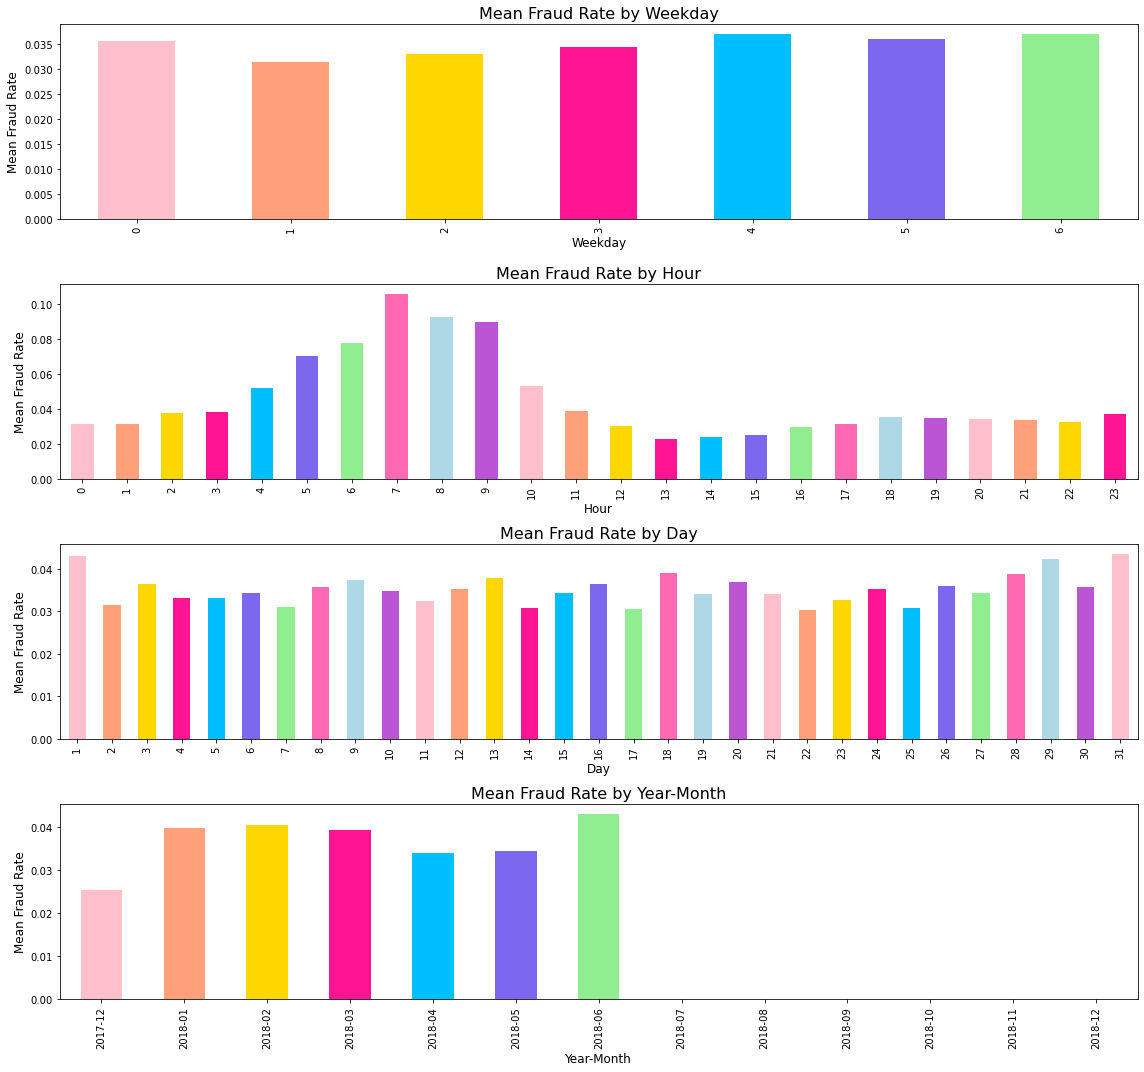

In [96]:
fig, ax = plt.subplots(4, 1, figsize=(16, 15))

colors = ['#FFC0CB', '#FFA07A', '#FFD700', '#FF1493', '#00BFFF', '#7B68EE', '#90EE90', '#FF69B4', '#ADD8E6', '#BA55D3']

train_test.groupby('New_Date_Weekday')['isFraud'].mean().plot.bar(ax=ax[0], color=colors)
train_test.groupby('New_Date_Hour')['isFraud'].mean().plot.bar(ax=ax[1], color=colors)
train_test.groupby('New_Date_Day')['isFraud'].mean().plot.bar(ax=ax[2], color=colors)
train_test.groupby('New_Date_YearMonth')['isFraud'].mean().plot.bar(ax=ax[3], color=colors)

ax[0].set_title('Mean Fraud Rate by Weekday', fontsize=16)
ax[1].set_title('Mean Fraud Rate by Hour', fontsize=16)
ax[2].set_title('Mean Fraud Rate by Day', fontsize=16)
ax[3].set_title('Mean Fraud Rate by Year-Month', fontsize=16)

ax[0].set_xlabel('Weekday', fontsize=12)
ax[1].set_xlabel('Hour', fontsize=12)
ax[2].set_xlabel('Day', fontsize=12)
ax[3].set_xlabel('Year-Month', fontsize=12)

ax[0].set_ylabel('Mean Fraud Rate', fontsize=12)
ax[1].set_ylabel('Mean Fraud Rate', fontsize=12)
ax[2].set_ylabel('Mean Fraud Rate', fontsize=12)
ax[3].set_ylabel('Mean Fraud Rate', fontsize=12)

plt.tight_layout()  # Adjust the spacing between subplots
plt.show()


### TransactionAMT

In [97]:
train_test['New_Cents'] = (train_test['TransactionAmt'] - np.floor(train_test['TransactionAmt'])).astype('float32')
train_test['New_TransactionAmt_Bin'] = pd.qcut(train_test['TransactionAmt'],15)

### Cards

In [98]:
card_cols = [c for c in train_test if c[0:2] == 'ca']
for col in ['card2','card3','card4','card5','card6']:
    train_test[col] = train_test.groupby(['card1'])[col].transform(lambda x: x.mode(dropna=False).iat[0])
    train_test[col].fillna(train_test[col].mode()[0], inplace=True)

### PCA (for V columns)

In [99]:
v_nan_df = train_test[v_cols].isna()
nan_groups={}

In [100]:
for col in v_cols:
    cur_group = v_nan_df[col].sum()
    try:
        nan_groups[cur_group].append(col)
    except:
        nan_groups[cur_group]=[col]
del v_nan_df; x=gc.collect()

In [101]:
for nan_cnt, v_group in nan_groups.items():
    train_test['New_v_group_'+str(nan_cnt)+'_nulls'] = nan_cnt
    sc = StandardScaler()
    pca = PCA(n_components=2)
    v_group_pca = pca.fit_transform(sc.fit_transform(train_test[v_group].fillna(-1)))
    train_test['New_v_group_'+str(nan_cnt)+'_pca0'] = v_group_pca[:,0]
    train_test['New_v_group_'+str(nan_cnt)+'_pca1'] = v_group_pca[:,1]

### Creating New Features


In [102]:
train_test['New_P_emaildomain_addr1'] = f"{train_test['P_emaildomain']}_{train_test['addr1']}"
train_test['New_R_emaildomain_addr2'] = f"{train_test['R_emaildomain']}_{train_test['addr2']}"

In [103]:
train_test['New_card1_card2'] = train_test['card1'].astype(str) + '_' + train_test['card2'].astype(str)
train_test['New_addr1_addr2'] = train_test['addr1'].astype(str) + '_' + train_test['addr2'].astype(str)
train_test['New_card1_card2_addr1_addr2'] = f"{train_test['card1']}_{train_test['card2']}_{train_test['addr1']}_{train_test['addr2']}"

### Aggregation Features

In [104]:
# Define the list of columns to compute aggregation features
columns = ['TransactionAmt', 'id_02', 'D15']

In [105]:
# Iterate over the columns and aggregation criteria
for col in columns:
    train_test['New_{}_to_mean_card1'.format(col)] = train_test[col] / train_test.groupby(['card1'])[col].transform('mean')
    train_test['New_{}_to_mean_card4'.format(col)] = train_test[col] / train_test.groupby(['card4'])[col].transform('mean')
    train_test['New_{}_to_std_card1'.format(col)] = train_test[col] / train_test.groupby(['card1'])[col].transform('std')
    train_test['New_{}_to_std_card4'.format(col)] = train_test[col] / train_test.groupby(['card4'])[col].transform('std')
    train_test['New_{}_to_mean_addr1'.format(col)] = train_test[col] / train_test.groupby(['addr1'])[col].transform('mean')
    train_test['New_{}_to_std_addr1'.format(col)] = train_test[col] / train_test.groupby(['addr1'])[col].transform('std')

### Removing Unnecessary Columns

In [106]:
# Define the columns to drop
columns_to_drop = v_cols + ["TransactionDT", "New_Date"] + card_cols

In [107]:
# Drop the specified columns from the train_test DataFrame
train_test = train_test.drop(columns_to_drop, axis=1)

### Frequency Encoding 

In [108]:
fe_col_list=['P_emaildomain','R_emaildomain','DeviceType','DeviceInfo']+[c for c in train_test if c[0] == 'M']
#
for col in fe_col_list:
    vc = train_test[col].value_counts(dropna=True, normalize=True).to_dict()
    vc[-1] = -1
    nm = 'New_'+col+'_FE'
    train_test[nm] = train_test[col].map(vc)
    train_test[nm] = train_test[nm].astype('float32')

In [109]:
train_test.head()

TransactionID  isFraud  TransactionAmt ProductCD   addr1  addr2   dist1  \
0        2987000    0.000          68.500         W 315.000 87.000  19.000   
1        2987001    0.000          29.000         W 325.000 87.000     NaN   
2        2987002    0.000          59.000         W 330.000 87.000 287.000   
3        2987003    0.000          50.000         W 476.000 87.000     NaN   
4        2987004    0.000          50.000         H 420.000 87.000     NaN   

   dist2 P_emaildomain R_emaildomain    C1    C2    C3    C4    C5    C6  \
0    NaN           NaN           NaN 1.000 1.000 0.000 0.000 0.000 1.000   
1    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000   
2    NaN   outlook.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000   
3    NaN     yahoo.com           NaN 2.000 5.000 0.000 0.000 0.000 4.000   
4    NaN     gmail.com           NaN 1.000 1.000 0.000 0.000 0.000 1.000   

     C7    C8    C9   C10   C11   C12    C13   C14      D1      D2     D3  \
0 0.000 0.000 1.000 0.000 2.000 0.000  1.000 1.000  14.000     NaN 13.000   
1 0.000 0.000 0.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN   
2 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN   
3 0.000 0.000 1.000 0.000 1.000 0.000 25.000 1.000 112.000 112.000  0.000   
4 0.000 1.000 0.000 1.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN   

      D4    D5  D6  D7  D8  D9    D10     D11  D12  D13  D14     D15   M1  \
0    NaN   NaN NaN NaN NaN NaN 13.000  13.000  NaN  NaN  NaN   0.000    T   
1  0.000   NaN NaN NaN NaN NaN  0.000     NaN  NaN  NaN  NaN   0.000  NaN   
2  0.000   NaN NaN NaN NaN NaN  0.000 315.000  NaN  NaN  NaN 315.000    T   
3 94.000 0.000 NaN NaN NaN NaN 84.000     NaN  NaN  NaN  NaN 111.000  NaN   
4    NaN   NaN NaN NaN NaN NaN    NaN     NaN  NaN  NaN  NaN     NaN  NaN   

    M2   M3   M4   M5   M6   M7   M8   M9  id_01     id_02  id_03  id_04  \
0    T    T   M2    F    T  NaN  NaN  NaN    NaN       NaN    NaN    NaN   
1  NaN  NaN   M0    T    T  NaN  NaN  NaN    NaN       NaN    NaN    NaN   
2    T    T   M0    F    F    F    F    F    NaN       NaN    NaN    NaN   
3  NaN  NaN   M0    T    F  NaN  NaN  NaN    NaN       NaN    NaN    NaN   
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.000 70787.000    NaN    NaN   

   id_05  id_06  id_07  id_08  id_09  id_10   id_11     id_12  id_13    id_14  \
0    NaN    NaN    NaN    NaN    NaN    NaN     NaN       NaN    NaN      NaN   
1    NaN    NaN    NaN    NaN    NaN    NaN     NaN       NaN    NaN      NaN   
2    NaN    NaN    NaN    NaN    NaN    NaN     NaN       NaN    NaN      NaN   
3    NaN    NaN    NaN    NaN    NaN    NaN     NaN       NaN    NaN      NaN   
4    NaN    NaN    NaN    NaN    NaN    NaN 100.000  NotFound    NaN -480.000   

  id_15     id_16   id_17  id_18   id_19   id_20  id_21  id_22 id_23  id_24  \
0   NaN       NaN     NaN    NaN     NaN     NaN    NaN    NaN   NaN    NaN   
1   NaN       NaN     NaN    NaN     NaN     NaN    NaN    NaN   NaN    NaN   
2   NaN       NaN     NaN    NaN     NaN     NaN    NaN    NaN   NaN    NaN   
3   NaN       NaN     NaN    NaN     NaN     NaN    NaN    NaN   NaN    NaN   
4   New  NotFound 166.000    NaN 542.000 144.000    NaN    NaN   NaN    NaN   

   id_25  id_26 id_27 id_28     id_29        id_30                id_31  \
0    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
1    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
2    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
3    NaN    NaN   NaN   NaN       NaN          NaN                  NaN   
4    NaN    NaN   NaN   New  NotFound  Android 7.0  samsung browser 6.2   

   id_32      id_33           id_34 id_35 id_36 id_37 id_38 DeviceType  \
0    NaN        NaN             NaN   NaN   NaN   NaN   NaN        NaN   
1    NaN        NaN             NaN   NaN   NaN   NaN   NaN        NaN   
2    NaN        NaN             NaN   NaN   NaN   NaN   NaN

### Label Encoding

In [110]:
for col in train_test.columns:
    if train_test[col].dtype == 'object':
        le = preprocessing.LabelEncoder()
        le.fit(list(train_test[col].astype(str).values))
        train_test[col] = le.transform(list(train_test[col].astype(str).values))

In [111]:
train_test.head()

TransactionID  isFraud  TransactionAmt  ProductCD   addr1  addr2   dist1  \
0        2987000    0.000          68.500          4 315.000 87.000  19.000   
1        2987001    0.000          29.000          4 325.000 87.000     NaN   
2        2987002    0.000          59.000          4 330.000 87.000 287.000   
3        2987003    0.000          50.000          4 476.000 87.000     NaN   
4        2987004    0.000          50.000          1 420.000 87.000     NaN   

   dist2  P_emaildomain  R_emaildomain    C1    C2    C3    C4    C5    C6  \
0    NaN             32             32 1.000 1.000 0.000 0.000 0.000 1.000   
1    NaN             16             32 1.000 1.000 0.000 0.000 0.000 1.000   
2    NaN             36             32 1.000 1.000 0.000 0.000 0.000 1.000   
3    NaN             55             32 2.000 5.000 0.000 0.000 0.000 4.000   
4    NaN             16             32 1.000 1.000 0.000 0.000 0.000 1.000   

     C7    C8    C9   C10   C11   C12    C13   C14      D1      D2     D3  \
0 0.000 0.000 1.000 0.000 2.000 0.000  1.000 1.000  14.000     NaN 13.000   
1 0.000 0.000 0.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN   
2 0.000 0.000 1.000 0.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN   
3 0.000 0.000 1.000 0.000 1.000 0.000 25.000 1.000 112.000 112.000  0.000   
4 0.000 1.000 0.000 1.000 1.000 0.000  1.000 1.000   0.000     NaN    NaN   

      D4    D5  D6  D7  D8  D9    D10     D11  D12  D13  D14     D15  M1  M2  \
0    NaN   NaN NaN NaN NaN NaN 13.000  13.000  NaN  NaN  NaN   0.000   1   1   
1  0.000   NaN NaN NaN NaN NaN  0.000     NaN  NaN  NaN  NaN   0.000   2   2   
2  0.000   NaN NaN NaN NaN NaN  0.000 315.000  NaN  NaN  NaN 315.000   1   1   
3 94.000 0.000 NaN NaN NaN NaN 84.000     NaN  NaN  NaN  NaN 111.000   2   2   
4    NaN   NaN NaN NaN NaN NaN    NaN     NaN  NaN  NaN  NaN     NaN   2   2   

   M3  M4  M5  M6  M7  M8  M9  id_01     id_02  id_03  id_04  id_05  id_06  \
0   1   2   0   1   2   2   2    NaN       NaN    NaN    NaN    NaN    NaN   
1   2   0   1   1   2   2   2    NaN       NaN    NaN    NaN    NaN    NaN   
2   1   0   0   0   0   0   0    NaN       NaN    NaN    NaN    NaN    NaN   
3   2   0   1   0   2   2   2    NaN       NaN    NaN    NaN    NaN    NaN   
4   2   3   2   2   2   2   2  0.000 70787.000    NaN    NaN    NaN    NaN   

   id_07  id_08  id_09  id_10   id_11  id_12  id_13    id_14  id_15  id_16  \
0    NaN    NaN    NaN    NaN     NaN      2    NaN      NaN      3      2   
1    NaN    NaN    NaN    NaN     NaN      2    NaN      NaN      3      2   
2    NaN    NaN    NaN    NaN     NaN      2    NaN      NaN      3      2   
3    NaN    NaN    NaN    NaN     NaN      2    NaN      NaN      3      2   
4    NaN    NaN    NaN    NaN 100.000      1    NaN -480.000      1      1   

    id_17  id_18   id_19   id_20  id_21  id_22  id_23  id_24  id_25  id_26  \
0     NaN    NaN     NaN     NaN    NaN    NaN      3    NaN    NaN    NaN   
1     NaN    NaN     NaN     NaN    NaN    NaN      3    NaN    NaN    NaN   
2     NaN    NaN     NaN     NaN    NaN    NaN      3    NaN    NaN    NaN   
3     NaN    NaN     NaN     NaN    NaN    NaN      3    NaN    NaN    NaN   
4 166.000    NaN 542.000 144.000    NaN    NaN      3    NaN    NaN    NaN   

   id_27  id_28  id_29  id_30  id_31  id_32  id_33  id_34  id_35  id_36  \
0      2      2      2     86    136    NaN    461      4      2      2   
1      2      2      2     86    136    NaN    461      4      2      2   
2      2      2      2     86    136    NaN    461      4      2      2   
3      2      2      2     86    136    NaN    461      4      2      2   
4      2      1      1      7    162 32.000    268      3      1      0   

   id_37  id_38  DeviceType  DeviceInfo  DeviceName  New_Date_YMD  \
0      2      2           2        2564           5             0   
1      2      2           2        2564           5             0   
2      2      2           2        2564           

### Reducing Memory Usage

In [112]:
train_test = reduce_mem_usage(train_test)

Memory usage decreased to 632.03 Mb (26.1% reduction)


# Model Building

## Splitting the Dataset


### Stratified Splitting

* These dataset segments are usually randomly generated based on a target variable.
    * However, in doing so, the ratios of the target variable between different partitions may differ, especially for small datasets.

* With this technique, an equal percentage of class is achieved in the divided training and test pieces. 

### Application of Oversample/Undersample Techniques

* The most important factor to consider at this point is that the data set is split before the technique to be used. 
    * The main purpose of this is not to break the data structure of the test set.

* Applying the oversampling technique without splitting the data set may cause the same observations to be found in both test and training sets. 
    * This may cause the model to memorize only certain data points, resulting in overfitting and poor generalization in test data. Data leakage can lead to overly optimistic forecasting models, although not completely invalid. 
    * Data leakage occurs when information from outside the training dataset is used to generate models.

### Random Oversampling
* It may cause overfitting due to data increase with sampling.

### Random Undersampling
* It may cause underfitting as a result of deliberate reduction of data.

### SMOTE
* SMOTE (Synthetic Minority Oversampling Technique) synthesizes elements for the minority class. SMOTE works by selecting samples that are close in the feature space, drawing a line between samples in the feature space, and drawing a new sample at a point along that line.

# Machine Learning Modelling

In [138]:
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:100].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(15, 20))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [170]:
def modeling(train_test,target):

    train = train_test[train_test[target].notnull()]
    test = train_test[train_test[target].isnull()]

    folds = StratifiedKFold(n_splits=10, shuffle=True, random_state=1001)

    oof_preds = np.zeros(train.shape[0])
    sub_preds = np.zeros(test.shape[0])
    
    feature_importance_df = pd.DataFrame()

    features = [f for f in train.columns if f not in [target,'TransactionID','New_TransactionAmt_Bin','NewDate']]

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train[features], train[target])):
        
        start_time = time.time()
        print('Training on fold {}'.format(n_fold + 1))

        X_train, y_train = train[features].iloc[train_idx], train[target].iloc[train_idx]

        X_valid, y_valid = train[features].iloc[valid_idx], train[target].iloc[valid_idx]
        
        params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85 }
       
        clf = lgb.LGBMClassifier(**params, n_estimators=1000)

        clf.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_valid, y_valid)], 
                eval_metric = 'auc', verbose = 200, early_stopping_rounds = 200)

        #y_pred_valid
        oof_preds[valid_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test[features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = features
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)


        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(y_valid, oof_preds[valid_idx]))) 


    print('Full AUC score %.6f' % roc_auc_score(train[target], oof_preds)) #y_pred_valid   

    test[target] = sub_preds
    test[['TransactionID', target]].to_csv("submission_lightgbm2.csv", index= False)
    
    return feature_importance_df

In [171]:
feature_importance = modeling(train_test ,'isFraud')

Training on fold 1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Info] Number of positive: 18597, number of negative: 512889
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.082919 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.085006 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23317
[LightGBM] [Info] Number of data points in the train set: 531486, number of used features: 156
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034991 -> initscore=-3.317059
[LightGBM] [Info] Start training from score -3.317059
[200]	training's auc: 0.948231	valid_1's auc: 0.927811
[400]	training's auc: 0.979225	valid_1's auc: 0.949932
[600]	training's auc: 0.991538	valid_1's auc: 0.959208
[8

[200]	training's auc: 0.948724	valid_1's auc: 0.92906
[400]	training's auc: 0.979406	valid_1's auc: 0.948494
[600]	training's auc: 0.991386	valid_1's auc: 0.957327
[800]	training's auc: 0.995716	valid_1's auc: 0.961432
[1000]	training's auc: 0.99763	valid_1's auc: 0.963874
Fold  9 AUC : 0.963874
Training on fold 10
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] bagging_fraction is set=1, subsample=1.0 will be ignored. Current value: bagging_fraction=1
[LightGBM] [Warning] num_threads is set=-1, n_jobs=-1 will be ignored. Current value: num_threads=-1
[Li


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


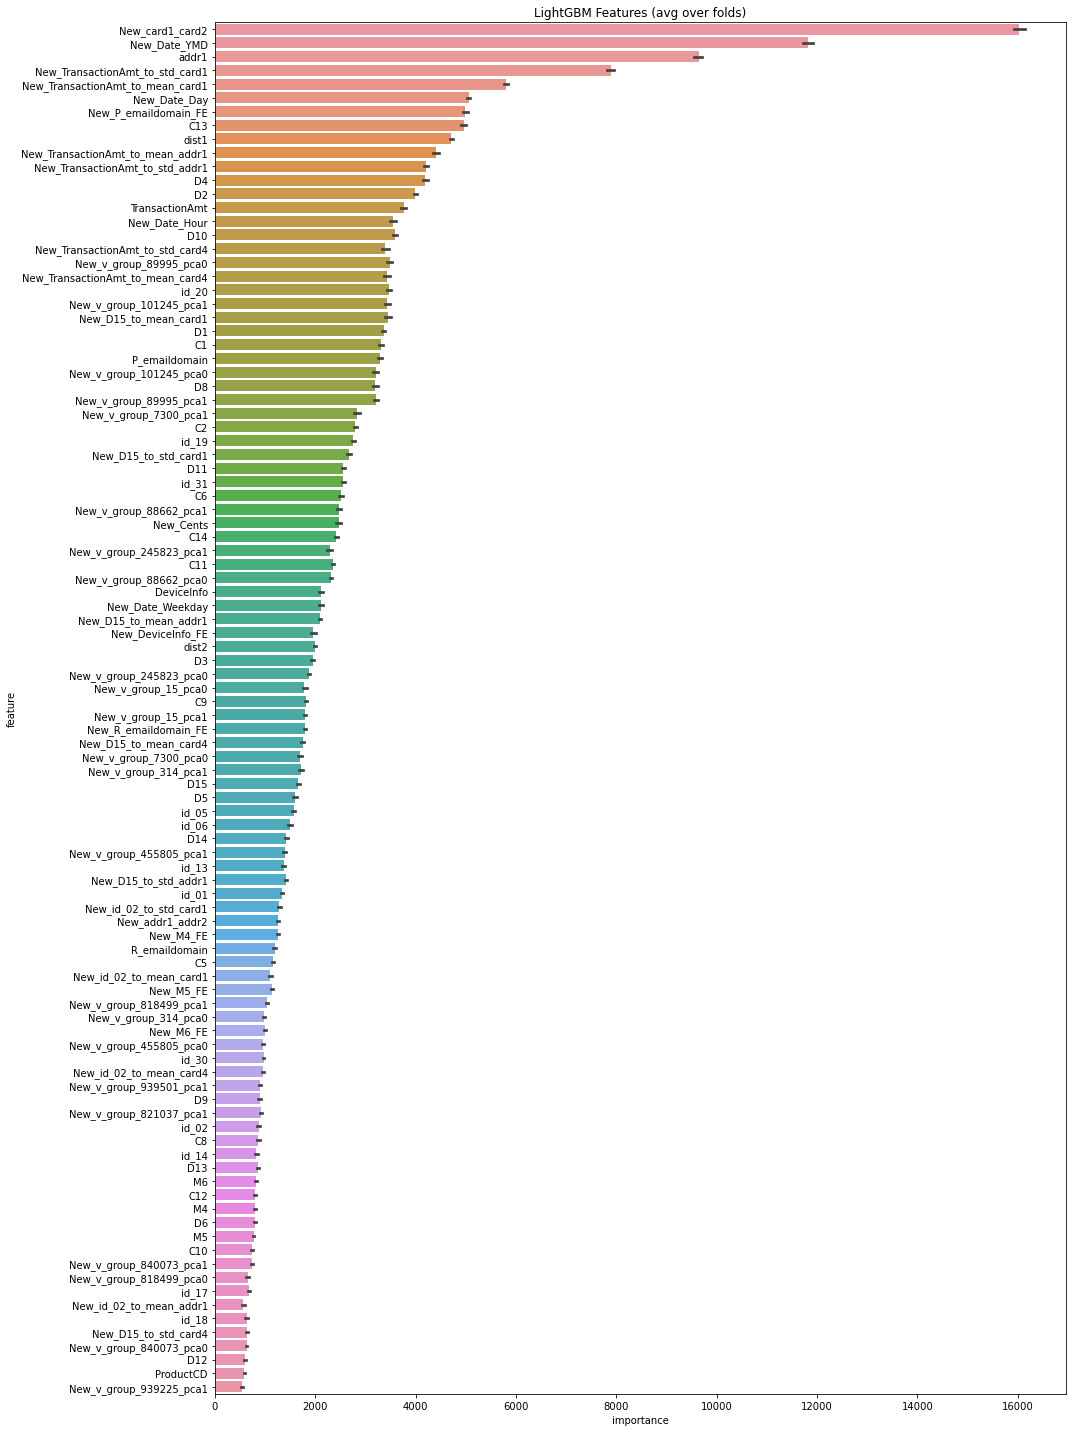

In [172]:
display_importances(feature_importance)